<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-и-подготовка-данных-(ресемплирование)" data-toc-modified-id="Изучение-и-подготовка-данных-(ресемплирование)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение и подготовка данных (ресемплирование)</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Анализ-различных-моделей" data-toc-modified-id="Анализ-различных-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ различных моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Изучение и подготовка данных (ресемплирование)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor

/opt/anaconda3/envs/practicum/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Код для чтения данных
df_taxi = pd.read_csv('df_taxi.csv', parse_dates=[0], index_col=[0])  # Локальный путь

In [4]:
df_taxi.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [5]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# Проверим, в хронологическом ли порядке расположены даты и время
df_taxi.index.is_monotonic

True

In [7]:
# Выполним ресемплирование данных по одному часу, для этого посчитаем сумму заказов в час
df_taxi = df_taxi.resample('1H').sum()

In [8]:
df_taxi.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

## Анализ данных

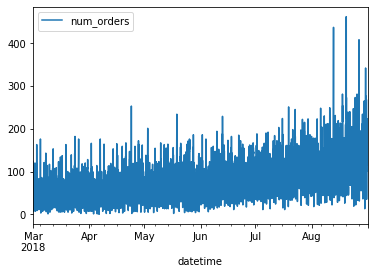

In [9]:
# Построим зависимость заказов от времени
df_taxi.plot();

График не информативный, добавим скользящее среднее в данные

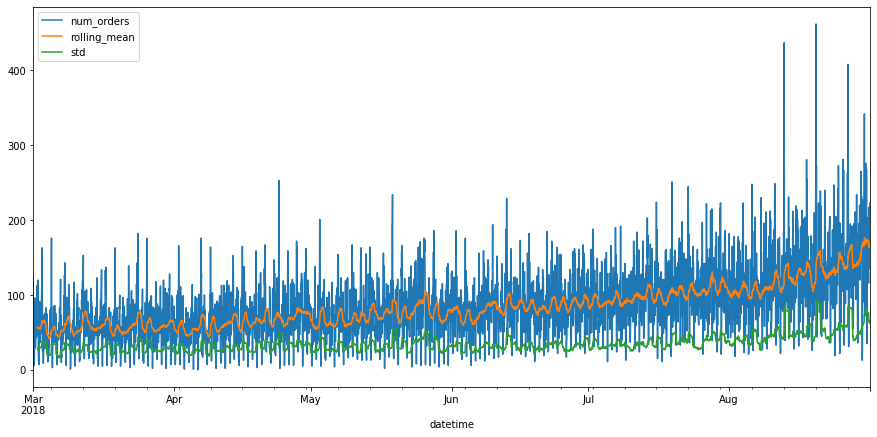

In [10]:
# Добавим в данные скользящее среднее за 24 часа
df_taxi_new = df_taxi.copy()
df_taxi_new['rolling_mean'] = df_taxi_new['num_orders'].rolling(24).mean()
df_taxi_new['std'] = df_taxi_new['num_orders'].rolling(24).std()
df_taxi_new.plot(figsize=(15, 7));

Видим, что за весь период времени среднее количество заказов растет. Кроме того можно сказать, что ряд нестационарный, так как среднее значение меняется, хотя стандартное отклонение при этом почти неизменно.

In [11]:
# Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(df_taxi)

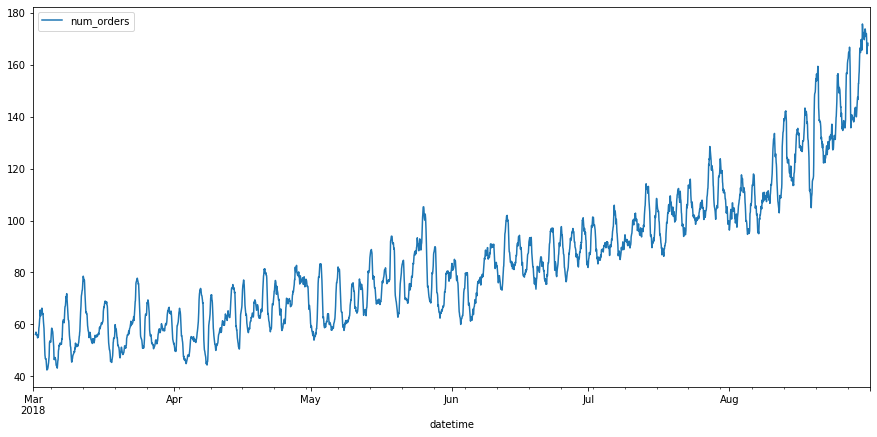

In [12]:
decomposed.trend.plot(figsize=(15, 7));

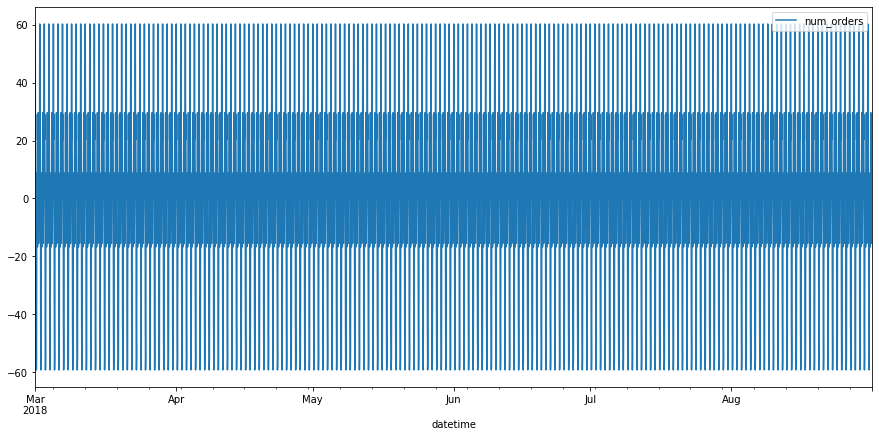

In [13]:
decomposed.seasonal.plot(figsize=(15, 7));

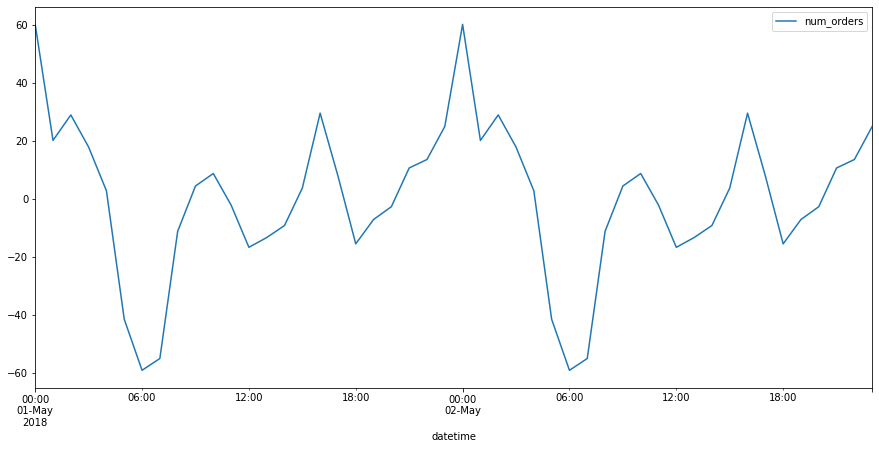

In [14]:
decomposed.seasonal['2018-05-01': '2018-05-02'].plot(figsize=(15, 7));

По тренду видим, что среднее значение растет на протяжении всего периода. По сезонности можно сказать, что больше всего заказов ночью, меньше всего в шесть утра!

## Анализ различных моделей

In [15]:
# Напишем функцию, которая создает дополнительные признаки: день, день недели, час, отставание в 1 час
# на определенное количество шагов. Кроме того функция обновляет скользящее среднее
# и удаляет столбец со стандартным отклонением
df_taxi_new_features = df_taxi_new.copy()
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.drop('std', axis=1)

In [16]:
make_features(df_taxi_new_features, 50, 24)

In [17]:
df_taxi_new_features.head()

num_orders  rolling_mean  std  day  dayofweek  hour  \
datetime                                                                   
2018-03-01 00:00:00         124           NaN  NaN    1          3     0   
2018-03-01 01:00:00          85           NaN  NaN    1          3     1   
2018-03-01 02:00:00          71           NaN  NaN    1          3     2   
2018-03-01 03:00:00          66           NaN  NaN    1          3     3   
2018-03-01 04:00:00          43           NaN  NaN    1          3     4   

                     lag_1  lag_2  lag_3  lag_4  ...  lag_41  lag_42  lag_43  \
datetime                                         ...                           
2018-03-01 00:00:00    NaN    NaN    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 01:00:00  124.0    NaN    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 02:00:00   85.0  124.0    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 03:00:00   71.0   85.0  124.0    NaN  ...     NaN     NaN     NaN   
2018-03-01 04:00:00   66.0   71.0   85.0  124.0  ...     NaN     NaN     NaN   

                     lag_44  lag_45  lag_46  lag_47  lag_48  lag_49  lag_50  
datetime                                                                     
2018-03-01 00:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 02:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 03:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-03-01 04:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[5 rows x 56 columns]

In [18]:
# Разделим данные на обучающую и тестовую выборки
train, valid_test = train_test_split(df_taxi_new_features, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)
train = train.dropna()

In [19]:
# Выделим переменные признаки и признак, который нужно предсказать
features_train = train.drop('num_orders', axis=1) # извлеките признаки
target_train = train['num_orders'] # извлеките целевой признак

features_valid = valid.drop('num_orders', axis=1) # извлеките признаки
target_valid = valid['num_orders'] # извлеките целевой признак

features_test = test.drop('num_orders', axis=1) # извлеките признаки
target_test = test['num_orders'] # извлеките целевой признак

features_valid_test = valid_test.drop('num_orders', axis=1) # извлеките признаки
target_valid_test = valid_test['num_orders'] # извлеките целевой признак

### Линейная регрессия

In [20]:
model = LinearRegression()
model.fit(features_train, target_train)
pred_valid = model.predict(features_valid)
pred_test = model.predict(features_test)                   
print('RMSE валидационной выборки:', mean_squared_error(pred_valid, target_valid)**0.5)
print('RMSE тестовой выборки:', mean_squared_error(pred_test, target_test)**0.5)

RMSE валидационной выборки: 31.466060197707467
RMSE тестовой выборки: 41.74484960927736


### LightGBM

In [21]:
model_lgbm = LGBMRegressor(random_state=12345)
params_lgbm = {'n_estimators' : [100, 200, 500],
               'max_depth' : range(2, 7),
               'num_leaves': [20, 30, 45]}

tscv = TimeSeriesSplit()
search_lgbm = GridSearchCV(estimator=model_lgbm, cv=tscv, param_grid=params_lgbm, scoring='neg_mean_squared_error',
                           verbose=3)
result_lgbm = search_lgbm.fit(features_train, target_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END max_depth=2, n_estimators=100, num_leaves=20;, score=-413.610 total time=   0.1s
[CV 2/5] END max_depth=2, n_estimators=100, num_leaves=20;, score=-503.939 total time=   0.0s
[CV 3/5] END max_depth=2, n_estimators=100, num_leaves=20;, score=-499.799 total time=   0.0s
[CV 4/5] END max_depth=2, n_estimators=100, num_leaves=20;, score=-543.661 total time=   0.0s
[CV 5/5] END max_depth=2, n_estimators=100, num_leaves=20;, score=-697.206 total time=   0.0s
[CV 1/5] END max_depth=2, n_estimators=100, num_leaves=30;, score=-413.610 total time=   0.0s
[CV 2/5] END max_depth=2, n_estimators=100, num_leaves=30;, score=-503.939 total time=   0.0s
[CV 3/5] END max_depth=2, n_estimators=100, num_leaves=30;, score=-499.799 total time=   0.0s
[CV 4/5] END max_depth=2, n_estimators=100, num_leaves=30;, score=-543.661 total time=   0.0s
[CV 5/5] END max_depth=2, n_estimators=100, num_leaves=30;, score=-697.206 total time=   0.0

[CV 3/5] END max_depth=3, n_estimators=500, num_leaves=45;, score=-475.037 total time=   0.1s
[CV 4/5] END max_depth=3, n_estimators=500, num_leaves=45;, score=-528.118 total time=   0.2s
[CV 5/5] END max_depth=3, n_estimators=500, num_leaves=45;, score=-664.647 total time=   0.2s
[CV 1/5] END max_depth=4, n_estimators=100, num_leaves=20;, score=-416.962 total time=   0.0s
[CV 2/5] END max_depth=4, n_estimators=100, num_leaves=20;, score=-491.115 total time=   0.0s
[CV 3/5] END max_depth=4, n_estimators=100, num_leaves=20;, score=-480.781 total time=   0.0s
[CV 4/5] END max_depth=4, n_estimators=100, num_leaves=20;, score=-526.273 total time=   0.1s
[CV 5/5] END max_depth=4, n_estimators=100, num_leaves=20;, score=-666.560 total time=   0.1s
[CV 1/5] END max_depth=4, n_estimators=100, num_leaves=30;, score=-416.962 total time=   0.0s
[CV 2/5] END max_depth=4, n_estimators=100, num_leaves=30;, score=-491.115 total time=   0.0s
[CV 3/5] END max_depth=4, n_estimators=100, num_leaves=30;, 

[CV 2/5] END max_depth=5, n_estimators=500, num_leaves=45;, score=-492.095 total time=   0.2s
[CV 3/5] END max_depth=5, n_estimators=500, num_leaves=45;, score=-506.183 total time=   0.2s
[CV 4/5] END max_depth=5, n_estimators=500, num_leaves=45;, score=-547.819 total time=   0.3s
[CV 5/5] END max_depth=5, n_estimators=500, num_leaves=45;, score=-651.162 total time=   0.3s
[CV 1/5] END max_depth=6, n_estimators=100, num_leaves=20;, score=-447.797 total time=   0.0s
[CV 2/5] END max_depth=6, n_estimators=100, num_leaves=20;, score=-484.493 total time=   0.1s
[CV 3/5] END max_depth=6, n_estimators=100, num_leaves=20;, score=-494.981 total time=   0.1s
[CV 4/5] END max_depth=6, n_estimators=100, num_leaves=20;, score=-543.265 total time=   0.1s
[CV 5/5] END max_depth=6, n_estimators=100, num_leaves=20;, score=-662.445 total time=   0.1s
[CV 1/5] END max_depth=6, n_estimators=100, num_leaves=30;, score=-438.357 total time=   0.0s
[CV 2/5] END max_depth=6, n_estimators=100, num_leaves=30;, 

In [22]:
print('Лучшее значение RMSE в LightGBM:', round(abs(result_lgbm.best_score_)**0.5, 2))
print('Лучшие параметры LightGBM:', result_lgbm.best_params_)

Лучшее значение RMSE в LightGBM: 22.7
Лучшие параметры LightGBM: {'max_depth': 4, 'n_estimators': 200, 'num_leaves': 20}


In [24]:
# Проверим модель LightGBM на валидационной+тестовой выборках
model = result_lgbm.best_estimator_
model.fit(features_train, target_train)
pred_valid_test = model.predict(features_valid_test)
rmse = mean_squared_error(pred_valid_test, target_valid_test)**0.5
print("RMSE лучшей модели на валидационной+тестовой выборках:", rmse)

RMSE лучшей модели на валидационной+тестовой выборках: 41.5380017093039


### CatBoost

In [26]:
model_cat = CatBoostRegressor(random_seed=12345)
params_cat = {'iterations' : [100, 300, 500, 1000],
              'depth' : range(2, 8)}

tscv = TimeSeriesSplit()
search_cat = GridSearchCV(estimator=model_cat, cv=tscv, param_grid=params_cat, scoring='neg_mean_squared_error')
result_cat = search_cat.fit(features_train , target_train)

Learning rate set to 0.203966
0:	learn: 27.2262891	total: 63.6ms	remaining: 6.3s
1:	learn: 25.7030672	total: 64.2ms	remaining: 3.15s
2:	learn: 24.2175639	total: 64.8ms	remaining: 2.09s
3:	learn: 23.0289465	total: 65.3ms	remaining: 1.57s
4:	learn: 22.2650479	total: 65.9ms	remaining: 1.25s
5:	learn: 21.6352372	total: 66.4ms	remaining: 1.04s
6:	learn: 21.1152601	total: 66.9ms	remaining: 889ms
7:	learn: 20.5598497	total: 67.4ms	remaining: 775ms
8:	learn: 20.2257592	total: 67.9ms	remaining: 687ms
9:	learn: 19.9464436	total: 68.4ms	remaining: 615ms
10:	learn: 19.7228240	total: 69ms	remaining: 558ms
11:	learn: 19.4251029	total: 69.5ms	remaining: 510ms
12:	learn: 19.2007554	total: 70.1ms	remaining: 469ms
13:	learn: 19.0377416	total: 70.6ms	remaining: 433ms
14:	learn: 18.9039769	total: 71ms	remaining: 403ms
15:	learn: 18.7840924	total: 71.5ms	remaining: 375ms
16:	learn: 18.6585530	total: 71.9ms	remaining: 351ms
17:	learn: 18.5629110	total: 72.4ms	remaining: 330ms
18:	learn: 18.3599739	total: 72

96:	learn: 14.7161689	total: 54.3ms	remaining: 1.68ms
97:	learn: 14.6801691	total: 55ms	remaining: 1.12ms
98:	learn: 14.6550280	total: 55.8ms	remaining: 563us
99:	learn: 14.6337665	total: 56.3ms	remaining: 0us
Learning rate set to 0.247918
0:	learn: 28.9403349	total: 2.85ms	remaining: 282ms
1:	learn: 26.7588440	total: 3.75ms	remaining: 184ms
2:	learn: 25.2440615	total: 4.49ms	remaining: 145ms
3:	learn: 24.1158724	total: 5.39ms	remaining: 129ms
4:	learn: 23.2246692	total: 6.24ms	remaining: 119ms
5:	learn: 22.5521636	total: 6.91ms	remaining: 108ms
6:	learn: 22.0257649	total: 7.65ms	remaining: 102ms
7:	learn: 21.6628226	total: 8.26ms	remaining: 95ms
8:	learn: 21.4505031	total: 8.9ms	remaining: 90ms
9:	learn: 21.1850749	total: 9.52ms	remaining: 85.7ms
10:	learn: 20.9149355	total: 10.2ms	remaining: 82.2ms
11:	learn: 20.7606388	total: 11ms	remaining: 80.7ms
12:	learn: 20.5028823	total: 11.7ms	remaining: 78.2ms
13:	learn: 20.2578946	total: 12.3ms	remaining: 75.7ms
14:	learn: 20.1357273	total:

0:	learn: 30.8059247	total: 1.25ms	remaining: 123ms
1:	learn: 28.3126702	total: 2.31ms	remaining: 113ms
2:	learn: 26.5519709	total: 3.17ms	remaining: 103ms
3:	learn: 25.3613751	total: 3.94ms	remaining: 94.6ms
4:	learn: 24.4576208	total: 4.68ms	remaining: 89ms
5:	learn: 23.8038571	total: 5.38ms	remaining: 84.4ms
6:	learn: 23.2777490	total: 6.08ms	remaining: 80.8ms
7:	learn: 22.8730253	total: 7.31ms	remaining: 84.1ms
8:	learn: 22.5364546	total: 8.1ms	remaining: 81.9ms
9:	learn: 22.2952084	total: 8.77ms	remaining: 78.9ms
10:	learn: 22.0415753	total: 9.58ms	remaining: 77.5ms
11:	learn: 21.8690829	total: 10.4ms	remaining: 76.4ms
12:	learn: 21.7142613	total: 11.2ms	remaining: 74.9ms
13:	learn: 21.5698190	total: 12ms	remaining: 73.8ms
14:	learn: 21.4809790	total: 12.8ms	remaining: 72.6ms
15:	learn: 21.3866915	total: 13.6ms	remaining: 71.4ms
16:	learn: 21.2844369	total: 14.8ms	remaining: 72ms
17:	learn: 21.1829708	total: 15.5ms	remaining: 70.8ms
18:	learn: 21.1084185	total: 16.4ms	remaining: 6

209:	learn: 13.2113953	total: 98.1ms	remaining: 42ms
210:	learn: 13.1906537	total: 98.6ms	remaining: 41.6ms
211:	learn: 13.1633724	total: 99.1ms	remaining: 41.2ms
212:	learn: 13.1541511	total: 99.6ms	remaining: 40.7ms
213:	learn: 13.1510175	total: 100ms	remaining: 40.2ms
214:	learn: 13.1369219	total: 100ms	remaining: 39.7ms
215:	learn: 13.1124976	total: 101ms	remaining: 39.3ms
216:	learn: 13.1046937	total: 102ms	remaining: 39ms
217:	learn: 13.1017027	total: 102ms	remaining: 38.5ms
218:	learn: 13.0763650	total: 103ms	remaining: 38ms
219:	learn: 13.0545150	total: 103ms	remaining: 37.6ms
220:	learn: 13.0372102	total: 104ms	remaining: 37.1ms
221:	learn: 13.0195782	total: 104ms	remaining: 36.7ms
222:	learn: 13.0052204	total: 105ms	remaining: 36.2ms
223:	learn: 12.9984830	total: 105ms	remaining: 35.7ms
224:	learn: 12.9846619	total: 106ms	remaining: 35.2ms
225:	learn: 12.9531466	total: 106ms	remaining: 34.8ms
226:	learn: 12.9453093	total: 107ms	remaining: 34.3ms
227:	learn: 12.9270019	total: 

226:	learn: 14.6671530	total: 127ms	remaining: 40.9ms
227:	learn: 14.6511388	total: 128ms	remaining: 40.3ms
228:	learn: 14.6407439	total: 128ms	remaining: 39.8ms
229:	learn: 14.6211680	total: 129ms	remaining: 39.2ms
230:	learn: 14.6126090	total: 129ms	remaining: 38.7ms
231:	learn: 14.6020688	total: 130ms	remaining: 38.1ms
232:	learn: 14.5811273	total: 130ms	remaining: 37.5ms
233:	learn: 14.5723782	total: 131ms	remaining: 36.9ms
234:	learn: 14.5525795	total: 131ms	remaining: 36.4ms
235:	learn: 14.5442573	total: 132ms	remaining: 35.8ms
236:	learn: 14.5110927	total: 132ms	remaining: 35.2ms
237:	learn: 14.4943816	total: 133ms	remaining: 34.6ms
238:	learn: 14.4838013	total: 134ms	remaining: 34.1ms
239:	learn: 14.4790849	total: 134ms	remaining: 33.6ms
240:	learn: 14.4711220	total: 135ms	remaining: 33ms
241:	learn: 14.4613528	total: 135ms	remaining: 32.4ms
242:	learn: 14.4573560	total: 136ms	remaining: 31.9ms
243:	learn: 14.4457327	total: 136ms	remaining: 31.3ms
244:	learn: 14.4420502	total: 

106:	learn: 17.8829545	total: 68.1ms	remaining: 123ms
107:	learn: 17.8653019	total: 69ms	remaining: 123ms
108:	learn: 17.8443034	total: 69.8ms	remaining: 122ms
109:	learn: 17.8172028	total: 70.4ms	remaining: 122ms
110:	learn: 17.8043039	total: 71.3ms	remaining: 121ms
111:	learn: 17.7976852	total: 72ms	remaining: 121ms
112:	learn: 17.7754629	total: 72.6ms	remaining: 120ms
113:	learn: 17.7713320	total: 73.2ms	remaining: 119ms
114:	learn: 17.7473690	total: 73.9ms	remaining: 119ms
115:	learn: 17.7270016	total: 74.6ms	remaining: 118ms
116:	learn: 17.7099553	total: 75.2ms	remaining: 118ms
117:	learn: 17.6963725	total: 76ms	remaining: 117ms
118:	learn: 17.6603427	total: 76.7ms	remaining: 117ms
119:	learn: 17.6324005	total: 77.4ms	remaining: 116ms
120:	learn: 17.6167198	total: 78.2ms	remaining: 116ms
121:	learn: 17.6045273	total: 78.9ms	remaining: 115ms
122:	learn: 17.6006426	total: 79.7ms	remaining: 115ms
123:	learn: 17.5833325	total: 80.4ms	remaining: 114ms
124:	learn: 17.5516638	total: 81ms

52:	learn: 19.7465493	total: 39.8ms	remaining: 186ms
53:	learn: 19.7144535	total: 40.7ms	remaining: 186ms
54:	learn: 19.6837732	total: 41.5ms	remaining: 185ms
55:	learn: 19.6654599	total: 42.3ms	remaining: 184ms
56:	learn: 19.6362113	total: 43.2ms	remaining: 184ms
57:	learn: 19.6163835	total: 44.1ms	remaining: 184ms
58:	learn: 19.5771244	total: 45ms	remaining: 184ms
59:	learn: 19.5502605	total: 45.9ms	remaining: 183ms
60:	learn: 19.5258962	total: 46.6ms	remaining: 183ms
61:	learn: 19.5039906	total: 47.3ms	remaining: 181ms
62:	learn: 19.4802606	total: 47.9ms	remaining: 180ms
63:	learn: 19.4321922	total: 48.7ms	remaining: 179ms
64:	learn: 19.4094864	total: 49.7ms	remaining: 180ms
65:	learn: 19.3944124	total: 50.6ms	remaining: 179ms
66:	learn: 19.3740600	total: 51.4ms	remaining: 179ms
67:	learn: 19.3539586	total: 52ms	remaining: 177ms
68:	learn: 19.3354804	total: 52.9ms	remaining: 177ms
69:	learn: 19.3104639	total: 53.7ms	remaining: 177ms
70:	learn: 19.2893772	total: 54.6ms	remaining: 176

Learning rate set to 0.117801
0:	learn: 32.4022816	total: 1.13ms	remaining: 338ms
1:	learn: 31.1579777	total: 1.84ms	remaining: 275ms
2:	learn: 30.0043119	total: 2.6ms	remaining: 258ms
3:	learn: 29.0173428	total: 3.33ms	remaining: 246ms
4:	learn: 28.1441571	total: 4.01ms	remaining: 237ms
5:	learn: 27.3499572	total: 4.71ms	remaining: 231ms
6:	learn: 26.7175602	total: 5.46ms	remaining: 228ms
7:	learn: 26.1095336	total: 6.14ms	remaining: 224ms
8:	learn: 25.5411800	total: 6.95ms	remaining: 225ms
9:	learn: 25.1585290	total: 7.69ms	remaining: 223ms
10:	learn: 24.7260761	total: 8.51ms	remaining: 224ms
11:	learn: 24.3698582	total: 9.52ms	remaining: 228ms
12:	learn: 24.0843633	total: 10.5ms	remaining: 231ms
13:	learn: 23.7836932	total: 11.2ms	remaining: 230ms
14:	learn: 23.5383359	total: 12.4ms	remaining: 235ms
15:	learn: 23.3524362	total: 13.2ms	remaining: 234ms
16:	learn: 23.1692986	total: 14.1ms	remaining: 235ms
17:	learn: 22.9945760	total: 15.1ms	remaining: 236ms
18:	learn: 22.8385355	total

237:	learn: 17.9339348	total: 188ms	remaining: 48.9ms
238:	learn: 17.9273229	total: 189ms	remaining: 48.2ms
239:	learn: 17.9183062	total: 189ms	remaining: 47.4ms
240:	learn: 17.9089530	total: 190ms	remaining: 46.5ms
241:	learn: 17.8979232	total: 191ms	remaining: 45.7ms
242:	learn: 17.8843956	total: 191ms	remaining: 44.9ms
243:	learn: 17.8767400	total: 192ms	remaining: 44.1ms
244:	learn: 17.8652388	total: 193ms	remaining: 43.4ms
245:	learn: 17.8600267	total: 194ms	remaining: 42.5ms
246:	learn: 17.8515582	total: 195ms	remaining: 41.8ms
247:	learn: 17.8428242	total: 195ms	remaining: 41ms
248:	learn: 17.8260445	total: 196ms	remaining: 40.2ms
249:	learn: 17.8234458	total: 197ms	remaining: 39.4ms
250:	learn: 17.8176739	total: 197ms	remaining: 38.6ms
251:	learn: 17.8104744	total: 198ms	remaining: 37.7ms
252:	learn: 17.8087178	total: 199ms	remaining: 36.9ms
253:	learn: 17.8052886	total: 200ms	remaining: 36.1ms
254:	learn: 17.7926999	total: 201ms	remaining: 35.4ms
255:	learn: 17.7844362	total: 

268:	learn: 13.6806570	total: 124ms	remaining: 107ms
269:	learn: 13.6687300	total: 125ms	remaining: 106ms
270:	learn: 13.6620838	total: 125ms	remaining: 106ms
271:	learn: 13.6537577	total: 126ms	remaining: 106ms
272:	learn: 13.6336587	total: 126ms	remaining: 105ms
273:	learn: 13.6222111	total: 127ms	remaining: 105ms
274:	learn: 13.6086714	total: 127ms	remaining: 104ms
275:	learn: 13.5949670	total: 128ms	remaining: 104ms
276:	learn: 13.5917826	total: 128ms	remaining: 103ms
277:	learn: 13.5838559	total: 129ms	remaining: 103ms
278:	learn: 13.5808145	total: 129ms	remaining: 102ms
279:	learn: 13.5698089	total: 130ms	remaining: 102ms
280:	learn: 13.5668556	total: 130ms	remaining: 101ms
281:	learn: 13.5580125	total: 131ms	remaining: 101ms
282:	learn: 13.5483398	total: 131ms	remaining: 101ms
283:	learn: 13.5452416	total: 132ms	remaining: 100ms
284:	learn: 13.5112612	total: 132ms	remaining: 99.6ms
285:	learn: 13.4866783	total: 132ms	remaining: 99ms
286:	learn: 13.4796401	total: 133ms	remaining:

117:	learn: 17.2339131	total: 65.2ms	remaining: 211ms
118:	learn: 17.2215396	total: 65.8ms	remaining: 211ms
119:	learn: 17.1920646	total: 66.4ms	remaining: 210ms
120:	learn: 17.1867468	total: 66.9ms	remaining: 210ms
121:	learn: 17.1607229	total: 67.5ms	remaining: 209ms
122:	learn: 17.1395714	total: 68ms	remaining: 209ms
123:	learn: 17.1127133	total: 68.5ms	remaining: 208ms
124:	learn: 17.0907985	total: 69.1ms	remaining: 207ms
125:	learn: 17.0837154	total: 69.7ms	remaining: 207ms
126:	learn: 17.0603518	total: 70.2ms	remaining: 206ms
127:	learn: 17.0532469	total: 70.7ms	remaining: 206ms
128:	learn: 17.0380047	total: 71.2ms	remaining: 205ms
129:	learn: 17.0312934	total: 71.7ms	remaining: 204ms
130:	learn: 17.0122769	total: 72.4ms	remaining: 204ms
131:	learn: 16.9866084	total: 72.9ms	remaining: 203ms
132:	learn: 16.9783949	total: 73.5ms	remaining: 203ms
133:	learn: 16.9638689	total: 74.1ms	remaining: 202ms
134:	learn: 16.9450162	total: 74.7ms	remaining: 202ms
135:	learn: 16.9243061	total: 

445:	learn: 13.8089821	total: 251ms	remaining: 30.3ms
446:	learn: 13.8066536	total: 251ms	remaining: 29.8ms
447:	learn: 13.7994689	total: 252ms	remaining: 29.2ms
448:	learn: 13.7937361	total: 253ms	remaining: 28.7ms
449:	learn: 13.7858631	total: 255ms	remaining: 28.3ms
450:	learn: 13.7798877	total: 256ms	remaining: 27.8ms
451:	learn: 13.7783383	total: 256ms	remaining: 27.2ms
452:	learn: 13.7733678	total: 257ms	remaining: 26.6ms
453:	learn: 13.7643357	total: 257ms	remaining: 26.1ms
454:	learn: 13.7569854	total: 258ms	remaining: 25.5ms
455:	learn: 13.7449105	total: 258ms	remaining: 24.9ms
456:	learn: 13.7396436	total: 259ms	remaining: 24.4ms
457:	learn: 13.7322722	total: 259ms	remaining: 23.8ms
458:	learn: 13.7246282	total: 260ms	remaining: 23.2ms
459:	learn: 13.7169277	total: 261ms	remaining: 22.7ms
460:	learn: 13.7076754	total: 261ms	remaining: 22.1ms
461:	learn: 13.7026427	total: 262ms	remaining: 21.5ms
462:	learn: 13.6971137	total: 262ms	remaining: 21ms
463:	learn: 13.6916729	total: 

210:	learn: 17.1828109	total: 137ms	remaining: 187ms
211:	learn: 17.1698908	total: 138ms	remaining: 187ms
212:	learn: 17.1521230	total: 138ms	remaining: 186ms
213:	learn: 17.1394202	total: 139ms	remaining: 186ms
214:	learn: 17.1247469	total: 140ms	remaining: 185ms
215:	learn: 17.1187812	total: 141ms	remaining: 185ms
216:	learn: 17.1120924	total: 141ms	remaining: 184ms
217:	learn: 17.1057547	total: 142ms	remaining: 184ms
218:	learn: 17.0924217	total: 143ms	remaining: 183ms
219:	learn: 17.0895090	total: 143ms	remaining: 183ms
220:	learn: 17.0864186	total: 144ms	remaining: 182ms
221:	learn: 17.0779742	total: 145ms	remaining: 181ms
222:	learn: 17.0680290	total: 145ms	remaining: 181ms
223:	learn: 17.0590445	total: 146ms	remaining: 180ms
224:	learn: 17.0437617	total: 147ms	remaining: 179ms
225:	learn: 17.0314090	total: 148ms	remaining: 179ms
226:	learn: 17.0232936	total: 148ms	remaining: 178ms
227:	learn: 17.0147542	total: 149ms	remaining: 178ms
228:	learn: 17.0028051	total: 150ms	remaining:

Learning rate set to 0.07679
0:	learn: 31.8459606	total: 840us	remaining: 419ms
1:	learn: 31.0465682	total: 1.58ms	remaining: 393ms
2:	learn: 30.3084982	total: 2.41ms	remaining: 399ms
3:	learn: 29.6047797	total: 3.06ms	remaining: 380ms
4:	learn: 28.9741646	total: 3.74ms	remaining: 370ms
5:	learn: 28.3280637	total: 4.4ms	remaining: 363ms
6:	learn: 27.8154553	total: 5.06ms	remaining: 356ms
7:	learn: 27.2947897	total: 5.82ms	remaining: 358ms
8:	learn: 26.7969560	total: 6.44ms	remaining: 351ms
9:	learn: 26.4074484	total: 7.31ms	remaining: 358ms
10:	learn: 25.9878646	total: 7.99ms	remaining: 355ms
11:	learn: 25.6453584	total: 8.91ms	remaining: 363ms
12:	learn: 25.3539975	total: 9.97ms	remaining: 373ms
13:	learn: 25.0909574	total: 10.8ms	remaining: 375ms
14:	learn: 24.8151067	total: 11.4ms	remaining: 370ms
15:	learn: 24.5597034	total: 12.1ms	remaining: 365ms
16:	learn: 24.3252045	total: 12.7ms	remaining: 362ms
17:	learn: 24.1144351	total: 13.4ms	remaining: 359ms
18:	learn: 23.8970526	total: 

263:	learn: 17.5163827	total: 188ms	remaining: 168ms
264:	learn: 17.5128210	total: 188ms	remaining: 167ms
265:	learn: 17.5025850	total: 189ms	remaining: 166ms
266:	learn: 17.4981773	total: 190ms	remaining: 166ms
267:	learn: 17.4877071	total: 191ms	remaining: 165ms
268:	learn: 17.4772192	total: 191ms	remaining: 164ms
269:	learn: 17.4717559	total: 192ms	remaining: 163ms
270:	learn: 17.4652109	total: 193ms	remaining: 163ms
271:	learn: 17.4636783	total: 193ms	remaining: 162ms
272:	learn: 17.4523840	total: 194ms	remaining: 161ms
273:	learn: 17.4477054	total: 195ms	remaining: 160ms
274:	learn: 17.4397329	total: 195ms	remaining: 160ms
275:	learn: 17.4328344	total: 196ms	remaining: 159ms
276:	learn: 17.4276362	total: 196ms	remaining: 158ms
277:	learn: 17.4187144	total: 197ms	remaining: 157ms
278:	learn: 17.4073778	total: 198ms	remaining: 157ms
279:	learn: 17.4012523	total: 199ms	remaining: 156ms
280:	learn: 17.3997764	total: 199ms	remaining: 155ms
281:	learn: 17.3935342	total: 200ms	remaining:

6:	learn: 28.4029272	total: 5.36ms	remaining: 377ms
7:	learn: 27.8501165	total: 6.13ms	remaining: 377ms
8:	learn: 27.3114971	total: 6.91ms	remaining: 377ms
9:	learn: 26.9186078	total: 7.65ms	remaining: 375ms
10:	learn: 26.4944698	total: 8.5ms	remaining: 378ms
11:	learn: 26.1234148	total: 9.27ms	remaining: 377ms
12:	learn: 25.8319816	total: 10.2ms	remaining: 383ms
13:	learn: 25.4965504	total: 11.1ms	remaining: 384ms
14:	learn: 25.2037350	total: 11.9ms	remaining: 386ms
15:	learn: 24.9263218	total: 12.9ms	remaining: 389ms
16:	learn: 24.6584982	total: 13.6ms	remaining: 386ms
17:	learn: 24.4294697	total: 14.3ms	remaining: 383ms
18:	learn: 24.2390854	total: 15.1ms	remaining: 382ms
19:	learn: 24.0108793	total: 15.9ms	remaining: 381ms
20:	learn: 23.8257293	total: 16.7ms	remaining: 381ms
21:	learn: 23.6401470	total: 17.5ms	remaining: 381ms
22:	learn: 23.4579355	total: 18.5ms	remaining: 383ms
23:	learn: 23.3115439	total: 19.3ms	remaining: 383ms
24:	learn: 23.1891650	total: 20.2ms	remaining: 385m

248:	learn: 18.5934179	total: 194ms	remaining: 196ms
249:	learn: 18.5867391	total: 195ms	remaining: 195ms
250:	learn: 18.5805449	total: 196ms	remaining: 194ms
251:	learn: 18.5727432	total: 197ms	remaining: 193ms
252:	learn: 18.5655686	total: 198ms	remaining: 193ms
253:	learn: 18.5591762	total: 198ms	remaining: 192ms
254:	learn: 18.5533117	total: 199ms	remaining: 191ms
255:	learn: 18.5432758	total: 200ms	remaining: 190ms
256:	learn: 18.5378212	total: 200ms	remaining: 189ms
257:	learn: 18.5318240	total: 201ms	remaining: 189ms
258:	learn: 18.5249861	total: 202ms	remaining: 188ms
259:	learn: 18.5149904	total: 203ms	remaining: 187ms
260:	learn: 18.5098275	total: 203ms	remaining: 186ms
261:	learn: 18.5045106	total: 204ms	remaining: 185ms
262:	learn: 18.4964992	total: 205ms	remaining: 185ms
263:	learn: 18.4905977	total: 206ms	remaining: 184ms
264:	learn: 18.4834022	total: 207ms	remaining: 184ms
265:	learn: 18.4731205	total: 208ms	remaining: 183ms
266:	learn: 18.4686240	total: 209ms	remaining:

487:	learn: 17.2021761	total: 383ms	remaining: 9.42ms
488:	learn: 17.1931963	total: 384ms	remaining: 8.64ms
489:	learn: 17.1840020	total: 385ms	remaining: 7.85ms
490:	learn: 17.1789799	total: 386ms	remaining: 7.07ms
491:	learn: 17.1713622	total: 386ms	remaining: 6.28ms
492:	learn: 17.1639423	total: 388ms	remaining: 5.51ms
493:	learn: 17.1556500	total: 388ms	remaining: 4.72ms
494:	learn: 17.1512926	total: 389ms	remaining: 3.93ms
495:	learn: 17.1423196	total: 390ms	remaining: 3.15ms
496:	learn: 17.1362793	total: 391ms	remaining: 2.36ms
497:	learn: 17.1272821	total: 391ms	remaining: 1.57ms
498:	learn: 17.1234180	total: 392ms	remaining: 785us
499:	learn: 17.1138903	total: 393ms	remaining: 0us
Learning rate set to 0.035445
0:	learn: 29.1534736	total: 553us	remaining: 553ms
1:	learn: 28.8669126	total: 1ms	remaining: 499ms
2:	learn: 28.4635072	total: 1.42ms	remaining: 472ms
3:	learn: 28.0848143	total: 1.85ms	remaining: 460ms
4:	learn: 27.7217554	total: 2.28ms	remaining: 454ms
5:	learn: 27.370

348:	learn: 14.6077985	total: 161ms	remaining: 299ms
349:	learn: 14.5975893	total: 161ms	remaining: 299ms
350:	learn: 14.5948488	total: 162ms	remaining: 299ms
351:	learn: 14.5907412	total: 162ms	remaining: 298ms
352:	learn: 14.5867802	total: 163ms	remaining: 298ms
353:	learn: 14.5845333	total: 163ms	remaining: 298ms
354:	learn: 14.5598852	total: 164ms	remaining: 297ms
355:	learn: 14.5500357	total: 164ms	remaining: 297ms
356:	learn: 14.5268131	total: 164ms	remaining: 296ms
357:	learn: 14.5172095	total: 165ms	remaining: 296ms
358:	learn: 14.5103577	total: 165ms	remaining: 295ms
359:	learn: 14.4952722	total: 166ms	remaining: 294ms
360:	learn: 14.4833950	total: 166ms	remaining: 294ms
361:	learn: 14.4807911	total: 167ms	remaining: 294ms
362:	learn: 14.4677419	total: 167ms	remaining: 293ms
363:	learn: 14.4585305	total: 168ms	remaining: 293ms
364:	learn: 14.4560460	total: 168ms	remaining: 292ms
365:	learn: 14.4536485	total: 169ms	remaining: 292ms
366:	learn: 14.4445841	total: 169ms	remaining:

750:	learn: 11.7061760	total: 345ms	remaining: 114ms
751:	learn: 11.6974166	total: 345ms	remaining: 114ms
752:	learn: 11.6858616	total: 346ms	remaining: 113ms
753:	learn: 11.6773843	total: 346ms	remaining: 113ms
754:	learn: 11.6714877	total: 347ms	remaining: 113ms
755:	learn: 11.6687802	total: 347ms	remaining: 112ms
756:	learn: 11.6664452	total: 348ms	remaining: 112ms
757:	learn: 11.6649232	total: 348ms	remaining: 111ms
758:	learn: 11.6619795	total: 349ms	remaining: 111ms
759:	learn: 11.6568714	total: 349ms	remaining: 110ms
760:	learn: 11.6501424	total: 349ms	remaining: 110ms
761:	learn: 11.6444253	total: 350ms	remaining: 109ms
762:	learn: 11.6380507	total: 350ms	remaining: 109ms
763:	learn: 11.6309848	total: 351ms	remaining: 108ms
764:	learn: 11.6298433	total: 351ms	remaining: 108ms
765:	learn: 11.6262504	total: 352ms	remaining: 107ms
766:	learn: 11.6202167	total: 352ms	remaining: 107ms
767:	learn: 11.6125360	total: 353ms	remaining: 107ms
768:	learn: 11.6057699	total: 353ms	remaining:

98:	learn: 18.6480996	total: 55.8ms	remaining: 508ms
99:	learn: 18.6340617	total: 56.4ms	remaining: 508ms
100:	learn: 18.6156074	total: 57ms	remaining: 508ms
101:	learn: 18.5962877	total: 57.6ms	remaining: 507ms
102:	learn: 18.5699589	total: 58.2ms	remaining: 506ms
103:	learn: 18.5663396	total: 58.7ms	remaining: 505ms
104:	learn: 18.5447430	total: 59.2ms	remaining: 505ms
105:	learn: 18.5164017	total: 59.7ms	remaining: 504ms
106:	learn: 18.4953188	total: 60.3ms	remaining: 503ms
107:	learn: 18.4812743	total: 60.8ms	remaining: 502ms
108:	learn: 18.4617923	total: 61.3ms	remaining: 501ms
109:	learn: 18.4304619	total: 61.8ms	remaining: 500ms
110:	learn: 18.4267012	total: 62.3ms	remaining: 499ms
111:	learn: 18.4050101	total: 62.8ms	remaining: 498ms
112:	learn: 18.3849543	total: 63.3ms	remaining: 497ms
113:	learn: 18.3589545	total: 63.9ms	remaining: 496ms
114:	learn: 18.3388774	total: 64.3ms	remaining: 495ms
115:	learn: 18.3352515	total: 65ms	remaining: 496ms
116:	learn: 18.3185707	total: 65.6

420:	learn: 15.3766539	total: 241ms	remaining: 332ms
421:	learn: 15.3713720	total: 242ms	remaining: 332ms
422:	learn: 15.3660601	total: 243ms	remaining: 331ms
423:	learn: 15.3602678	total: 243ms	remaining: 331ms
424:	learn: 15.3558368	total: 244ms	remaining: 330ms
425:	learn: 15.3507585	total: 245ms	remaining: 330ms
426:	learn: 15.3437664	total: 245ms	remaining: 329ms
427:	learn: 15.3391261	total: 246ms	remaining: 329ms
428:	learn: 15.3291295	total: 247ms	remaining: 328ms
429:	learn: 15.3220204	total: 247ms	remaining: 328ms
430:	learn: 15.3141631	total: 249ms	remaining: 328ms
431:	learn: 15.3069741	total: 249ms	remaining: 328ms
432:	learn: 15.3025329	total: 250ms	remaining: 327ms
433:	learn: 15.2983915	total: 250ms	remaining: 326ms
434:	learn: 15.2940306	total: 251ms	remaining: 326ms
435:	learn: 15.2889688	total: 251ms	remaining: 325ms
436:	learn: 15.2819618	total: 252ms	remaining: 325ms
437:	learn: 15.2778248	total: 253ms	remaining: 324ms
438:	learn: 15.2719859	total: 253ms	remaining:

738:	learn: 13.8627568	total: 427ms	remaining: 151ms
739:	learn: 13.8592958	total: 427ms	remaining: 150ms
740:	learn: 13.8564471	total: 428ms	remaining: 150ms
741:	learn: 13.8549993	total: 429ms	remaining: 149ms
742:	learn: 13.8482779	total: 429ms	remaining: 148ms
743:	learn: 13.8452376	total: 430ms	remaining: 148ms
744:	learn: 13.8423764	total: 430ms	remaining: 147ms
745:	learn: 13.8391611	total: 431ms	remaining: 147ms
746:	learn: 13.8358055	total: 431ms	remaining: 146ms
747:	learn: 13.8345706	total: 432ms	remaining: 145ms
748:	learn: 13.8291119	total: 432ms	remaining: 145ms
749:	learn: 13.8239412	total: 433ms	remaining: 144ms
750:	learn: 13.8225515	total: 433ms	remaining: 144ms
751:	learn: 13.8215782	total: 434ms	remaining: 143ms
752:	learn: 13.8188559	total: 434ms	remaining: 142ms
753:	learn: 13.8136782	total: 435ms	remaining: 142ms
754:	learn: 13.8102641	total: 436ms	remaining: 141ms
755:	learn: 13.8066199	total: 436ms	remaining: 141ms
756:	learn: 13.8016893	total: 437ms	remaining:

39:	learn: 22.3864583	total: 25.4ms	remaining: 611ms
40:	learn: 22.2946452	total: 26.1ms	remaining: 611ms
41:	learn: 22.2112321	total: 26.9ms	remaining: 613ms
42:	learn: 22.1229287	total: 27.6ms	remaining: 614ms
43:	learn: 22.0584992	total: 28.3ms	remaining: 615ms
44:	learn: 21.9789173	total: 29ms	remaining: 615ms
45:	learn: 21.8938009	total: 29.5ms	remaining: 612ms
46:	learn: 21.8196204	total: 30.1ms	remaining: 611ms
47:	learn: 21.7407691	total: 31ms	remaining: 614ms
48:	learn: 21.6912741	total: 31.5ms	remaining: 612ms
49:	learn: 21.6225061	total: 32.1ms	remaining: 609ms
50:	learn: 21.5474129	total: 32.6ms	remaining: 607ms
51:	learn: 21.4628076	total: 33.2ms	remaining: 605ms
52:	learn: 21.3908721	total: 33.8ms	remaining: 603ms
53:	learn: 21.3356744	total: 34.4ms	remaining: 602ms
54:	learn: 21.2665902	total: 34.9ms	remaining: 600ms
55:	learn: 21.2123250	total: 35.5ms	remaining: 598ms
56:	learn: 21.1560264	total: 36ms	remaining: 596ms
57:	learn: 21.1028880	total: 36.8ms	remaining: 597ms

318:	learn: 17.4320991	total: 212ms	remaining: 453ms
319:	learn: 17.4235734	total: 213ms	remaining: 453ms
320:	learn: 17.4174287	total: 214ms	remaining: 453ms
321:	learn: 17.4100860	total: 215ms	remaining: 453ms
322:	learn: 17.4012843	total: 216ms	remaining: 452ms
323:	learn: 17.3945181	total: 216ms	remaining: 451ms
324:	learn: 17.3860196	total: 217ms	remaining: 450ms
325:	learn: 17.3817992	total: 217ms	remaining: 450ms
326:	learn: 17.3718011	total: 218ms	remaining: 449ms
327:	learn: 17.3672837	total: 219ms	remaining: 448ms
328:	learn: 17.3603042	total: 220ms	remaining: 448ms
329:	learn: 17.3531830	total: 220ms	remaining: 447ms
330:	learn: 17.3438088	total: 221ms	remaining: 447ms
331:	learn: 17.3336642	total: 222ms	remaining: 446ms
332:	learn: 17.3238752	total: 222ms	remaining: 446ms
333:	learn: 17.3144336	total: 223ms	remaining: 445ms
334:	learn: 17.3071649	total: 224ms	remaining: 445ms
335:	learn: 17.3028327	total: 225ms	remaining: 444ms
336:	learn: 17.3014831	total: 225ms	remaining:

617:	learn: 15.8848472	total: 399ms	remaining: 246ms
618:	learn: 15.8825867	total: 400ms	remaining: 246ms
619:	learn: 15.8777230	total: 400ms	remaining: 245ms
620:	learn: 15.8753209	total: 401ms	remaining: 245ms
621:	learn: 15.8744433	total: 401ms	remaining: 244ms
622:	learn: 15.8730939	total: 402ms	remaining: 243ms
623:	learn: 15.8705576	total: 402ms	remaining: 242ms
624:	learn: 15.8694247	total: 403ms	remaining: 242ms
625:	learn: 15.8664631	total: 404ms	remaining: 241ms
626:	learn: 15.8602394	total: 404ms	remaining: 240ms
627:	learn: 15.8580563	total: 405ms	remaining: 240ms
628:	learn: 15.8550625	total: 405ms	remaining: 239ms
629:	learn: 15.8515810	total: 406ms	remaining: 238ms
630:	learn: 15.8489173	total: 406ms	remaining: 238ms
631:	learn: 15.8392066	total: 407ms	remaining: 237ms
632:	learn: 15.8346984	total: 407ms	remaining: 236ms
633:	learn: 15.8338382	total: 408ms	remaining: 236ms
634:	learn: 15.8303600	total: 409ms	remaining: 235ms
635:	learn: 15.8243601	total: 409ms	remaining:

904:	learn: 14.8826182	total: 585ms	remaining: 61.4ms
905:	learn: 14.8796217	total: 586ms	remaining: 60.8ms
906:	learn: 14.8786059	total: 587ms	remaining: 60.1ms
907:	learn: 14.8755063	total: 587ms	remaining: 59.5ms
908:	learn: 14.8729040	total: 588ms	remaining: 58.9ms
909:	learn: 14.8683865	total: 589ms	remaining: 58.2ms
910:	learn: 14.8661547	total: 589ms	remaining: 57.6ms
911:	learn: 14.8641559	total: 590ms	remaining: 56.9ms
912:	learn: 14.8618521	total: 591ms	remaining: 56.3ms
913:	learn: 14.8598840	total: 592ms	remaining: 55.7ms
914:	learn: 14.8581286	total: 592ms	remaining: 55ms
915:	learn: 14.8549000	total: 593ms	remaining: 54.4ms
916:	learn: 14.8504651	total: 593ms	remaining: 53.7ms
917:	learn: 14.8466404	total: 594ms	remaining: 53.1ms
918:	learn: 14.8432987	total: 595ms	remaining: 52.4ms
919:	learn: 14.8413678	total: 596ms	remaining: 51.8ms
920:	learn: 14.8407325	total: 596ms	remaining: 51.1ms
921:	learn: 14.8386608	total: 597ms	remaining: 50.5ms
922:	learn: 14.8320029	total: 

149:	learn: 19.5793180	total: 108ms	remaining: 613ms
150:	learn: 19.5733304	total: 109ms	remaining: 612ms
151:	learn: 19.5640039	total: 110ms	remaining: 612ms
152:	learn: 19.5561521	total: 111ms	remaining: 613ms
153:	learn: 19.5447012	total: 111ms	remaining: 612ms
154:	learn: 19.5322100	total: 112ms	remaining: 613ms
155:	learn: 19.5178941	total: 113ms	remaining: 612ms
156:	learn: 19.5105517	total: 114ms	remaining: 611ms
157:	learn: 19.5009294	total: 115ms	remaining: 610ms
158:	learn: 19.4904148	total: 115ms	remaining: 610ms
159:	learn: 19.4740244	total: 116ms	remaining: 610ms
160:	learn: 19.4648021	total: 117ms	remaining: 609ms
161:	learn: 19.4563398	total: 118ms	remaining: 609ms
162:	learn: 19.4431249	total: 118ms	remaining: 608ms
163:	learn: 19.4323123	total: 119ms	remaining: 607ms
164:	learn: 19.4165627	total: 120ms	remaining: 607ms
165:	learn: 19.4015267	total: 121ms	remaining: 607ms
166:	learn: 19.3894168	total: 122ms	remaining: 607ms
167:	learn: 19.3794662	total: 122ms	remaining:

407:	learn: 17.6944180	total: 296ms	remaining: 430ms
408:	learn: 17.6909832	total: 297ms	remaining: 429ms
409:	learn: 17.6850271	total: 298ms	remaining: 429ms
410:	learn: 17.6800835	total: 299ms	remaining: 428ms
411:	learn: 17.6756426	total: 299ms	remaining: 427ms
412:	learn: 17.6712893	total: 300ms	remaining: 427ms
413:	learn: 17.6655161	total: 301ms	remaining: 426ms
414:	learn: 17.6593116	total: 302ms	remaining: 425ms
415:	learn: 17.6546770	total: 302ms	remaining: 425ms
416:	learn: 17.6537647	total: 303ms	remaining: 424ms
417:	learn: 17.6491959	total: 304ms	remaining: 424ms
418:	learn: 17.6473206	total: 305ms	remaining: 423ms
419:	learn: 17.6431355	total: 306ms	remaining: 422ms
420:	learn: 17.6373194	total: 307ms	remaining: 422ms
421:	learn: 17.6334177	total: 307ms	remaining: 421ms
422:	learn: 17.6272012	total: 308ms	remaining: 420ms
423:	learn: 17.6235804	total: 309ms	remaining: 420ms
424:	learn: 17.6192477	total: 310ms	remaining: 419ms
425:	learn: 17.6164579	total: 311ms	remaining:

661:	learn: 16.6643474	total: 485ms	remaining: 247ms
662:	learn: 16.6607353	total: 485ms	remaining: 247ms
663:	learn: 16.6563839	total: 486ms	remaining: 246ms
664:	learn: 16.6555718	total: 487ms	remaining: 245ms
665:	learn: 16.6548823	total: 487ms	remaining: 244ms
666:	learn: 16.6520864	total: 488ms	remaining: 244ms
667:	learn: 16.6485518	total: 489ms	remaining: 243ms
668:	learn: 16.6435736	total: 489ms	remaining: 242ms
669:	learn: 16.6405366	total: 490ms	remaining: 241ms
670:	learn: 16.6371128	total: 491ms	remaining: 241ms
671:	learn: 16.6346413	total: 491ms	remaining: 240ms
672:	learn: 16.6314493	total: 492ms	remaining: 239ms
673:	learn: 16.6276982	total: 493ms	remaining: 238ms
674:	learn: 16.6245961	total: 493ms	remaining: 238ms
675:	learn: 16.6225440	total: 494ms	remaining: 237ms
676:	learn: 16.6185194	total: 495ms	remaining: 236ms
677:	learn: 16.6160775	total: 495ms	remaining: 235ms
678:	learn: 16.6124385	total: 496ms	remaining: 235ms
679:	learn: 16.6095774	total: 497ms	remaining:

924:	learn: 15.8898668	total: 672ms	remaining: 54.5ms
925:	learn: 15.8858851	total: 673ms	remaining: 53.7ms
926:	learn: 15.8842594	total: 673ms	remaining: 53ms
927:	learn: 15.8830373	total: 674ms	remaining: 52.3ms
928:	learn: 15.8809923	total: 675ms	remaining: 51.6ms
929:	learn: 15.8776047	total: 675ms	remaining: 50.8ms
930:	learn: 15.8770910	total: 676ms	remaining: 50.1ms
931:	learn: 15.8752494	total: 677ms	remaining: 49.4ms
932:	learn: 15.8733069	total: 677ms	remaining: 48.6ms
933:	learn: 15.8692946	total: 678ms	remaining: 47.9ms
934:	learn: 15.8674000	total: 679ms	remaining: 47.2ms
935:	learn: 15.8662052	total: 679ms	remaining: 46.4ms
936:	learn: 15.8641516	total: 680ms	remaining: 45.7ms
937:	learn: 15.8629469	total: 681ms	remaining: 45ms
938:	learn: 15.8612170	total: 681ms	remaining: 44.3ms
939:	learn: 15.8586904	total: 682ms	remaining: 43.5ms
940:	learn: 15.8574607	total: 683ms	remaining: 42.8ms
941:	learn: 15.8558269	total: 684ms	remaining: 42.1ms
942:	learn: 15.8553251	total: 68

145:	learn: 20.4124079	total: 120ms	remaining: 700ms
146:	learn: 20.4051245	total: 121ms	remaining: 701ms
147:	learn: 20.3972538	total: 122ms	remaining: 701ms
148:	learn: 20.3869105	total: 123ms	remaining: 700ms
149:	learn: 20.3690425	total: 123ms	remaining: 699ms
150:	learn: 20.3633351	total: 124ms	remaining: 699ms
151:	learn: 20.3555915	total: 125ms	remaining: 698ms
152:	learn: 20.3384207	total: 126ms	remaining: 697ms
153:	learn: 20.3281092	total: 127ms	remaining: 695ms
154:	learn: 20.3179191	total: 128ms	remaining: 695ms
155:	learn: 20.3095219	total: 128ms	remaining: 694ms
156:	learn: 20.2951583	total: 129ms	remaining: 694ms
157:	learn: 20.2887484	total: 130ms	remaining: 693ms
158:	learn: 20.2801263	total: 131ms	remaining: 693ms
159:	learn: 20.2656953	total: 132ms	remaining: 692ms
160:	learn: 20.2569830	total: 133ms	remaining: 691ms
161:	learn: 20.2472140	total: 133ms	remaining: 690ms
162:	learn: 20.2392547	total: 134ms	remaining: 691ms
163:	learn: 20.2222460	total: 135ms	remaining:

375:	learn: 18.7800663	total: 308ms	remaining: 511ms
376:	learn: 18.7755409	total: 309ms	remaining: 510ms
377:	learn: 18.7693086	total: 310ms	remaining: 509ms
378:	learn: 18.7664519	total: 310ms	remaining: 509ms
379:	learn: 18.7608037	total: 311ms	remaining: 507ms
380:	learn: 18.7578511	total: 312ms	remaining: 507ms
381:	learn: 18.7537224	total: 313ms	remaining: 506ms
382:	learn: 18.7528856	total: 313ms	remaining: 505ms
383:	learn: 18.7486344	total: 314ms	remaining: 504ms
384:	learn: 18.7459830	total: 315ms	remaining: 503ms
385:	learn: 18.7442295	total: 316ms	remaining: 502ms
386:	learn: 18.7414150	total: 316ms	remaining: 501ms
387:	learn: 18.7375293	total: 317ms	remaining: 500ms
388:	learn: 18.7311154	total: 318ms	remaining: 500ms
389:	learn: 18.7273336	total: 319ms	remaining: 499ms
390:	learn: 18.7222560	total: 320ms	remaining: 499ms
391:	learn: 18.7192853	total: 321ms	remaining: 498ms
392:	learn: 18.7149042	total: 322ms	remaining: 497ms
393:	learn: 18.7111881	total: 322ms	remaining:

619:	learn: 17.8757798	total: 497ms	remaining: 304ms
620:	learn: 17.8726912	total: 497ms	remaining: 304ms
621:	learn: 17.8686326	total: 498ms	remaining: 303ms
622:	learn: 17.8661031	total: 499ms	remaining: 302ms
623:	learn: 17.8615673	total: 500ms	remaining: 301ms
624:	learn: 17.8544460	total: 500ms	remaining: 300ms
625:	learn: 17.8486532	total: 501ms	remaining: 299ms
626:	learn: 17.8447703	total: 502ms	remaining: 298ms
627:	learn: 17.8398578	total: 502ms	remaining: 298ms
628:	learn: 17.8332666	total: 503ms	remaining: 297ms
629:	learn: 17.8302552	total: 504ms	remaining: 296ms
630:	learn: 17.8252489	total: 505ms	remaining: 295ms
631:	learn: 17.8199278	total: 505ms	remaining: 294ms
632:	learn: 17.8164843	total: 506ms	remaining: 294ms
633:	learn: 17.8123188	total: 507ms	remaining: 293ms
634:	learn: 17.8112324	total: 508ms	remaining: 292ms
635:	learn: 17.8062904	total: 509ms	remaining: 291ms
636:	learn: 17.8041332	total: 510ms	remaining: 290ms
637:	learn: 17.7993826	total: 511ms	remaining:

858:	learn: 17.1567646	total: 687ms	remaining: 113ms
859:	learn: 17.1555842	total: 688ms	remaining: 112ms
860:	learn: 17.1533519	total: 689ms	remaining: 111ms
861:	learn: 17.1504665	total: 690ms	remaining: 110ms
862:	learn: 17.1449354	total: 690ms	remaining: 110ms
863:	learn: 17.1438982	total: 691ms	remaining: 109ms
864:	learn: 17.1417861	total: 692ms	remaining: 108ms
865:	learn: 17.1387694	total: 693ms	remaining: 107ms
866:	learn: 17.1366213	total: 694ms	remaining: 106ms
867:	learn: 17.1316429	total: 695ms	remaining: 106ms
868:	learn: 17.1285175	total: 696ms	remaining: 105ms
869:	learn: 17.1242708	total: 696ms	remaining: 104ms
870:	learn: 17.1217220	total: 697ms	remaining: 103ms
871:	learn: 17.1202203	total: 698ms	remaining: 102ms
872:	learn: 17.1186163	total: 699ms	remaining: 102ms
873:	learn: 17.1153449	total: 700ms	remaining: 101ms
874:	learn: 17.1108967	total: 700ms	remaining: 100ms
875:	learn: 17.1103666	total: 701ms	remaining: 99.3ms
876:	learn: 17.1047170	total: 702ms	remaining

88:	learn: 10.8415277	total: 59.2ms	remaining: 7.31ms
89:	learn: 10.7410264	total: 59.9ms	remaining: 6.66ms
90:	learn: 10.6960784	total: 60.6ms	remaining: 6ms
91:	learn: 10.6261764	total: 61.3ms	remaining: 5.33ms
92:	learn: 10.6180338	total: 62ms	remaining: 4.67ms
93:	learn: 10.6099345	total: 62.7ms	remaining: 4ms
94:	learn: 10.6048680	total: 63.4ms	remaining: 3.34ms
95:	learn: 10.5880764	total: 64.1ms	remaining: 2.67ms
96:	learn: 10.5287847	total: 64.8ms	remaining: 2ms
97:	learn: 10.4708025	total: 65.4ms	remaining: 1.33ms
98:	learn: 10.4138437	total: 66ms	remaining: 666us
99:	learn: 10.3350361	total: 66.7ms	remaining: 0us
Learning rate set to 0.230679
0:	learn: 26.6303043	total: 1.49ms	remaining: 147ms
1:	learn: 24.8450431	total: 2.25ms	remaining: 110ms
2:	learn: 23.4124892	total: 2.9ms	remaining: 93.9ms
3:	learn: 22.1629774	total: 3.55ms	remaining: 85.2ms
4:	learn: 21.2647736	total: 4.21ms	remaining: 80.1ms
5:	learn: 20.6486496	total: 4.87ms	remaining: 76.2ms
6:	learn: 20.1484307	tot

86:	learn: 14.7565609	total: 76.3ms	remaining: 11.4ms
87:	learn: 14.7045381	total: 77.3ms	remaining: 10.5ms
88:	learn: 14.6726269	total: 78ms	remaining: 9.64ms
89:	learn: 14.6358576	total: 78.8ms	remaining: 8.75ms
90:	learn: 14.5696300	total: 79.7ms	remaining: 7.89ms
91:	learn: 14.5608766	total: 80.6ms	remaining: 7.01ms
92:	learn: 14.5080286	total: 81.4ms	remaining: 6.13ms
93:	learn: 14.4832737	total: 82.2ms	remaining: 5.25ms
94:	learn: 14.4221245	total: 83.1ms	remaining: 4.37ms
95:	learn: 14.3759041	total: 83.9ms	remaining: 3.5ms
96:	learn: 14.3441390	total: 84.8ms	remaining: 2.62ms
97:	learn: 14.3210176	total: 85.5ms	remaining: 1.75ms
98:	learn: 14.2818604	total: 86.7ms	remaining: 875us
99:	learn: 14.2531250	total: 87.5ms	remaining: 0us
Learning rate set to 0.26093
0:	learn: 29.5225917	total: 1.14ms	remaining: 113ms
1:	learn: 27.2389828	total: 2.02ms	remaining: 98.8ms
2:	learn: 25.2648607	total: 2.95ms	remaining: 95.3ms
3:	learn: 24.0328481	total: 4.38ms	remaining: 105ms
4:	learn: 23

46:	learn: 18.5426754	total: 50.8ms	remaining: 57.2ms
47:	learn: 18.5288302	total: 51.9ms	remaining: 56.2ms
48:	learn: 18.4844337	total: 52.9ms	remaining: 55.1ms
49:	learn: 18.4260928	total: 54ms	remaining: 54ms
50:	learn: 18.3654640	total: 55.1ms	remaining: 52.9ms
51:	learn: 18.3205669	total: 56ms	remaining: 51.7ms
52:	learn: 18.2492249	total: 57.2ms	remaining: 50.7ms
53:	learn: 18.2052650	total: 58.4ms	remaining: 49.7ms
54:	learn: 18.1647840	total: 59.5ms	remaining: 48.7ms
55:	learn: 18.1104121	total: 60.6ms	remaining: 47.6ms
56:	learn: 18.1038903	total: 61.7ms	remaining: 46.5ms
57:	learn: 18.0667969	total: 62.8ms	remaining: 45.5ms
58:	learn: 18.0175087	total: 63.9ms	remaining: 44.4ms
59:	learn: 17.9984031	total: 65.1ms	remaining: 43.4ms
60:	learn: 17.9464860	total: 66.5ms	remaining: 42.5ms
61:	learn: 17.8708961	total: 68.1ms	remaining: 41.8ms
62:	learn: 17.8281589	total: 69.9ms	remaining: 41.1ms
63:	learn: 17.7890281	total: 71ms	remaining: 39.9ms
64:	learn: 17.7612826	total: 72ms	re

173:	learn: 11.3037364	total: 117ms	remaining: 84.6ms
174:	learn: 11.2777665	total: 118ms	remaining: 84ms
175:	learn: 11.2409759	total: 118ms	remaining: 83.4ms
176:	learn: 11.2094648	total: 119ms	remaining: 82.7ms
177:	learn: 11.1788771	total: 120ms	remaining: 82ms
178:	learn: 11.1530092	total: 120ms	remaining: 81.2ms
179:	learn: 11.1360324	total: 121ms	remaining: 80.5ms
180:	learn: 11.1205050	total: 122ms	remaining: 80ms
181:	learn: 11.1120215	total: 122ms	remaining: 79.3ms
182:	learn: 11.0731260	total: 123ms	remaining: 78.6ms
183:	learn: 11.0438180	total: 124ms	remaining: 77.9ms
184:	learn: 11.0075610	total: 124ms	remaining: 77.3ms
185:	learn: 10.9828628	total: 125ms	remaining: 76.7ms
186:	learn: 10.9496701	total: 126ms	remaining: 76ms
187:	learn: 10.9210778	total: 126ms	remaining: 75.3ms
188:	learn: 10.9147523	total: 127ms	remaining: 74.6ms
189:	learn: 10.9087613	total: 128ms	remaining: 74.1ms
190:	learn: 10.8835997	total: 129ms	remaining: 73.5ms
191:	learn: 10.8773875	total: 130ms	

106:	learn: 15.3382736	total: 85.7ms	remaining: 155ms
107:	learn: 15.3322282	total: 87.1ms	remaining: 155ms
108:	learn: 15.2928102	total: 87.9ms	remaining: 154ms
109:	learn: 15.2473516	total: 88.6ms	remaining: 153ms
110:	learn: 15.2141777	total: 89.5ms	remaining: 152ms
111:	learn: 15.1825557	total: 90.3ms	remaining: 152ms
112:	learn: 15.1561966	total: 91.8ms	remaining: 152ms
113:	learn: 15.1175170	total: 92.6ms	remaining: 151ms
114:	learn: 15.0955571	total: 93.3ms	remaining: 150ms
115:	learn: 15.0628884	total: 94.6ms	remaining: 150ms
116:	learn: 15.0401223	total: 95.3ms	remaining: 149ms
117:	learn: 15.0112089	total: 96.3ms	remaining: 148ms
118:	learn: 14.9778297	total: 97.2ms	remaining: 148ms
119:	learn: 14.9414103	total: 98.2ms	remaining: 147ms
120:	learn: 14.9003469	total: 99.1ms	remaining: 147ms
121:	learn: 14.8666582	total: 100ms	remaining: 146ms
122:	learn: 14.8611133	total: 101ms	remaining: 145ms
123:	learn: 14.8433907	total: 102ms	remaining: 144ms
124:	learn: 14.8156111	total: 1

18:	learn: 20.7303812	total: 17.1ms	remaining: 253ms
19:	learn: 20.5998019	total: 18.1ms	remaining: 253ms
20:	learn: 20.4475630	total: 18.8ms	remaining: 250ms
21:	learn: 20.3064375	total: 19.6ms	remaining: 248ms
22:	learn: 20.1629459	total: 20.4ms	remaining: 246ms
23:	learn: 20.0074079	total: 21.1ms	remaining: 243ms
24:	learn: 19.8938762	total: 21.9ms	remaining: 241ms
25:	learn: 19.7787522	total: 23ms	remaining: 242ms
26:	learn: 19.6782149	total: 24ms	remaining: 242ms
27:	learn: 19.5864910	total: 24.8ms	remaining: 241ms
28:	learn: 19.4538852	total: 25.8ms	remaining: 242ms
29:	learn: 19.3905244	total: 26.8ms	remaining: 241ms
30:	learn: 19.2968138	total: 27.7ms	remaining: 240ms
31:	learn: 19.2343543	total: 28.7ms	remaining: 241ms
32:	learn: 19.1568908	total: 30.2ms	remaining: 244ms
33:	learn: 19.0987532	total: 31.1ms	remaining: 243ms
34:	learn: 19.0162546	total: 32.4ms	remaining: 245ms
35:	learn: 18.9346852	total: 33.4ms	remaining: 245ms
36:	learn: 18.8879280	total: 34.4ms	remaining: 244

229:	learn: 14.1254459	total: 207ms	remaining: 62.9ms
230:	learn: 14.1087829	total: 208ms	remaining: 62ms
231:	learn: 14.0849952	total: 209ms	remaining: 61.2ms
232:	learn: 14.0748105	total: 210ms	remaining: 60.3ms
233:	learn: 14.0689321	total: 211ms	remaining: 59.4ms
234:	learn: 14.0552351	total: 212ms	remaining: 58.5ms
235:	learn: 14.0325974	total: 212ms	remaining: 57.6ms
236:	learn: 14.0201246	total: 214ms	remaining: 56.8ms
237:	learn: 14.0031764	total: 214ms	remaining: 55.9ms
238:	learn: 14.0005548	total: 215ms	remaining: 55ms
239:	learn: 13.9856754	total: 216ms	remaining: 54ms
240:	learn: 13.9758611	total: 217ms	remaining: 53.2ms
241:	learn: 13.9588628	total: 218ms	remaining: 52.3ms
242:	learn: 13.9322943	total: 219ms	remaining: 51.4ms
243:	learn: 13.9174507	total: 220ms	remaining: 50.5ms
244:	learn: 13.9060525	total: 221ms	remaining: 49.6ms
245:	learn: 13.9022960	total: 222ms	remaining: 48.7ms
246:	learn: 13.8657050	total: 223ms	remaining: 47.8ms
247:	learn: 13.8632752	total: 224m

99:	learn: 17.6673182	total: 105ms	remaining: 210ms
100:	learn: 17.6535304	total: 106ms	remaining: 210ms
101:	learn: 17.6151103	total: 108ms	remaining: 209ms
102:	learn: 17.5894709	total: 109ms	remaining: 208ms
103:	learn: 17.5736856	total: 110ms	remaining: 207ms
104:	learn: 17.5454592	total: 111ms	remaining: 206ms
105:	learn: 17.5283190	total: 112ms	remaining: 205ms
106:	learn: 17.5079180	total: 113ms	remaining: 203ms
107:	learn: 17.4831622	total: 114ms	remaining: 202ms
108:	learn: 17.4586228	total: 115ms	remaining: 202ms
109:	learn: 17.4464470	total: 116ms	remaining: 201ms
110:	learn: 17.4225089	total: 117ms	remaining: 200ms
111:	learn: 17.3950085	total: 118ms	remaining: 199ms
112:	learn: 17.3685014	total: 119ms	remaining: 198ms
113:	learn: 17.3350036	total: 120ms	remaining: 197ms
114:	learn: 17.3000190	total: 122ms	remaining: 196ms
115:	learn: 17.2872087	total: 123ms	remaining: 195ms
116:	learn: 17.2657258	total: 124ms	remaining: 194ms
117:	learn: 17.2524391	total: 125ms	remaining: 

280:	learn: 14.5931164	total: 293ms	remaining: 19.8ms
281:	learn: 14.5759966	total: 294ms	remaining: 18.7ms
282:	learn: 14.5614855	total: 295ms	remaining: 17.7ms
283:	learn: 14.5471279	total: 296ms	remaining: 16.7ms
284:	learn: 14.5334222	total: 297ms	remaining: 15.6ms
285:	learn: 14.5163138	total: 298ms	remaining: 14.6ms
286:	learn: 14.5027251	total: 299ms	remaining: 13.6ms
287:	learn: 14.4860354	total: 300ms	remaining: 12.5ms
288:	learn: 14.4684286	total: 301ms	remaining: 11.5ms
289:	learn: 14.4530809	total: 302ms	remaining: 10.4ms
290:	learn: 14.4341558	total: 304ms	remaining: 9.39ms
291:	learn: 14.4187519	total: 304ms	remaining: 8.34ms
292:	learn: 14.4163722	total: 305ms	remaining: 7.29ms
293:	learn: 14.4057048	total: 306ms	remaining: 6.25ms
294:	learn: 14.3926565	total: 307ms	remaining: 5.21ms
295:	learn: 14.3791043	total: 308ms	remaining: 4.17ms
296:	learn: 14.3626136	total: 310ms	remaining: 3.13ms
297:	learn: 14.3519494	total: 311ms	remaining: 2.09ms
298:	learn: 14.3401528	total

139:	learn: 17.6454482	total: 155ms	remaining: 177ms
140:	learn: 17.6399945	total: 156ms	remaining: 176ms
141:	learn: 17.6237020	total: 158ms	remaining: 175ms
142:	learn: 17.5862627	total: 159ms	remaining: 174ms
143:	learn: 17.5786672	total: 160ms	remaining: 173ms
144:	learn: 17.5619738	total: 161ms	remaining: 172ms
145:	learn: 17.5445213	total: 162ms	remaining: 171ms
146:	learn: 17.5248135	total: 163ms	remaining: 170ms
147:	learn: 17.5044842	total: 165ms	remaining: 169ms
148:	learn: 17.5018113	total: 166ms	remaining: 168ms
149:	learn: 17.4859647	total: 167ms	remaining: 167ms
150:	learn: 17.4698438	total: 168ms	remaining: 166ms
151:	learn: 17.4412446	total: 169ms	remaining: 164ms
152:	learn: 17.4347970	total: 170ms	remaining: 163ms
153:	learn: 17.4120186	total: 171ms	remaining: 162ms
154:	learn: 17.4094979	total: 173ms	remaining: 161ms
155:	learn: 17.3872163	total: 174ms	remaining: 160ms
156:	learn: 17.3733499	total: 175ms	remaining: 159ms
157:	learn: 17.3597713	total: 176ms	remaining:

0:	learn: 28.8179842	total: 731us	remaining: 365ms
1:	learn: 28.2113600	total: 1.48ms	remaining: 368ms
2:	learn: 27.5948154	total: 2.08ms	remaining: 344ms
3:	learn: 26.8870851	total: 2.7ms	remaining: 335ms
4:	learn: 26.3934809	total: 3.28ms	remaining: 325ms
5:	learn: 25.9275599	total: 3.91ms	remaining: 322ms
6:	learn: 25.4015809	total: 4.57ms	remaining: 322ms
7:	learn: 24.8992850	total: 5.21ms	remaining: 320ms
8:	learn: 24.4764137	total: 5.81ms	remaining: 317ms
9:	learn: 24.0516097	total: 6.45ms	remaining: 316ms
10:	learn: 23.6694036	total: 7.18ms	remaining: 319ms
11:	learn: 23.2734254	total: 7.9ms	remaining: 321ms
12:	learn: 22.9005243	total: 8.63ms	remaining: 323ms
13:	learn: 22.6676587	total: 9.5ms	remaining: 330ms
14:	learn: 22.3791463	total: 10.3ms	remaining: 332ms
15:	learn: 22.1396967	total: 10.9ms	remaining: 328ms
16:	learn: 21.9143457	total: 11.6ms	remaining: 329ms
17:	learn: 21.7421493	total: 12.3ms	remaining: 329ms
18:	learn: 21.4522810	total: 13ms	remaining: 330ms
19:	learn

275:	learn: 11.1549723	total: 188ms	remaining: 152ms
276:	learn: 11.1516188	total: 189ms	remaining: 152ms
277:	learn: 11.1370255	total: 189ms	remaining: 151ms
278:	learn: 11.1336674	total: 190ms	remaining: 150ms
279:	learn: 11.1117669	total: 191ms	remaining: 150ms
280:	learn: 11.0975446	total: 191ms	remaining: 149ms
281:	learn: 11.0799509	total: 192ms	remaining: 148ms
282:	learn: 11.0617802	total: 193ms	remaining: 148ms
283:	learn: 11.0372098	total: 193ms	remaining: 147ms
284:	learn: 11.0293012	total: 194ms	remaining: 146ms
285:	learn: 11.0033499	total: 194ms	remaining: 146ms
286:	learn: 11.0001835	total: 195ms	remaining: 145ms
287:	learn: 10.9784234	total: 196ms	remaining: 144ms
288:	learn: 10.9502128	total: 196ms	remaining: 143ms
289:	learn: 10.9196449	total: 197ms	remaining: 143ms
290:	learn: 10.9003823	total: 198ms	remaining: 142ms
291:	learn: 10.8922930	total: 198ms	remaining: 141ms
292:	learn: 10.8758888	total: 199ms	remaining: 141ms
293:	learn: 10.8710964	total: 200ms	remaining:

29:	learn: 19.7322409	total: 23.4ms	remaining: 367ms
30:	learn: 19.5907812	total: 24.3ms	remaining: 368ms
31:	learn: 19.4455957	total: 25.3ms	remaining: 371ms
32:	learn: 19.3582490	total: 26.3ms	remaining: 372ms
33:	learn: 19.2780615	total: 27.1ms	remaining: 371ms
34:	learn: 19.1821872	total: 27.7ms	remaining: 368ms
35:	learn: 19.1318208	total: 28.5ms	remaining: 367ms
36:	learn: 19.0420634	total: 29.4ms	remaining: 368ms
37:	learn: 18.9591943	total: 30.2ms	remaining: 367ms
38:	learn: 18.9132074	total: 30.9ms	remaining: 365ms
39:	learn: 18.8292768	total: 31.8ms	remaining: 366ms
40:	learn: 18.7560144	total: 32.7ms	remaining: 366ms
41:	learn: 18.6881255	total: 33.5ms	remaining: 365ms
42:	learn: 18.6359190	total: 34.4ms	remaining: 366ms
43:	learn: 18.5639413	total: 35.5ms	remaining: 368ms
44:	learn: 18.5052034	total: 36.5ms	remaining: 369ms
45:	learn: 18.4554626	total: 37.3ms	remaining: 368ms
46:	learn: 18.4096467	total: 38.1ms	remaining: 368ms
47:	learn: 18.3512856	total: 39.1ms	remaining:

263:	learn: 13.4566585	total: 212ms	remaining: 190ms
264:	learn: 13.4422754	total: 213ms	remaining: 189ms
265:	learn: 13.4327868	total: 214ms	remaining: 188ms
266:	learn: 13.4300732	total: 216ms	remaining: 188ms
267:	learn: 13.4119067	total: 217ms	remaining: 188ms
268:	learn: 13.4006542	total: 218ms	remaining: 187ms
269:	learn: 13.3828548	total: 218ms	remaining: 186ms
270:	learn: 13.3706028	total: 219ms	remaining: 185ms
271:	learn: 13.3547460	total: 220ms	remaining: 184ms
272:	learn: 13.3442026	total: 221ms	remaining: 184ms
273:	learn: 13.3317777	total: 222ms	remaining: 183ms
274:	learn: 13.3192954	total: 223ms	remaining: 182ms
275:	learn: 13.3025729	total: 224ms	remaining: 182ms
276:	learn: 13.2943013	total: 225ms	remaining: 181ms
277:	learn: 13.2870564	total: 226ms	remaining: 180ms
278:	learn: 13.2709324	total: 227ms	remaining: 179ms
279:	learn: 13.2584153	total: 227ms	remaining: 179ms
280:	learn: 13.2372966	total: 228ms	remaining: 178ms
281:	learn: 13.2326549	total: 230ms	remaining:

486:	learn: 11.1421157	total: 401ms	remaining: 10.7ms
487:	learn: 11.1284210	total: 402ms	remaining: 9.88ms
488:	learn: 11.1200243	total: 403ms	remaining: 9.06ms
489:	learn: 11.1081563	total: 404ms	remaining: 8.24ms
490:	learn: 11.0965587	total: 405ms	remaining: 7.42ms
491:	learn: 11.0833996	total: 406ms	remaining: 6.6ms
492:	learn: 11.0765047	total: 407ms	remaining: 5.77ms
493:	learn: 11.0663711	total: 407ms	remaining: 4.95ms
494:	learn: 11.0617708	total: 408ms	remaining: 4.13ms
495:	learn: 11.0569153	total: 409ms	remaining: 3.3ms
496:	learn: 11.0429190	total: 410ms	remaining: 2.48ms
497:	learn: 11.0334911	total: 411ms	remaining: 1.65ms
498:	learn: 11.0198439	total: 412ms	remaining: 825us
499:	learn: 11.0084222	total: 413ms	remaining: 0us
Learning rate set to 0.072961
0:	learn: 30.4228302	total: 1.21ms	remaining: 602ms
1:	learn: 29.6552177	total: 2.01ms	remaining: 501ms
2:	learn: 28.8812046	total: 2.79ms	remaining: 463ms
3:	learn: 28.1682667	total: 3.68ms	remaining: 457ms
4:	learn: 27

175:	learn: 16.2120431	total: 161ms	remaining: 297ms
176:	learn: 16.1926459	total: 162ms	remaining: 296ms
177:	learn: 16.1813557	total: 163ms	remaining: 296ms
178:	learn: 16.1586765	total: 165ms	remaining: 295ms
179:	learn: 16.1345824	total: 166ms	remaining: 294ms
180:	learn: 16.1134913	total: 166ms	remaining: 293ms
181:	learn: 16.1000999	total: 168ms	remaining: 293ms
182:	learn: 16.0848391	total: 169ms	remaining: 292ms
183:	learn: 16.0690916	total: 170ms	remaining: 292ms
184:	learn: 16.0560871	total: 171ms	remaining: 291ms
185:	learn: 16.0438736	total: 172ms	remaining: 290ms
186:	learn: 16.0206881	total: 173ms	remaining: 289ms
187:	learn: 16.0040955	total: 174ms	remaining: 289ms
188:	learn: 15.9994643	total: 175ms	remaining: 288ms
189:	learn: 15.9831375	total: 176ms	remaining: 287ms
190:	learn: 15.9684004	total: 178ms	remaining: 287ms
191:	learn: 15.9458004	total: 179ms	remaining: 287ms
192:	learn: 15.9384781	total: 180ms	remaining: 286ms
193:	learn: 15.9193652	total: 181ms	remaining:

386:	learn: 13.5710914	total: 350ms	remaining: 102ms
387:	learn: 13.5582447	total: 351ms	remaining: 101ms
388:	learn: 13.5515637	total: 353ms	remaining: 101ms
389:	learn: 13.5460881	total: 354ms	remaining: 99.7ms
390:	learn: 13.5403252	total: 354ms	remaining: 98.8ms
391:	learn: 13.5216847	total: 356ms	remaining: 98ms
392:	learn: 13.5165759	total: 357ms	remaining: 97.1ms
393:	learn: 13.5014066	total: 358ms	remaining: 96.2ms
394:	learn: 13.4983301	total: 358ms	remaining: 95.3ms
395:	learn: 13.4848016	total: 359ms	remaining: 94.4ms
396:	learn: 13.4782277	total: 360ms	remaining: 93.5ms
397:	learn: 13.4658670	total: 361ms	remaining: 92.6ms
398:	learn: 13.4581853	total: 362ms	remaining: 91.7ms
399:	learn: 13.4519539	total: 364ms	remaining: 90.9ms
400:	learn: 13.4505387	total: 365ms	remaining: 90.1ms
401:	learn: 13.4424109	total: 366ms	remaining: 89.2ms
402:	learn: 13.4290856	total: 367ms	remaining: 88.3ms
403:	learn: 13.4244236	total: 368ms	remaining: 87.5ms
404:	learn: 13.4132924	total: 369

70:	learn: 19.2459399	total: 70.5ms	remaining: 426ms
71:	learn: 19.2294013	total: 71.8ms	remaining: 427ms
72:	learn: 19.2072423	total: 73.1ms	remaining: 427ms
73:	learn: 19.1918099	total: 74.1ms	remaining: 427ms
74:	learn: 19.1698714	total: 75.1ms	remaining: 426ms
75:	learn: 19.1525104	total: 76.1ms	remaining: 425ms
76:	learn: 19.1313107	total: 77.7ms	remaining: 427ms
77:	learn: 19.1067578	total: 78.8ms	remaining: 426ms
78:	learn: 19.0695733	total: 80ms	remaining: 426ms
79:	learn: 19.0521262	total: 81.4ms	remaining: 427ms
80:	learn: 19.0274944	total: 82.7ms	remaining: 428ms
81:	learn: 18.9738113	total: 84.1ms	remaining: 429ms
82:	learn: 18.9409796	total: 85.9ms	remaining: 432ms
83:	learn: 18.9130002	total: 86.8ms	remaining: 430ms
84:	learn: 18.8894283	total: 87.9ms	remaining: 429ms
85:	learn: 18.8714101	total: 89.3ms	remaining: 430ms
86:	learn: 18.8435297	total: 90.3ms	remaining: 428ms
87:	learn: 18.8225167	total: 91.1ms	remaining: 427ms
88:	learn: 18.7914432	total: 92.1ms	remaining: 4

257:	learn: 15.9884392	total: 261ms	remaining: 245ms
258:	learn: 15.9776309	total: 262ms	remaining: 244ms
259:	learn: 15.9660000	total: 263ms	remaining: 243ms
260:	learn: 15.9560836	total: 264ms	remaining: 242ms
261:	learn: 15.9507531	total: 265ms	remaining: 241ms
262:	learn: 15.9414801	total: 266ms	remaining: 240ms
263:	learn: 15.9318302	total: 267ms	remaining: 239ms
264:	learn: 15.9219842	total: 268ms	remaining: 238ms
265:	learn: 15.9203019	total: 269ms	remaining: 237ms
266:	learn: 15.9065429	total: 270ms	remaining: 236ms
267:	learn: 15.8945714	total: 271ms	remaining: 235ms
268:	learn: 15.8882960	total: 272ms	remaining: 234ms
269:	learn: 15.8776750	total: 274ms	remaining: 233ms
270:	learn: 15.8638617	total: 275ms	remaining: 232ms
271:	learn: 15.8490079	total: 276ms	remaining: 231ms
272:	learn: 15.8385988	total: 277ms	remaining: 231ms
273:	learn: 15.8270558	total: 278ms	remaining: 230ms
274:	learn: 15.8057234	total: 279ms	remaining: 229ms
275:	learn: 15.7963920	total: 281ms	remaining:

446:	learn: 14.1889706	total: 451ms	remaining: 53.4ms
447:	learn: 14.1757866	total: 452ms	remaining: 52.5ms
448:	learn: 14.1689004	total: 453ms	remaining: 51.5ms
449:	learn: 14.1650545	total: 454ms	remaining: 50.5ms
450:	learn: 14.1537065	total: 455ms	remaining: 49.4ms
451:	learn: 14.1505680	total: 456ms	remaining: 48.4ms
452:	learn: 14.1402220	total: 457ms	remaining: 47.4ms
453:	learn: 14.1392076	total: 458ms	remaining: 46.4ms
454:	learn: 14.1382229	total: 459ms	remaining: 45.4ms
455:	learn: 14.1323319	total: 460ms	remaining: 44.4ms
456:	learn: 14.1196824	total: 461ms	remaining: 43.4ms
457:	learn: 14.1092897	total: 463ms	remaining: 42.4ms
458:	learn: 14.1004167	total: 464ms	remaining: 41.4ms
459:	learn: 14.0936910	total: 465ms	remaining: 40.4ms
460:	learn: 14.0862642	total: 466ms	remaining: 39.4ms
461:	learn: 14.0769369	total: 467ms	remaining: 38.4ms
462:	learn: 14.0734958	total: 468ms	remaining: 37.4ms
463:	learn: 14.0718542	total: 469ms	remaining: 36.4ms
464:	learn: 14.0707406	total

116:	learn: 18.9567935	total: 126ms	remaining: 411ms
117:	learn: 18.9445935	total: 127ms	remaining: 410ms
118:	learn: 18.9223272	total: 128ms	remaining: 409ms
119:	learn: 18.9071005	total: 129ms	remaining: 407ms
120:	learn: 18.8873991	total: 130ms	remaining: 406ms
121:	learn: 18.8660129	total: 131ms	remaining: 405ms
122:	learn: 18.8620300	total: 132ms	remaining: 404ms
123:	learn: 18.8491039	total: 133ms	remaining: 402ms
124:	learn: 18.8325452	total: 134ms	remaining: 402ms
125:	learn: 18.8103560	total: 135ms	remaining: 400ms
126:	learn: 18.7932238	total: 136ms	remaining: 400ms
127:	learn: 18.7809455	total: 137ms	remaining: 400ms
128:	learn: 18.7561875	total: 139ms	remaining: 399ms
129:	learn: 18.7345578	total: 140ms	remaining: 398ms
130:	learn: 18.7205012	total: 141ms	remaining: 397ms
131:	learn: 18.7079749	total: 142ms	remaining: 397ms
132:	learn: 18.6920499	total: 143ms	remaining: 396ms
133:	learn: 18.6726924	total: 144ms	remaining: 395ms
134:	learn: 18.6567397	total: 145ms	remaining:

298:	learn: 16.6096596	total: 317ms	remaining: 213ms
299:	learn: 16.5921586	total: 318ms	remaining: 212ms
300:	learn: 16.5806738	total: 319ms	remaining: 211ms
301:	learn: 16.5788385	total: 320ms	remaining: 210ms
302:	learn: 16.5676446	total: 321ms	remaining: 209ms
303:	learn: 16.5585156	total: 322ms	remaining: 208ms
304:	learn: 16.5487000	total: 323ms	remaining: 207ms
305:	learn: 16.5397224	total: 324ms	remaining: 206ms
306:	learn: 16.5376711	total: 325ms	remaining: 205ms
307:	learn: 16.5359146	total: 326ms	remaining: 203ms
308:	learn: 16.5185277	total: 328ms	remaining: 203ms
309:	learn: 16.5037464	total: 329ms	remaining: 202ms
310:	learn: 16.4938622	total: 330ms	remaining: 201ms
311:	learn: 16.4796856	total: 331ms	remaining: 200ms
312:	learn: 16.4682869	total: 333ms	remaining: 199ms
313:	learn: 16.4535195	total: 334ms	remaining: 198ms
314:	learn: 16.4433866	total: 336ms	remaining: 197ms
315:	learn: 16.4340733	total: 337ms	remaining: 196ms
316:	learn: 16.4297521	total: 339ms	remaining:

472:	learn: 15.0760056	total: 508ms	remaining: 29ms
473:	learn: 15.0688984	total: 509ms	remaining: 27.9ms
474:	learn: 15.0625380	total: 510ms	remaining: 26.9ms
475:	learn: 15.0595941	total: 511ms	remaining: 25.8ms
476:	learn: 15.0568204	total: 513ms	remaining: 24.7ms
477:	learn: 15.0489596	total: 514ms	remaining: 23.6ms
478:	learn: 15.0415387	total: 515ms	remaining: 22.6ms
479:	learn: 15.0313523	total: 516ms	remaining: 21.5ms
480:	learn: 15.0287710	total: 517ms	remaining: 20.4ms
481:	learn: 15.0214394	total: 518ms	remaining: 19.3ms
482:	learn: 15.0131995	total: 519ms	remaining: 18.3ms
483:	learn: 15.0021592	total: 521ms	remaining: 17.2ms
484:	learn: 14.9958109	total: 522ms	remaining: 16.1ms
485:	learn: 14.9847191	total: 523ms	remaining: 15.1ms
486:	learn: 14.9814939	total: 524ms	remaining: 14ms
487:	learn: 14.9721324	total: 525ms	remaining: 12.9ms
488:	learn: 14.9642382	total: 526ms	remaining: 11.8ms
489:	learn: 14.9528050	total: 527ms	remaining: 10.8ms
490:	learn: 14.9502977	total: 52

215:	learn: 14.5573230	total: 146ms	remaining: 528ms
216:	learn: 14.5364733	total: 146ms	remaining: 528ms
217:	learn: 14.5229415	total: 147ms	remaining: 528ms
218:	learn: 14.5023296	total: 148ms	remaining: 527ms
219:	learn: 14.4755928	total: 148ms	remaining: 526ms
220:	learn: 14.4612597	total: 149ms	remaining: 525ms
221:	learn: 14.4382753	total: 150ms	remaining: 525ms
222:	learn: 14.4236376	total: 150ms	remaining: 524ms
223:	learn: 14.3988648	total: 151ms	remaining: 523ms
224:	learn: 14.3834646	total: 152ms	remaining: 523ms
225:	learn: 14.3681135	total: 152ms	remaining: 522ms
226:	learn: 14.3594928	total: 153ms	remaining: 521ms
227:	learn: 14.3403505	total: 154ms	remaining: 520ms
228:	learn: 14.3122642	total: 154ms	remaining: 519ms
229:	learn: 14.2823619	total: 155ms	remaining: 519ms
230:	learn: 14.2573279	total: 156ms	remaining: 518ms
231:	learn: 14.2400815	total: 156ms	remaining: 518ms
232:	learn: 14.2247377	total: 157ms	remaining: 518ms
233:	learn: 14.2120079	total: 158ms	remaining:

494:	learn: 10.9078771	total: 333ms	remaining: 340ms
495:	learn: 10.9058301	total: 334ms	remaining: 340ms
496:	learn: 10.9028965	total: 335ms	remaining: 339ms
497:	learn: 10.8872376	total: 336ms	remaining: 338ms
498:	learn: 10.8782350	total: 336ms	remaining: 338ms
499:	learn: 10.8651126	total: 337ms	remaining: 337ms
500:	learn: 10.8526446	total: 338ms	remaining: 336ms
501:	learn: 10.8447559	total: 339ms	remaining: 336ms
502:	learn: 10.8336493	total: 339ms	remaining: 335ms
503:	learn: 10.8192627	total: 340ms	remaining: 335ms
504:	learn: 10.8125228	total: 341ms	remaining: 334ms
505:	learn: 10.8032118	total: 342ms	remaining: 334ms
506:	learn: 10.7995743	total: 343ms	remaining: 333ms
507:	learn: 10.7899752	total: 343ms	remaining: 332ms
508:	learn: 10.7854323	total: 344ms	remaining: 332ms
509:	learn: 10.7824343	total: 345ms	remaining: 331ms
510:	learn: 10.7716152	total: 345ms	remaining: 331ms
511:	learn: 10.7614616	total: 346ms	remaining: 330ms
512:	learn: 10.7447592	total: 347ms	remaining:

767:	learn: 8.7659738	total: 522ms	remaining: 158ms
768:	learn: 8.7640244	total: 522ms	remaining: 157ms
769:	learn: 8.7617650	total: 523ms	remaining: 156ms
770:	learn: 8.7607342	total: 524ms	remaining: 156ms
771:	learn: 8.7504944	total: 525ms	remaining: 155ms
772:	learn: 8.7377595	total: 525ms	remaining: 154ms
773:	learn: 8.7307676	total: 526ms	remaining: 154ms
774:	learn: 8.7298760	total: 526ms	remaining: 153ms
775:	learn: 8.7169738	total: 527ms	remaining: 152ms
776:	learn: 8.7048162	total: 528ms	remaining: 152ms
777:	learn: 8.6950462	total: 529ms	remaining: 151ms
778:	learn: 8.6926815	total: 529ms	remaining: 150ms
779:	learn: 8.6842918	total: 530ms	remaining: 150ms
780:	learn: 8.6787657	total: 531ms	remaining: 149ms
781:	learn: 8.6703501	total: 532ms	remaining: 148ms
782:	learn: 8.6610652	total: 533ms	remaining: 148ms
783:	learn: 8.6576234	total: 533ms	remaining: 147ms
784:	learn: 8.6461702	total: 534ms	remaining: 146ms
785:	learn: 8.6436492	total: 535ms	remaining: 146ms
786:	learn: 

15:	learn: 23.8902074	total: 12.2ms	remaining: 750ms
16:	learn: 23.6746408	total: 13.7ms	remaining: 791ms
17:	learn: 23.4483334	total: 14.5ms	remaining: 789ms
18:	learn: 23.2695159	total: 15.2ms	remaining: 782ms
19:	learn: 23.0841262	total: 15.9ms	remaining: 778ms
20:	learn: 22.8881010	total: 16.6ms	remaining: 775ms
21:	learn: 22.6948231	total: 17.5ms	remaining: 776ms
22:	learn: 22.5466042	total: 18.3ms	remaining: 776ms
23:	learn: 22.3768650	total: 19.2ms	remaining: 781ms
24:	learn: 22.1999092	total: 20ms	remaining: 781ms
25:	learn: 22.0291901	total: 20.8ms	remaining: 780ms
26:	learn: 21.8852225	total: 21.7ms	remaining: 782ms
27:	learn: 21.7688793	total: 22.5ms	remaining: 782ms
28:	learn: 21.6295672	total: 23.4ms	remaining: 784ms
29:	learn: 21.4803518	total: 24.3ms	remaining: 784ms
30:	learn: 21.3379889	total: 25.1ms	remaining: 784ms
31:	learn: 21.2180180	total: 25.9ms	remaining: 782ms
32:	learn: 21.0950159	total: 26.8ms	remaining: 785ms
33:	learn: 20.9866495	total: 27.6ms	remaining: 7

249:	learn: 15.5597630	total: 201ms	remaining: 603ms
250:	learn: 15.5497356	total: 202ms	remaining: 603ms
251:	learn: 15.5472616	total: 203ms	remaining: 604ms
252:	learn: 15.5320051	total: 204ms	remaining: 603ms
253:	learn: 15.5198546	total: 205ms	remaining: 602ms
254:	learn: 15.5027757	total: 206ms	remaining: 601ms
255:	learn: 15.4882525	total: 206ms	remaining: 600ms
256:	learn: 15.4855066	total: 207ms	remaining: 599ms
257:	learn: 15.4670402	total: 208ms	remaining: 598ms
258:	learn: 15.4531974	total: 209ms	remaining: 597ms
259:	learn: 15.4383944	total: 210ms	remaining: 597ms
260:	learn: 15.4281491	total: 211ms	remaining: 597ms
261:	learn: 15.4169461	total: 212ms	remaining: 597ms
262:	learn: 15.4059286	total: 213ms	remaining: 596ms
263:	learn: 15.3959222	total: 214ms	remaining: 596ms
264:	learn: 15.3796785	total: 215ms	remaining: 598ms
265:	learn: 15.3728390	total: 216ms	remaining: 597ms
266:	learn: 15.3573374	total: 218ms	remaining: 598ms
267:	learn: 15.3431623	total: 219ms	remaining:

482:	learn: 13.2800109	total: 389ms	remaining: 417ms
483:	learn: 13.2673840	total: 390ms	remaining: 416ms
484:	learn: 13.2632086	total: 391ms	remaining: 415ms
485:	learn: 13.2528455	total: 392ms	remaining: 414ms
486:	learn: 13.2442516	total: 392ms	remaining: 413ms
487:	learn: 13.2348760	total: 393ms	remaining: 412ms
488:	learn: 13.2258593	total: 394ms	remaining: 412ms
489:	learn: 13.2160424	total: 395ms	remaining: 411ms
490:	learn: 13.2131797	total: 395ms	remaining: 410ms
491:	learn: 13.2101995	total: 396ms	remaining: 409ms
492:	learn: 13.2007484	total: 397ms	remaining: 408ms
493:	learn: 13.1924385	total: 398ms	remaining: 407ms
494:	learn: 13.1837181	total: 398ms	remaining: 407ms
495:	learn: 13.1766903	total: 399ms	remaining: 406ms
496:	learn: 13.1688252	total: 400ms	remaining: 405ms
497:	learn: 13.1624166	total: 401ms	remaining: 404ms
498:	learn: 13.1514230	total: 402ms	remaining: 404ms
499:	learn: 13.1420268	total: 403ms	remaining: 403ms
500:	learn: 13.1372866	total: 404ms	remaining:

723:	learn: 11.7236055	total: 578ms	remaining: 220ms
724:	learn: 11.7169380	total: 579ms	remaining: 220ms
725:	learn: 11.7083738	total: 580ms	remaining: 219ms
726:	learn: 11.6988824	total: 581ms	remaining: 218ms
727:	learn: 11.6922808	total: 581ms	remaining: 217ms
728:	learn: 11.6886824	total: 582ms	remaining: 216ms
729:	learn: 11.6788181	total: 583ms	remaining: 216ms
730:	learn: 11.6701695	total: 583ms	remaining: 215ms
731:	learn: 11.6620721	total: 584ms	remaining: 214ms
732:	learn: 11.6548190	total: 585ms	remaining: 213ms
733:	learn: 11.6434379	total: 586ms	remaining: 212ms
734:	learn: 11.6340191	total: 586ms	remaining: 211ms
735:	learn: 11.6233690	total: 587ms	remaining: 211ms
736:	learn: 11.6192889	total: 588ms	remaining: 210ms
737:	learn: 11.6184230	total: 589ms	remaining: 209ms
738:	learn: 11.6125982	total: 590ms	remaining: 208ms
739:	learn: 11.6108523	total: 590ms	remaining: 207ms
740:	learn: 11.6050615	total: 591ms	remaining: 207ms
741:	learn: 11.6002948	total: 592ms	remaining:

947:	learn: 10.5304156	total: 767ms	remaining: 42ms
948:	learn: 10.5210648	total: 767ms	remaining: 41.2ms
949:	learn: 10.5153008	total: 768ms	remaining: 40.4ms
950:	learn: 10.5122062	total: 769ms	remaining: 39.6ms
951:	learn: 10.5061647	total: 770ms	remaining: 38.8ms
952:	learn: 10.4950932	total: 771ms	remaining: 38ms
953:	learn: 10.4902009	total: 772ms	remaining: 37.2ms
954:	learn: 10.4890819	total: 773ms	remaining: 36.4ms
955:	learn: 10.4806708	total: 774ms	remaining: 35.6ms
956:	learn: 10.4800462	total: 775ms	remaining: 34.8ms
957:	learn: 10.4755645	total: 775ms	remaining: 34ms
958:	learn: 10.4700290	total: 777ms	remaining: 33.2ms
959:	learn: 10.4637522	total: 778ms	remaining: 32.4ms
960:	learn: 10.4561903	total: 779ms	remaining: 31.6ms
961:	learn: 10.4555788	total: 780ms	remaining: 30.8ms
962:	learn: 10.4512415	total: 781ms	remaining: 30ms
963:	learn: 10.4494489	total: 782ms	remaining: 29.2ms
964:	learn: 10.4446173	total: 783ms	remaining: 28.4ms
965:	learn: 10.4428472	total: 784ms	

137:	learn: 18.2375491	total: 124ms	remaining: 776ms
138:	learn: 18.2145744	total: 125ms	remaining: 776ms
139:	learn: 18.1911047	total: 126ms	remaining: 774ms
140:	learn: 18.1742940	total: 127ms	remaining: 773ms
141:	learn: 18.1604373	total: 128ms	remaining: 771ms
142:	learn: 18.1431781	total: 128ms	remaining: 770ms
143:	learn: 18.1303756	total: 129ms	remaining: 769ms
144:	learn: 18.1187310	total: 130ms	remaining: 767ms
145:	learn: 18.1082756	total: 131ms	remaining: 766ms
146:	learn: 18.0869765	total: 132ms	remaining: 764ms
147:	learn: 18.0670908	total: 133ms	remaining: 763ms
148:	learn: 18.0596293	total: 133ms	remaining: 762ms
149:	learn: 18.0470227	total: 134ms	remaining: 761ms
150:	learn: 18.0334397	total: 135ms	remaining: 761ms
151:	learn: 18.0185285	total: 136ms	remaining: 760ms
152:	learn: 18.0067088	total: 137ms	remaining: 759ms
153:	learn: 17.9894937	total: 138ms	remaining: 759ms
154:	learn: 17.9706649	total: 139ms	remaining: 758ms
155:	learn: 17.9500281	total: 140ms	remaining:

357:	learn: 15.6690728	total: 314ms	remaining: 564ms
358:	learn: 15.6600926	total: 316ms	remaining: 563ms
359:	learn: 15.6571744	total: 317ms	remaining: 563ms
360:	learn: 15.6503758	total: 317ms	remaining: 562ms
361:	learn: 15.6424769	total: 318ms	remaining: 561ms
362:	learn: 15.6278256	total: 319ms	remaining: 561ms
363:	learn: 15.6182045	total: 320ms	remaining: 560ms
364:	learn: 15.6082182	total: 321ms	remaining: 559ms
365:	learn: 15.5981448	total: 322ms	remaining: 558ms
366:	learn: 15.5891894	total: 323ms	remaining: 558ms
367:	learn: 15.5819615	total: 324ms	remaining: 557ms
368:	learn: 15.5742376	total: 325ms	remaining: 556ms
369:	learn: 15.5646056	total: 327ms	remaining: 556ms
370:	learn: 15.5617104	total: 328ms	remaining: 556ms
371:	learn: 15.5508242	total: 329ms	remaining: 556ms
372:	learn: 15.5408628	total: 330ms	remaining: 555ms
373:	learn: 15.5295908	total: 331ms	remaining: 554ms
374:	learn: 15.5278898	total: 332ms	remaining: 553ms
375:	learn: 15.5195784	total: 333ms	remaining:

566:	learn: 14.1808104	total: 504ms	remaining: 385ms
567:	learn: 14.1731980	total: 505ms	remaining: 384ms
568:	learn: 14.1657702	total: 506ms	remaining: 383ms
569:	learn: 14.1615442	total: 507ms	remaining: 383ms
570:	learn: 14.1541423	total: 508ms	remaining: 382ms
571:	learn: 14.1490386	total: 509ms	remaining: 381ms
572:	learn: 14.1463647	total: 510ms	remaining: 380ms
573:	learn: 14.1421516	total: 511ms	remaining: 379ms
574:	learn: 14.1342013	total: 512ms	remaining: 378ms
575:	learn: 14.1314751	total: 513ms	remaining: 378ms
576:	learn: 14.1246142	total: 514ms	remaining: 377ms
577:	learn: 14.1208792	total: 515ms	remaining: 376ms
578:	learn: 14.1198905	total: 517ms	remaining: 376ms
579:	learn: 14.1138612	total: 518ms	remaining: 375ms
580:	learn: 14.1064862	total: 518ms	remaining: 374ms
581:	learn: 14.1045653	total: 519ms	remaining: 373ms
582:	learn: 14.0958479	total: 520ms	remaining: 372ms
583:	learn: 14.0861041	total: 521ms	remaining: 371ms
584:	learn: 14.0768067	total: 522ms	remaining:

779:	learn: 12.9783199	total: 694ms	remaining: 196ms
780:	learn: 12.9725321	total: 695ms	remaining: 195ms
781:	learn: 12.9673902	total: 696ms	remaining: 194ms
782:	learn: 12.9662920	total: 697ms	remaining: 193ms
783:	learn: 12.9583713	total: 697ms	remaining: 192ms
784:	learn: 12.9539264	total: 698ms	remaining: 191ms
785:	learn: 12.9511281	total: 699ms	remaining: 190ms
786:	learn: 12.9453258	total: 700ms	remaining: 190ms
787:	learn: 12.9404094	total: 701ms	remaining: 189ms
788:	learn: 12.9369859	total: 702ms	remaining: 188ms
789:	learn: 12.9327807	total: 703ms	remaining: 187ms
790:	learn: 12.9306414	total: 704ms	remaining: 186ms
791:	learn: 12.9280004	total: 705ms	remaining: 185ms
792:	learn: 12.9193368	total: 706ms	remaining: 184ms
793:	learn: 12.9175403	total: 706ms	remaining: 183ms
794:	learn: 12.9129124	total: 708ms	remaining: 182ms
795:	learn: 12.9085628	total: 709ms	remaining: 182ms
796:	learn: 12.9041714	total: 710ms	remaining: 181ms
797:	learn: 12.9006202	total: 711ms	remaining:

993:	learn: 11.9119971	total: 883ms	remaining: 5.33ms
994:	learn: 11.9112562	total: 884ms	remaining: 4.44ms
995:	learn: 11.9030269	total: 885ms	remaining: 3.56ms
996:	learn: 11.9009112	total: 886ms	remaining: 2.67ms
997:	learn: 11.8935107	total: 887ms	remaining: 1.78ms
998:	learn: 11.8897318	total: 888ms	remaining: 888us
999:	learn: 11.8833635	total: 888ms	remaining: 0us
Learning rate set to 0.045344
0:	learn: 32.1354097	total: 989us	remaining: 989ms
1:	learn: 31.5887342	total: 1.89ms	remaining: 943ms
2:	learn: 31.0358314	total: 3.95ms	remaining: 1.31s
3:	learn: 30.5145363	total: 4.79ms	remaining: 1.19s
4:	learn: 30.0617513	total: 5.79ms	remaining: 1.15s
5:	learn: 29.5937366	total: 6.75ms	remaining: 1.12s
6:	learn: 29.1344935	total: 7.61ms	remaining: 1.08s
7:	learn: 28.7558396	total: 8.44ms	remaining: 1.05s
8:	learn: 28.3433474	total: 9.46ms	remaining: 1.04s
9:	learn: 27.9724728	total: 11ms	remaining: 1.09s
10:	learn: 27.6637807	total: 11.9ms	remaining: 1.07s
11:	learn: 27.3004829	tota

172:	learn: 18.5040052	total: 168ms	remaining: 801ms
173:	learn: 18.4910035	total: 169ms	remaining: 801ms
174:	learn: 18.4820303	total: 170ms	remaining: 800ms
175:	learn: 18.4724717	total: 171ms	remaining: 799ms
176:	learn: 18.4630087	total: 172ms	remaining: 798ms
177:	learn: 18.4478594	total: 173ms	remaining: 797ms
178:	learn: 18.4387185	total: 174ms	remaining: 796ms
179:	learn: 18.4228970	total: 174ms	remaining: 794ms
180:	learn: 18.4099893	total: 176ms	remaining: 795ms
181:	learn: 18.3990338	total: 177ms	remaining: 793ms
182:	learn: 18.3853375	total: 178ms	remaining: 793ms
183:	learn: 18.3760701	total: 179ms	remaining: 792ms
184:	learn: 18.3488369	total: 180ms	remaining: 791ms
185:	learn: 18.3381730	total: 181ms	remaining: 792ms
186:	learn: 18.3305130	total: 182ms	remaining: 792ms
187:	learn: 18.3202703	total: 183ms	remaining: 791ms
188:	learn: 18.3011660	total: 184ms	remaining: 791ms
189:	learn: 18.2917995	total: 186ms	remaining: 791ms
190:	learn: 18.2830400	total: 187ms	remaining:

361:	learn: 16.6765841	total: 358ms	remaining: 630ms
362:	learn: 16.6694883	total: 359ms	remaining: 630ms
363:	learn: 16.6597783	total: 360ms	remaining: 629ms
364:	learn: 16.6548471	total: 361ms	remaining: 628ms
365:	learn: 16.6485857	total: 362ms	remaining: 627ms
366:	learn: 16.6390069	total: 363ms	remaining: 627ms
367:	learn: 16.6276574	total: 364ms	remaining: 626ms
368:	learn: 16.6193651	total: 365ms	remaining: 625ms
369:	learn: 16.6143813	total: 367ms	remaining: 624ms
370:	learn: 16.5946124	total: 368ms	remaining: 623ms
371:	learn: 16.5879155	total: 369ms	remaining: 623ms
372:	learn: 16.5804371	total: 370ms	remaining: 622ms
373:	learn: 16.5723237	total: 371ms	remaining: 621ms
374:	learn: 16.5652071	total: 373ms	remaining: 621ms
375:	learn: 16.5640574	total: 374ms	remaining: 620ms
376:	learn: 16.5591241	total: 375ms	remaining: 619ms
377:	learn: 16.5579965	total: 376ms	remaining: 618ms
378:	learn: 16.5507684	total: 376ms	remaining: 617ms
379:	learn: 16.5415192	total: 377ms	remaining:

555:	learn: 15.3439225	total: 548ms	remaining: 438ms
556:	learn: 15.3382274	total: 549ms	remaining: 437ms
557:	learn: 15.3300012	total: 550ms	remaining: 436ms
558:	learn: 15.3291563	total: 551ms	remaining: 435ms
559:	learn: 15.3222370	total: 552ms	remaining: 434ms
560:	learn: 15.3170381	total: 553ms	remaining: 433ms
561:	learn: 15.3118909	total: 554ms	remaining: 432ms
562:	learn: 15.3048776	total: 555ms	remaining: 431ms
563:	learn: 15.3013772	total: 556ms	remaining: 430ms
564:	learn: 15.2926309	total: 557ms	remaining: 429ms
565:	learn: 15.2859265	total: 558ms	remaining: 428ms
566:	learn: 15.2845870	total: 559ms	remaining: 427ms
567:	learn: 15.2812810	total: 560ms	remaining: 426ms
568:	learn: 15.2757313	total: 561ms	remaining: 425ms
569:	learn: 15.2705616	total: 562ms	remaining: 424ms
570:	learn: 15.2637544	total: 563ms	remaining: 423ms
571:	learn: 15.2567448	total: 564ms	remaining: 422ms
572:	learn: 15.2511247	total: 565ms	remaining: 421ms
573:	learn: 15.2487004	total: 566ms	remaining:

752:	learn: 14.2996377	total: 739ms	remaining: 242ms
753:	learn: 14.2927870	total: 740ms	remaining: 242ms
754:	learn: 14.2883585	total: 741ms	remaining: 241ms
755:	learn: 14.2822036	total: 742ms	remaining: 240ms
756:	learn: 14.2754115	total: 743ms	remaining: 239ms
757:	learn: 14.2701425	total: 744ms	remaining: 238ms
758:	learn: 14.2632818	total: 745ms	remaining: 237ms
759:	learn: 14.2548392	total: 747ms	remaining: 236ms
760:	learn: 14.2457375	total: 748ms	remaining: 235ms
761:	learn: 14.2400383	total: 749ms	remaining: 234ms
762:	learn: 14.2363464	total: 750ms	remaining: 233ms
763:	learn: 14.2283112	total: 751ms	remaining: 232ms
764:	learn: 14.2276488	total: 752ms	remaining: 231ms
765:	learn: 14.2181968	total: 753ms	remaining: 230ms
766:	learn: 14.2121943	total: 754ms	remaining: 229ms
767:	learn: 14.2061239	total: 755ms	remaining: 228ms
768:	learn: 14.2007955	total: 756ms	remaining: 227ms
769:	learn: 14.1942962	total: 757ms	remaining: 226ms
770:	learn: 14.1937420	total: 758ms	remaining:

943:	learn: 13.4117775	total: 931ms	remaining: 55.2ms
944:	learn: 13.4084204	total: 932ms	remaining: 54.2ms
945:	learn: 13.4061569	total: 933ms	remaining: 53.3ms
946:	learn: 13.4016416	total: 934ms	remaining: 52.3ms
947:	learn: 13.3979164	total: 935ms	remaining: 51.3ms
948:	learn: 13.3918395	total: 935ms	remaining: 50.3ms
949:	learn: 13.3872357	total: 936ms	remaining: 49.3ms
950:	learn: 13.3839951	total: 937ms	remaining: 48.3ms
951:	learn: 13.3780427	total: 938ms	remaining: 47.3ms
952:	learn: 13.3738018	total: 939ms	remaining: 46.3ms
953:	learn: 13.3700507	total: 941ms	remaining: 45.4ms
954:	learn: 13.3664197	total: 942ms	remaining: 44.4ms
955:	learn: 13.3597780	total: 943ms	remaining: 43.4ms
956:	learn: 13.3592070	total: 944ms	remaining: 42.4ms
957:	learn: 13.3566409	total: 945ms	remaining: 41.4ms
958:	learn: 13.3516738	total: 945ms	remaining: 40.4ms
959:	learn: 13.3499212	total: 946ms	remaining: 39.4ms
960:	learn: 13.3463894	total: 947ms	remaining: 38.4ms
961:	learn: 13.3376031	total

107:	learn: 20.1123217	total: 116ms	remaining: 959ms
108:	learn: 20.1030592	total: 117ms	remaining: 959ms
109:	learn: 20.0912451	total: 118ms	remaining: 958ms
110:	learn: 20.0786718	total: 120ms	remaining: 959ms
111:	learn: 20.0554838	total: 121ms	remaining: 959ms
112:	learn: 20.0307265	total: 122ms	remaining: 959ms
113:	learn: 20.0206053	total: 123ms	remaining: 958ms
114:	learn: 20.0098409	total: 124ms	remaining: 957ms
115:	learn: 19.9979182	total: 125ms	remaining: 955ms
116:	learn: 19.9835138	total: 126ms	remaining: 954ms
117:	learn: 19.9697665	total: 128ms	remaining: 954ms
118:	learn: 19.9550868	total: 129ms	remaining: 958ms
119:	learn: 19.9417469	total: 130ms	remaining: 957ms
120:	learn: 19.9192611	total: 132ms	remaining: 957ms
121:	learn: 19.9108686	total: 133ms	remaining: 956ms
122:	learn: 19.8972987	total: 134ms	remaining: 955ms
123:	learn: 19.8856460	total: 136ms	remaining: 958ms
124:	learn: 19.8767647	total: 138ms	remaining: 963ms
125:	learn: 19.8667288	total: 139ms	remaining:

283:	learn: 18.1346588	total: 308ms	remaining: 775ms
284:	learn: 18.1253049	total: 309ms	remaining: 775ms
285:	learn: 18.1133970	total: 310ms	remaining: 773ms
286:	learn: 18.1047545	total: 311ms	remaining: 772ms
287:	learn: 18.0972492	total: 312ms	remaining: 771ms
288:	learn: 18.0882174	total: 313ms	remaining: 769ms
289:	learn: 18.0795244	total: 314ms	remaining: 768ms
290:	learn: 18.0715490	total: 315ms	remaining: 766ms
291:	learn: 18.0689904	total: 315ms	remaining: 765ms
292:	learn: 18.0597515	total: 316ms	remaining: 763ms
293:	learn: 18.0475457	total: 318ms	remaining: 763ms
294:	learn: 18.0398051	total: 319ms	remaining: 762ms
295:	learn: 18.0309325	total: 320ms	remaining: 761ms
296:	learn: 18.0209518	total: 321ms	remaining: 759ms
297:	learn: 18.0102737	total: 322ms	remaining: 759ms
298:	learn: 17.9983351	total: 323ms	remaining: 758ms
299:	learn: 17.9906041	total: 325ms	remaining: 757ms
300:	learn: 17.9807865	total: 326ms	remaining: 757ms
301:	learn: 17.9724814	total: 327ms	remaining:

464:	learn: 16.8607989	total: 499ms	remaining: 574ms
465:	learn: 16.8562739	total: 500ms	remaining: 573ms
466:	learn: 16.8536440	total: 501ms	remaining: 572ms
467:	learn: 16.8450510	total: 502ms	remaining: 571ms
468:	learn: 16.8395347	total: 503ms	remaining: 570ms
469:	learn: 16.8330718	total: 504ms	remaining: 569ms
470:	learn: 16.8253143	total: 506ms	remaining: 568ms
471:	learn: 16.8243428	total: 508ms	remaining: 568ms
472:	learn: 16.8188973	total: 509ms	remaining: 567ms
473:	learn: 16.8108391	total: 511ms	remaining: 567ms
474:	learn: 16.8055284	total: 512ms	remaining: 566ms
475:	learn: 16.7979839	total: 513ms	remaining: 565ms
476:	learn: 16.7897503	total: 515ms	remaining: 564ms
477:	learn: 16.7816336	total: 516ms	remaining: 564ms
478:	learn: 16.7741095	total: 517ms	remaining: 563ms
479:	learn: 16.7658628	total: 518ms	remaining: 562ms
480:	learn: 16.7627173	total: 519ms	remaining: 560ms
481:	learn: 16.7532940	total: 521ms	remaining: 560ms
482:	learn: 16.7418195	total: 522ms	remaining:

634:	learn: 15.9051746	total: 690ms	remaining: 397ms
635:	learn: 15.9005827	total: 691ms	remaining: 396ms
636:	learn: 15.8951653	total: 692ms	remaining: 394ms
637:	learn: 15.8899388	total: 693ms	remaining: 393ms
638:	learn: 15.8836555	total: 694ms	remaining: 392ms
639:	learn: 15.8792223	total: 695ms	remaining: 391ms
640:	learn: 15.8743438	total: 696ms	remaining: 390ms
641:	learn: 15.8733214	total: 697ms	remaining: 389ms
642:	learn: 15.8710049	total: 699ms	remaining: 388ms
643:	learn: 15.8597334	total: 700ms	remaining: 387ms
644:	learn: 15.8581088	total: 701ms	remaining: 386ms
645:	learn: 15.8533431	total: 703ms	remaining: 385ms
646:	learn: 15.8449870	total: 704ms	remaining: 384ms
647:	learn: 15.8437254	total: 705ms	remaining: 383ms
648:	learn: 15.8353803	total: 706ms	remaining: 382ms
649:	learn: 15.8312262	total: 707ms	remaining: 381ms
650:	learn: 15.8287692	total: 708ms	remaining: 380ms
651:	learn: 15.8226147	total: 709ms	remaining: 379ms
652:	learn: 15.8151796	total: 710ms	remaining:

812:	learn: 15.0384492	total: 882ms	remaining: 203ms
813:	learn: 15.0368403	total: 883ms	remaining: 202ms
814:	learn: 15.0330022	total: 885ms	remaining: 201ms
815:	learn: 15.0297819	total: 885ms	remaining: 200ms
816:	learn: 15.0266187	total: 886ms	remaining: 199ms
817:	learn: 15.0202840	total: 887ms	remaining: 197ms
818:	learn: 15.0162376	total: 888ms	remaining: 196ms
819:	learn: 15.0086061	total: 890ms	remaining: 195ms
820:	learn: 15.0049588	total: 891ms	remaining: 194ms
821:	learn: 15.0003564	total: 892ms	remaining: 193ms
822:	learn: 14.9963063	total: 893ms	remaining: 192ms
823:	learn: 14.9917452	total: 894ms	remaining: 191ms
824:	learn: 14.9852483	total: 896ms	remaining: 190ms
825:	learn: 14.9808459	total: 897ms	remaining: 189ms
826:	learn: 14.9802394	total: 898ms	remaining: 188ms
827:	learn: 14.9723482	total: 899ms	remaining: 187ms
828:	learn: 14.9668862	total: 901ms	remaining: 186ms
829:	learn: 14.9606687	total: 902ms	remaining: 185ms
830:	learn: 14.9564246	total: 903ms	remaining:

989:	learn: 14.2967342	total: 1.07s	remaining: 10.8ms
990:	learn: 14.2902856	total: 1.07s	remaining: 9.75ms
991:	learn: 14.2868816	total: 1.07s	remaining: 8.67ms
992:	learn: 14.2863692	total: 1.07s	remaining: 7.58ms
993:	learn: 14.2789194	total: 1.08s	remaining: 6.5ms
994:	learn: 14.2744371	total: 1.08s	remaining: 5.42ms
995:	learn: 14.2714676	total: 1.08s	remaining: 4.33ms
996:	learn: 14.2677838	total: 1.08s	remaining: 3.25ms
997:	learn: 14.2625742	total: 1.08s	remaining: 2.17ms
998:	learn: 14.2619818	total: 1.08s	remaining: 1.08ms
999:	learn: 14.2560245	total: 1.08s	remaining: 0us
Learning rate set to 0.203966
0:	learn: 27.0728873	total: 1.16ms	remaining: 115ms
1:	learn: 25.0612673	total: 1.94ms	remaining: 95.2ms
2:	learn: 23.2802135	total: 2.94ms	remaining: 95ms
3:	learn: 21.9459464	total: 3.68ms	remaining: 88.3ms
4:	learn: 20.8943456	total: 4.49ms	remaining: 85.4ms
5:	learn: 20.2590117	total: 6.08ms	remaining: 95.2ms
6:	learn: 19.6407635	total: 6.92ms	remaining: 91.9ms
7:	learn: 19

52:	learn: 13.9684970	total: 56.4ms	remaining: 50ms
53:	learn: 13.8415925	total: 58.1ms	remaining: 49.5ms
54:	learn: 13.7597652	total: 59.1ms	remaining: 48.3ms
55:	learn: 13.6771851	total: 60.1ms	remaining: 47.2ms
56:	learn: 13.6636524	total: 61.1ms	remaining: 46.1ms
57:	learn: 13.5457517	total: 62.2ms	remaining: 45ms
58:	learn: 13.4383533	total: 63.1ms	remaining: 43.8ms
59:	learn: 13.3253187	total: 64.2ms	remaining: 42.8ms
60:	learn: 13.2523432	total: 65.4ms	remaining: 41.8ms
61:	learn: 13.2330756	total: 66.4ms	remaining: 40.7ms
62:	learn: 13.1646558	total: 67.7ms	remaining: 39.8ms
63:	learn: 13.0793883	total: 68.8ms	remaining: 38.7ms
64:	learn: 13.0677158	total: 70.1ms	remaining: 37.8ms
65:	learn: 12.9974275	total: 71.4ms	remaining: 36.8ms
66:	learn: 12.8979826	total: 73.1ms	remaining: 36ms
67:	learn: 12.8517910	total: 74.2ms	remaining: 34.9ms
68:	learn: 12.8131933	total: 75.3ms	remaining: 33.8ms
69:	learn: 12.7555491	total: 76.3ms	remaining: 32.7ms
70:	learn: 12.6907707	total: 77.3m

49:	learn: 16.5290232	total: 65.4ms	remaining: 68.1ms
50:	learn: 16.4321427	total: 70.7ms	remaining: 69.3ms
51:	learn: 16.3084550	total: 74.2ms	remaining: 69.8ms
52:	learn: 16.2204530	total: 78ms	remaining: 70.5ms
53:	learn: 16.1617186	total: 81.4ms	remaining: 70.6ms
54:	learn: 16.0891930	total: 84.6ms	remaining: 70.5ms
55:	learn: 16.0191354	total: 87.6ms	remaining: 70ms
56:	learn: 15.9379170	total: 90.4ms	remaining: 69.4ms
57:	learn: 15.8905180	total: 92.7ms	remaining: 68.3ms
58:	learn: 15.8273582	total: 95.1ms	remaining: 67.2ms
59:	learn: 15.7808422	total: 98.2ms	remaining: 66.6ms
60:	learn: 15.7436440	total: 100ms	remaining: 65.3ms
61:	learn: 15.6742374	total: 103ms	remaining: 64ms
62:	learn: 15.6182073	total: 105ms	remaining: 62.5ms
63:	learn: 15.5306661	total: 107ms	remaining: 61ms
64:	learn: 15.4576737	total: 109ms	remaining: 59.5ms
65:	learn: 15.4228556	total: 111ms	remaining: 58ms
66:	learn: 15.3680901	total: 113ms	remaining: 56.4ms
67:	learn: 15.3304992	total: 115ms	remaining:

134:	learn: 10.8621555	total: 122ms	remaining: 149ms
135:	learn: 10.8273300	total: 123ms	remaining: 148ms
136:	learn: 10.7801618	total: 124ms	remaining: 147ms
137:	learn: 10.7460096	total: 125ms	remaining: 146ms
138:	learn: 10.6763989	total: 126ms	remaining: 145ms
139:	learn: 10.6340568	total: 126ms	remaining: 144ms
140:	learn: 10.6184931	total: 127ms	remaining: 143ms
141:	learn: 10.5830069	total: 128ms	remaining: 142ms
142:	learn: 10.5344059	total: 129ms	remaining: 142ms
143:	learn: 10.5042108	total: 130ms	remaining: 141ms
144:	learn: 10.4451192	total: 131ms	remaining: 140ms
145:	learn: 10.4052699	total: 132ms	remaining: 139ms
146:	learn: 10.3728224	total: 132ms	remaining: 138ms
147:	learn: 10.3625310	total: 133ms	remaining: 137ms
148:	learn: 10.3355576	total: 134ms	remaining: 136ms
149:	learn: 10.3072040	total: 136ms	remaining: 136ms
150:	learn: 10.2684762	total: 137ms	remaining: 135ms
151:	learn: 10.2357835	total: 138ms	remaining: 134ms
152:	learn: 10.1899616	total: 139ms	remaining:

27:	learn: 18.0748632	total: 28.4ms	remaining: 276ms
28:	learn: 17.9744024	total: 29.6ms	remaining: 276ms
29:	learn: 17.8457697	total: 30.5ms	remaining: 275ms
30:	learn: 17.7666350	total: 31.5ms	remaining: 273ms
31:	learn: 17.7003060	total: 32.4ms	remaining: 271ms
32:	learn: 17.5714310	total: 33.4ms	remaining: 270ms
33:	learn: 17.4879454	total: 34.5ms	remaining: 270ms
34:	learn: 17.4175525	total: 35.4ms	remaining: 268ms
35:	learn: 17.3834810	total: 36.3ms	remaining: 266ms
36:	learn: 17.3192929	total: 37.2ms	remaining: 265ms
37:	learn: 17.2714540	total: 38.3ms	remaining: 264ms
38:	learn: 17.1924998	total: 39.5ms	remaining: 264ms
39:	learn: 17.0965696	total: 40.7ms	remaining: 265ms
40:	learn: 17.0488894	total: 41.9ms	remaining: 265ms
41:	learn: 16.9618830	total: 43.1ms	remaining: 265ms
42:	learn: 16.8418084	total: 44.4ms	remaining: 265ms
43:	learn: 16.7672764	total: 45.6ms	remaining: 265ms
44:	learn: 16.7027335	total: 47.2ms	remaining: 267ms
45:	learn: 16.6392354	total: 48.2ms	remaining:

211:	learn: 11.0941879	total: 219ms	remaining: 90.9ms
212:	learn: 11.0505898	total: 220ms	remaining: 89.8ms
213:	learn: 11.0251686	total: 221ms	remaining: 88.8ms
214:	learn: 11.0052397	total: 222ms	remaining: 87.7ms
215:	learn: 10.9755375	total: 223ms	remaining: 86.7ms
216:	learn: 10.9464486	total: 224ms	remaining: 85.6ms
217:	learn: 10.9243920	total: 225ms	remaining: 84.6ms
218:	learn: 10.8850531	total: 226ms	remaining: 83.5ms
219:	learn: 10.8660618	total: 227ms	remaining: 82.5ms
220:	learn: 10.8454724	total: 228ms	remaining: 81.4ms
221:	learn: 10.8246214	total: 229ms	remaining: 80.3ms
222:	learn: 10.8079773	total: 230ms	remaining: 79.3ms
223:	learn: 10.7967193	total: 231ms	remaining: 78.3ms
224:	learn: 10.7735456	total: 232ms	remaining: 77.4ms
225:	learn: 10.7491265	total: 233ms	remaining: 76.4ms
226:	learn: 10.7265397	total: 235ms	remaining: 75.5ms
227:	learn: 10.7008084	total: 236ms	remaining: 74.5ms
228:	learn: 10.6975848	total: 237ms	remaining: 73.6ms
229:	learn: 10.6767395	total

72:	learn: 16.7898467	total: 84.9ms	remaining: 264ms
73:	learn: 16.7396906	total: 86.3ms	remaining: 263ms
74:	learn: 16.7340511	total: 87.3ms	remaining: 262ms
75:	learn: 16.7282287	total: 88.5ms	remaining: 261ms
76:	learn: 16.7226866	total: 89.7ms	remaining: 260ms
77:	learn: 16.6568692	total: 91ms	remaining: 259ms
78:	learn: 16.6263458	total: 92.3ms	remaining: 258ms
79:	learn: 16.5855603	total: 93.5ms	remaining: 257ms
80:	learn: 16.5132212	total: 94.9ms	remaining: 257ms
81:	learn: 16.4682765	total: 96.1ms	remaining: 256ms
82:	learn: 16.4615541	total: 97.3ms	remaining: 254ms
83:	learn: 16.4105417	total: 98.6ms	remaining: 254ms
84:	learn: 16.3693867	total: 99.9ms	remaining: 253ms
85:	learn: 16.3597463	total: 101ms	remaining: 252ms
86:	learn: 16.3448418	total: 103ms	remaining: 252ms
87:	learn: 16.3004502	total: 104ms	remaining: 251ms
88:	learn: 16.2947344	total: 105ms	remaining: 249ms
89:	learn: 16.2430410	total: 106ms	remaining: 248ms
90:	learn: 16.1878853	total: 107ms	remaining: 247ms
9

237:	learn: 12.1265176	total: 275ms	remaining: 71.7ms
238:	learn: 12.1134485	total: 276ms	remaining: 70.5ms
239:	learn: 12.0931338	total: 278ms	remaining: 69.4ms
240:	learn: 12.0655349	total: 279ms	remaining: 68.3ms
241:	learn: 12.0353711	total: 280ms	remaining: 67.1ms
242:	learn: 12.0192885	total: 281ms	remaining: 66ms
243:	learn: 12.0029911	total: 283ms	remaining: 64.8ms
244:	learn: 11.9796356	total: 284ms	remaining: 63.7ms
245:	learn: 11.9596076	total: 285ms	remaining: 62.5ms
246:	learn: 11.9375575	total: 286ms	remaining: 61.3ms
247:	learn: 11.9144986	total: 287ms	remaining: 60.1ms
248:	learn: 11.8908799	total: 288ms	remaining: 59ms
249:	learn: 11.8662369	total: 289ms	remaining: 57.9ms
250:	learn: 11.8479768	total: 291ms	remaining: 56.8ms
251:	learn: 11.8233370	total: 292ms	remaining: 55.7ms
252:	learn: 11.8015980	total: 294ms	remaining: 54.6ms
253:	learn: 11.7992349	total: 296ms	remaining: 53.5ms
254:	learn: 11.7706845	total: 297ms	remaining: 52.4ms
255:	learn: 11.7411224	total: 29

230:	learn: 13.3923054	total: 300ms	remaining: 89.5ms
231:	learn: 13.3766849	total: 301ms	remaining: 88.3ms
232:	learn: 13.3604447	total: 303ms	remaining: 87.1ms
233:	learn: 13.3398037	total: 305ms	remaining: 85.9ms
234:	learn: 13.3196243	total: 306ms	remaining: 84.7ms
235:	learn: 13.3003701	total: 307ms	remaining: 83.3ms
236:	learn: 13.2903713	total: 309ms	remaining: 82.1ms
237:	learn: 13.2580706	total: 310ms	remaining: 80.8ms
238:	learn: 13.2357657	total: 311ms	remaining: 79.5ms
239:	learn: 13.2103814	total: 313ms	remaining: 78.2ms
240:	learn: 13.1886552	total: 315ms	remaining: 77ms
241:	learn: 13.1653714	total: 316ms	remaining: 75.8ms
242:	learn: 13.1633074	total: 317ms	remaining: 74.5ms
243:	learn: 13.1477391	total: 319ms	remaining: 73.3ms
244:	learn: 13.1239641	total: 321ms	remaining: 72ms
245:	learn: 13.1037519	total: 322ms	remaining: 70.7ms
246:	learn: 13.0893721	total: 323ms	remaining: 69.3ms
247:	learn: 13.0701140	total: 325ms	remaining: 68.2ms
248:	learn: 13.0644305	total: 32

197:	learn: 15.3276467	total: 278ms	remaining: 143ms
198:	learn: 15.3027272	total: 279ms	remaining: 142ms
199:	learn: 15.2873638	total: 281ms	remaining: 141ms
200:	learn: 15.2676117	total: 283ms	remaining: 139ms
201:	learn: 15.2449794	total: 284ms	remaining: 138ms
202:	learn: 15.2116662	total: 285ms	remaining: 136ms
203:	learn: 15.1901885	total: 287ms	remaining: 135ms
204:	learn: 15.1719555	total: 288ms	remaining: 133ms
205:	learn: 15.1433225	total: 289ms	remaining: 132ms
206:	learn: 15.1105475	total: 291ms	remaining: 131ms
207:	learn: 15.0851060	total: 293ms	remaining: 129ms
208:	learn: 15.0600763	total: 294ms	remaining: 128ms
209:	learn: 15.0524548	total: 296ms	remaining: 127ms
210:	learn: 15.0457519	total: 298ms	remaining: 126ms
211:	learn: 15.0215517	total: 300ms	remaining: 124ms
212:	learn: 14.9986368	total: 301ms	remaining: 123ms
213:	learn: 14.9864837	total: 302ms	remaining: 122ms
214:	learn: 14.9573396	total: 304ms	remaining: 120ms
215:	learn: 14.9437333	total: 305ms	remaining:

248:	learn: 9.8644721	total: 223ms	remaining: 225ms
249:	learn: 9.8298538	total: 225ms	remaining: 225ms
250:	learn: 9.8248586	total: 225ms	remaining: 224ms
251:	learn: 9.8024054	total: 226ms	remaining: 223ms
252:	learn: 9.7786271	total: 227ms	remaining: 222ms
253:	learn: 9.7660431	total: 228ms	remaining: 221ms
254:	learn: 9.7488888	total: 229ms	remaining: 220ms
255:	learn: 9.7085248	total: 230ms	remaining: 219ms
256:	learn: 9.6718337	total: 231ms	remaining: 218ms
257:	learn: 9.6419739	total: 231ms	remaining: 217ms
258:	learn: 9.6247330	total: 232ms	remaining: 216ms
259:	learn: 9.6086525	total: 233ms	remaining: 215ms
260:	learn: 9.6018668	total: 234ms	remaining: 214ms
261:	learn: 9.5711572	total: 235ms	remaining: 213ms
262:	learn: 9.5344056	total: 236ms	remaining: 213ms
263:	learn: 9.5093031	total: 237ms	remaining: 212ms
264:	learn: 9.4887093	total: 238ms	remaining: 211ms
265:	learn: 9.4752617	total: 239ms	remaining: 210ms
266:	learn: 9.4691788	total: 240ms	remaining: 209ms
267:	learn: 

459:	learn: 6.4320868	total: 414ms	remaining: 36ms
460:	learn: 6.4196148	total: 415ms	remaining: 35.1ms
461:	learn: 6.4083421	total: 416ms	remaining: 34.2ms
462:	learn: 6.4019534	total: 417ms	remaining: 33.3ms
463:	learn: 6.3994965	total: 418ms	remaining: 32.4ms
464:	learn: 6.3905018	total: 419ms	remaining: 31.5ms
465:	learn: 6.3792290	total: 420ms	remaining: 30.6ms
466:	learn: 6.3633645	total: 421ms	remaining: 29.7ms
467:	learn: 6.3493257	total: 421ms	remaining: 28.8ms
468:	learn: 6.3434308	total: 422ms	remaining: 27.9ms
469:	learn: 6.3415846	total: 423ms	remaining: 27ms
470:	learn: 6.3243596	total: 424ms	remaining: 26.1ms
471:	learn: 6.3120262	total: 425ms	remaining: 25.2ms
472:	learn: 6.3103448	total: 426ms	remaining: 24.3ms
473:	learn: 6.2941739	total: 427ms	remaining: 23.4ms
474:	learn: 6.2904491	total: 428ms	remaining: 22.5ms
475:	learn: 6.2745976	total: 429ms	remaining: 21.6ms
476:	learn: 6.2524869	total: 430ms	remaining: 20.7ms
477:	learn: 6.2437320	total: 432ms	remaining: 19.9

128:	learn: 14.8685145	total: 134ms	remaining: 385ms
129:	learn: 14.8365490	total: 135ms	remaining: 385ms
130:	learn: 14.8200076	total: 136ms	remaining: 384ms
131:	learn: 14.7855409	total: 138ms	remaining: 383ms
132:	learn: 14.7537578	total: 138ms	remaining: 382ms
133:	learn: 14.7185994	total: 139ms	remaining: 381ms
134:	learn: 14.7138944	total: 140ms	remaining: 380ms
135:	learn: 14.7090344	total: 141ms	remaining: 378ms
136:	learn: 14.6732034	total: 142ms	remaining: 377ms
137:	learn: 14.6321783	total: 143ms	remaining: 376ms
138:	learn: 14.6252363	total: 144ms	remaining: 375ms
139:	learn: 14.5907227	total: 145ms	remaining: 373ms
140:	learn: 14.5626645	total: 146ms	remaining: 372ms
141:	learn: 14.5358604	total: 147ms	remaining: 371ms
142:	learn: 14.5013356	total: 148ms	remaining: 370ms
143:	learn: 14.4609766	total: 149ms	remaining: 369ms
144:	learn: 14.4338039	total: 151ms	remaining: 369ms
145:	learn: 14.3964133	total: 152ms	remaining: 368ms
146:	learn: 14.3918009	total: 153ms	remaining:

313:	learn: 11.1059352	total: 326ms	remaining: 193ms
314:	learn: 11.0878918	total: 328ms	remaining: 192ms
315:	learn: 11.0676656	total: 328ms	remaining: 191ms
316:	learn: 11.0562673	total: 329ms	remaining: 190ms
317:	learn: 11.0459567	total: 330ms	remaining: 189ms
318:	learn: 11.0263156	total: 331ms	remaining: 188ms
319:	learn: 11.0062810	total: 332ms	remaining: 187ms
320:	learn: 10.9881428	total: 333ms	remaining: 186ms
321:	learn: 10.9734846	total: 334ms	remaining: 185ms
322:	learn: 10.9712778	total: 335ms	remaining: 184ms
323:	learn: 10.9534196	total: 336ms	remaining: 183ms
324:	learn: 10.9344615	total: 337ms	remaining: 182ms
325:	learn: 10.9150887	total: 338ms	remaining: 181ms
326:	learn: 10.9007349	total: 339ms	remaining: 180ms
327:	learn: 10.8838402	total: 340ms	remaining: 179ms
328:	learn: 10.8635281	total: 342ms	remaining: 178ms
329:	learn: 10.8528505	total: 343ms	remaining: 177ms
330:	learn: 10.8338022	total: 344ms	remaining: 176ms
331:	learn: 10.8196073	total: 346ms	remaining:

494:	learn: 8.7436500	total: 518ms	remaining: 5.23ms
495:	learn: 8.7384009	total: 519ms	remaining: 4.19ms
496:	learn: 8.7362369	total: 520ms	remaining: 3.14ms
497:	learn: 8.7210365	total: 521ms	remaining: 2.09ms
498:	learn: 8.7111780	total: 522ms	remaining: 1.05ms
499:	learn: 8.7041051	total: 523ms	remaining: 0us
Learning rate set to 0.072961
0:	learn: 30.4196603	total: 1.48ms	remaining: 740ms
1:	learn: 29.5281384	total: 2.49ms	remaining: 619ms
2:	learn: 28.6798539	total: 3.5ms	remaining: 580ms
3:	learn: 27.9666805	total: 4.55ms	remaining: 564ms
4:	learn: 27.2687725	total: 5.55ms	remaining: 549ms
5:	learn: 26.6224169	total: 6.54ms	remaining: 539ms
6:	learn: 26.0538603	total: 7.6ms	remaining: 536ms
7:	learn: 25.4896173	total: 8.78ms	remaining: 540ms
8:	learn: 25.0154138	total: 9.9ms	remaining: 540ms
9:	learn: 24.5478829	total: 10.9ms	remaining: 534ms
10:	learn: 24.0464230	total: 12ms	remaining: 534ms
11:	learn: 23.7240462	total: 13.1ms	remaining: 534ms
12:	learn: 23.3703776	total: 14.3m

314:	learn: 12.6800550	total: 360ms	remaining: 212ms
315:	learn: 12.6678138	total: 362ms	remaining: 211ms
316:	learn: 12.6598299	total: 363ms	remaining: 209ms
317:	learn: 12.6370865	total: 364ms	remaining: 208ms
318:	learn: 12.6276049	total: 365ms	remaining: 207ms
319:	learn: 12.6163658	total: 366ms	remaining: 206ms
320:	learn: 12.5993120	total: 367ms	remaining: 205ms
321:	learn: 12.5878525	total: 368ms	remaining: 203ms
322:	learn: 12.5688742	total: 369ms	remaining: 202ms
323:	learn: 12.5670169	total: 370ms	remaining: 201ms
324:	learn: 12.5379051	total: 372ms	remaining: 200ms
325:	learn: 12.5271159	total: 373ms	remaining: 199ms
326:	learn: 12.5086310	total: 374ms	remaining: 198ms
327:	learn: 12.4940856	total: 376ms	remaining: 197ms
328:	learn: 12.4770836	total: 377ms	remaining: 196ms
329:	learn: 12.4639158	total: 379ms	remaining: 195ms
330:	learn: 12.4399072	total: 380ms	remaining: 194ms
331:	learn: 12.4359240	total: 381ms	remaining: 193ms
332:	learn: 12.4272034	total: 382ms	remaining:

481:	learn: 10.5990702	total: 551ms	remaining: 20.6ms
482:	learn: 10.5810977	total: 552ms	remaining: 19.4ms
483:	learn: 10.5657889	total: 553ms	remaining: 18.3ms
484:	learn: 10.5594402	total: 555ms	remaining: 17.2ms
485:	learn: 10.5503501	total: 556ms	remaining: 16ms
486:	learn: 10.5348540	total: 557ms	remaining: 14.9ms
487:	learn: 10.5256660	total: 558ms	remaining: 13.7ms
488:	learn: 10.5132616	total: 559ms	remaining: 12.6ms
489:	learn: 10.4995440	total: 560ms	remaining: 11.4ms
490:	learn: 10.4909408	total: 561ms	remaining: 10.3ms
491:	learn: 10.4816045	total: 563ms	remaining: 9.15ms
492:	learn: 10.4709721	total: 564ms	remaining: 8.01ms
493:	learn: 10.4534217	total: 565ms	remaining: 6.87ms
494:	learn: 10.4491393	total: 567ms	remaining: 5.73ms
495:	learn: 10.4364455	total: 568ms	remaining: 4.58ms
496:	learn: 10.4294866	total: 570ms	remaining: 3.44ms
497:	learn: 10.4281815	total: 571ms	remaining: 2.29ms
498:	learn: 10.4099652	total: 572ms	remaining: 1.15ms
499:	learn: 10.3982911	total: 

271:	learn: 14.3324723	total: 348ms	remaining: 292ms
272:	learn: 14.3166603	total: 349ms	remaining: 291ms
273:	learn: 14.2951899	total: 351ms	remaining: 289ms
274:	learn: 14.2797727	total: 352ms	remaining: 288ms
275:	learn: 14.2616256	total: 353ms	remaining: 286ms
276:	learn: 14.2505895	total: 354ms	remaining: 285ms
277:	learn: 14.2486715	total: 355ms	remaining: 284ms
278:	learn: 14.2246613	total: 356ms	remaining: 282ms
279:	learn: 14.2108788	total: 358ms	remaining: 281ms
280:	learn: 14.1937076	total: 359ms	remaining: 280ms
281:	learn: 14.1918023	total: 360ms	remaining: 278ms
282:	learn: 14.1829773	total: 362ms	remaining: 277ms
283:	learn: 14.1725224	total: 363ms	remaining: 276ms
284:	learn: 14.1618396	total: 364ms	remaining: 275ms
285:	learn: 14.1378643	total: 365ms	remaining: 273ms
286:	learn: 14.1209053	total: 367ms	remaining: 272ms
287:	learn: 14.0957093	total: 368ms	remaining: 271ms
288:	learn: 14.0799556	total: 370ms	remaining: 270ms
289:	learn: 14.0695105	total: 371ms	remaining:

46:	learn: 20.1839877	total: 70.3ms	remaining: 677ms
47:	learn: 20.1494548	total: 71.9ms	remaining: 677ms
48:	learn: 20.1082813	total: 73.3ms	remaining: 675ms
49:	learn: 20.0676307	total: 75.2ms	remaining: 677ms
50:	learn: 20.0281340	total: 76.6ms	remaining: 675ms
51:	learn: 20.0011195	total: 78.1ms	remaining: 673ms
52:	learn: 19.9612841	total: 79.7ms	remaining: 672ms
53:	learn: 19.9251813	total: 81.6ms	remaining: 674ms
54:	learn: 19.8760794	total: 83.3ms	remaining: 674ms
55:	learn: 19.8316584	total: 84.8ms	remaining: 672ms
56:	learn: 19.8082723	total: 86.2ms	remaining: 670ms
57:	learn: 19.7744743	total: 88.3ms	remaining: 673ms
58:	learn: 19.7233779	total: 90.2ms	remaining: 675ms
59:	learn: 19.6895506	total: 92.2ms	remaining: 676ms
60:	learn: 19.6667004	total: 93.8ms	remaining: 675ms
61:	learn: 19.6363111	total: 95.3ms	remaining: 673ms
62:	learn: 19.6010786	total: 96.9ms	remaining: 672ms
63:	learn: 19.5747736	total: 98.4ms	remaining: 670ms
64:	learn: 19.5398433	total: 99.7ms	remaining:

319:	learn: 14.9806655	total: 457ms	remaining: 257ms
320:	learn: 14.9643972	total: 458ms	remaining: 256ms
321:	learn: 14.9461744	total: 460ms	remaining: 254ms
322:	learn: 14.9317510	total: 461ms	remaining: 253ms
323:	learn: 14.9220619	total: 463ms	remaining: 251ms
324:	learn: 14.9037884	total: 464ms	remaining: 250ms
325:	learn: 14.8951461	total: 466ms	remaining: 249ms
326:	learn: 14.8787440	total: 467ms	remaining: 247ms
327:	learn: 14.8653763	total: 468ms	remaining: 246ms
328:	learn: 14.8511803	total: 470ms	remaining: 244ms
329:	learn: 14.8341215	total: 471ms	remaining: 243ms
330:	learn: 14.8150270	total: 473ms	remaining: 241ms
331:	learn: 14.8016696	total: 474ms	remaining: 240ms
332:	learn: 14.7871836	total: 476ms	remaining: 239ms
333:	learn: 14.7731253	total: 477ms	remaining: 237ms
334:	learn: 14.7701086	total: 479ms	remaining: 236ms
335:	learn: 14.7548260	total: 480ms	remaining: 234ms
336:	learn: 14.7430610	total: 482ms	remaining: 233ms
337:	learn: 14.7299247	total: 483ms	remaining:

134:	learn: 15.2637950	total: 122ms	remaining: 780ms
135:	learn: 15.2379993	total: 123ms	remaining: 780ms
136:	learn: 15.2099721	total: 124ms	remaining: 779ms
137:	learn: 15.1779675	total: 124ms	remaining: 777ms
138:	learn: 15.1489134	total: 126ms	remaining: 778ms
139:	learn: 15.1229704	total: 126ms	remaining: 776ms
140:	learn: 15.1011644	total: 127ms	remaining: 775ms
141:	learn: 15.0840985	total: 128ms	remaining: 774ms
142:	learn: 15.0486574	total: 129ms	remaining: 773ms
143:	learn: 15.0133946	total: 130ms	remaining: 772ms
144:	learn: 14.9810629	total: 131ms	remaining: 771ms
145:	learn: 14.9590889	total: 132ms	remaining: 770ms
146:	learn: 14.9303272	total: 132ms	remaining: 768ms
147:	learn: 14.8992359	total: 133ms	remaining: 767ms
148:	learn: 14.8626122	total: 134ms	remaining: 766ms
149:	learn: 14.8394710	total: 135ms	remaining: 767ms
150:	learn: 14.8159869	total: 136ms	remaining: 767ms
151:	learn: 14.7963311	total: 137ms	remaining: 766ms
152:	learn: 14.7782763	total: 138ms	remaining:

343:	learn: 10.9068672	total: 312ms	remaining: 595ms
344:	learn: 10.8847685	total: 313ms	remaining: 595ms
345:	learn: 10.8684603	total: 314ms	remaining: 594ms
346:	learn: 10.8491955	total: 315ms	remaining: 593ms
347:	learn: 10.8257368	total: 316ms	remaining: 592ms
348:	learn: 10.8135903	total: 317ms	remaining: 591ms
349:	learn: 10.7871723	total: 317ms	remaining: 589ms
350:	learn: 10.7826000	total: 318ms	remaining: 588ms
351:	learn: 10.7627881	total: 319ms	remaining: 587ms
352:	learn: 10.7473882	total: 320ms	remaining: 586ms
353:	learn: 10.7337242	total: 321ms	remaining: 585ms
354:	learn: 10.7217896	total: 322ms	remaining: 584ms
355:	learn: 10.7020958	total: 322ms	remaining: 583ms
356:	learn: 10.6898097	total: 323ms	remaining: 583ms
357:	learn: 10.6723568	total: 324ms	remaining: 582ms
358:	learn: 10.6451269	total: 326ms	remaining: 581ms
359:	learn: 10.6421241	total: 326ms	remaining: 580ms
360:	learn: 10.6390767	total: 327ms	remaining: 580ms
361:	learn: 10.6352918	total: 328ms	remaining:

554:	learn: 8.2058214	total: 502ms	remaining: 403ms
555:	learn: 8.2039805	total: 503ms	remaining: 402ms
556:	learn: 8.1913452	total: 504ms	remaining: 401ms
557:	learn: 8.1895399	total: 505ms	remaining: 400ms
558:	learn: 8.1761131	total: 507ms	remaining: 400ms
559:	learn: 8.1636451	total: 508ms	remaining: 399ms
560:	learn: 8.1482280	total: 508ms	remaining: 398ms
561:	learn: 8.1353263	total: 509ms	remaining: 397ms
562:	learn: 8.1251992	total: 510ms	remaining: 396ms
563:	learn: 8.1105043	total: 511ms	remaining: 395ms
564:	learn: 8.1089343	total: 512ms	remaining: 394ms
565:	learn: 8.0967163	total: 513ms	remaining: 393ms
566:	learn: 8.0815257	total: 513ms	remaining: 392ms
567:	learn: 8.0789749	total: 514ms	remaining: 391ms
568:	learn: 8.0647876	total: 515ms	remaining: 390ms
569:	learn: 8.0524085	total: 516ms	remaining: 390ms
570:	learn: 8.0420990	total: 517ms	remaining: 389ms
571:	learn: 8.0391393	total: 518ms	remaining: 388ms
572:	learn: 8.0224250	total: 519ms	remaining: 387ms
573:	learn: 

767:	learn: 6.4078017	total: 693ms	remaining: 209ms
768:	learn: 6.3949369	total: 694ms	remaining: 209ms
769:	learn: 6.3910976	total: 695ms	remaining: 208ms
770:	learn: 6.3899115	total: 696ms	remaining: 207ms
771:	learn: 6.3853532	total: 697ms	remaining: 206ms
772:	learn: 6.3839793	total: 698ms	remaining: 205ms
773:	learn: 6.3729030	total: 699ms	remaining: 204ms
774:	learn: 6.3644551	total: 700ms	remaining: 203ms
775:	learn: 6.3615613	total: 700ms	remaining: 202ms
776:	learn: 6.3539786	total: 701ms	remaining: 201ms
777:	learn: 6.3469020	total: 702ms	remaining: 200ms
778:	learn: 6.3395816	total: 703ms	remaining: 199ms
779:	learn: 6.3381640	total: 704ms	remaining: 199ms
780:	learn: 6.3347246	total: 705ms	remaining: 198ms
781:	learn: 6.3264107	total: 706ms	remaining: 197ms
782:	learn: 6.3175710	total: 707ms	remaining: 196ms
783:	learn: 6.3084764	total: 708ms	remaining: 195ms
784:	learn: 6.2937496	total: 709ms	remaining: 194ms
785:	learn: 6.2926941	total: 710ms	remaining: 193ms
786:	learn: 

971:	learn: 5.1369928	total: 883ms	remaining: 25.4ms
972:	learn: 5.1304861	total: 885ms	remaining: 24.5ms
973:	learn: 5.1244581	total: 886ms	remaining: 23.6ms
974:	learn: 5.1238811	total: 887ms	remaining: 22.7ms
975:	learn: 5.1185134	total: 887ms	remaining: 21.8ms
976:	learn: 5.1099394	total: 888ms	remaining: 20.9ms
977:	learn: 5.1054634	total: 889ms	remaining: 20ms
978:	learn: 5.1000379	total: 890ms	remaining: 19.1ms
979:	learn: 5.0923581	total: 891ms	remaining: 18.2ms
980:	learn: 5.0891683	total: 892ms	remaining: 17.3ms
981:	learn: 5.0822870	total: 894ms	remaining: 16.4ms
982:	learn: 5.0707419	total: 895ms	remaining: 15.5ms
983:	learn: 5.0645516	total: 896ms	remaining: 14.6ms
984:	learn: 5.0559302	total: 897ms	remaining: 13.7ms
985:	learn: 5.0501801	total: 898ms	remaining: 12.7ms
986:	learn: 5.0416919	total: 899ms	remaining: 11.8ms
987:	learn: 5.0360852	total: 900ms	remaining: 10.9ms
988:	learn: 5.0285618	total: 901ms	remaining: 10ms
989:	learn: 5.0210140	total: 902ms	remaining: 9.11

136:	learn: 16.2829715	total: 148ms	remaining: 930ms
137:	learn: 16.2782723	total: 149ms	remaining: 929ms
138:	learn: 16.2653624	total: 150ms	remaining: 929ms
139:	learn: 16.2491038	total: 151ms	remaining: 928ms
140:	learn: 16.2349880	total: 152ms	remaining: 928ms
141:	learn: 16.2252943	total: 153ms	remaining: 926ms
142:	learn: 16.2039389	total: 154ms	remaining: 924ms
143:	learn: 16.1834601	total: 155ms	remaining: 923ms
144:	learn: 16.1596167	total: 156ms	remaining: 922ms
145:	learn: 16.1438417	total: 158ms	remaining: 922ms
146:	learn: 16.1304493	total: 159ms	remaining: 924ms
147:	learn: 16.1230396	total: 161ms	remaining: 924ms
148:	learn: 16.1074494	total: 162ms	remaining: 924ms
149:	learn: 16.0957452	total: 163ms	remaining: 923ms
150:	learn: 16.0671280	total: 164ms	remaining: 923ms
151:	learn: 16.0642758	total: 166ms	remaining: 926ms
152:	learn: 16.0382728	total: 167ms	remaining: 925ms
153:	learn: 16.0187165	total: 168ms	remaining: 924ms
154:	learn: 15.9960643	total: 169ms	remaining:

314:	learn: 13.3288250	total: 338ms	remaining: 735ms
315:	learn: 13.3139921	total: 339ms	remaining: 734ms
316:	learn: 13.2962517	total: 340ms	remaining: 733ms
317:	learn: 13.2889268	total: 341ms	remaining: 732ms
318:	learn: 13.2753685	total: 342ms	remaining: 730ms
319:	learn: 13.2617107	total: 343ms	remaining: 729ms
320:	learn: 13.2595637	total: 344ms	remaining: 728ms
321:	learn: 13.2456008	total: 345ms	remaining: 727ms
322:	learn: 13.2188386	total: 346ms	remaining: 726ms
323:	learn: 13.2167318	total: 347ms	remaining: 724ms
324:	learn: 13.2038451	total: 348ms	remaining: 723ms
325:	learn: 13.1878839	total: 350ms	remaining: 723ms
326:	learn: 13.1751264	total: 351ms	remaining: 722ms
327:	learn: 13.1607130	total: 352ms	remaining: 722ms
328:	learn: 13.1471562	total: 354ms	remaining: 721ms
329:	learn: 13.1404453	total: 355ms	remaining: 721ms
330:	learn: 13.1260196	total: 357ms	remaining: 721ms
331:	learn: 13.1137602	total: 358ms	remaining: 720ms
332:	learn: 13.1004896	total: 359ms	remaining:

497:	learn: 11.2726196	total: 528ms	remaining: 533ms
498:	learn: 11.2638361	total: 530ms	remaining: 532ms
499:	learn: 11.2608493	total: 531ms	remaining: 531ms
500:	learn: 11.2479374	total: 532ms	remaining: 530ms
501:	learn: 11.2394099	total: 533ms	remaining: 529ms
502:	learn: 11.2336339	total: 534ms	remaining: 528ms
503:	learn: 11.2272051	total: 535ms	remaining: 527ms
504:	learn: 11.2137358	total: 536ms	remaining: 526ms
505:	learn: 11.2052701	total: 537ms	remaining: 525ms
506:	learn: 11.1980161	total: 538ms	remaining: 523ms
507:	learn: 11.1918235	total: 540ms	remaining: 523ms
508:	learn: 11.1844191	total: 541ms	remaining: 522ms
509:	learn: 11.1739746	total: 543ms	remaining: 521ms
510:	learn: 11.1659716	total: 544ms	remaining: 520ms
511:	learn: 11.1572299	total: 546ms	remaining: 521ms
512:	learn: 11.1487606	total: 547ms	remaining: 520ms
513:	learn: 11.1444531	total: 548ms	remaining: 519ms
514:	learn: 11.1286102	total: 549ms	remaining: 517ms
515:	learn: 11.1183458	total: 550ms	remaining:

673:	learn: 9.7583380	total: 719ms	remaining: 348ms
674:	learn: 9.7536839	total: 721ms	remaining: 347ms
675:	learn: 9.7510719	total: 722ms	remaining: 346ms
676:	learn: 9.7427612	total: 723ms	remaining: 345ms
677:	learn: 9.7333851	total: 724ms	remaining: 344ms
678:	learn: 9.7193974	total: 725ms	remaining: 343ms
679:	learn: 9.7185013	total: 726ms	remaining: 341ms
680:	learn: 9.7104326	total: 727ms	remaining: 340ms
681:	learn: 9.6979378	total: 728ms	remaining: 339ms
682:	learn: 9.6887980	total: 729ms	remaining: 338ms
683:	learn: 9.6816458	total: 730ms	remaining: 337ms
684:	learn: 9.6700872	total: 731ms	remaining: 336ms
685:	learn: 9.6635222	total: 733ms	remaining: 335ms
686:	learn: 9.6626440	total: 734ms	remaining: 334ms
687:	learn: 9.6535756	total: 735ms	remaining: 333ms
688:	learn: 9.6436979	total: 737ms	remaining: 332ms
689:	learn: 9.6373063	total: 738ms	remaining: 332ms
690:	learn: 9.6262062	total: 739ms	remaining: 331ms
691:	learn: 9.6146111	total: 740ms	remaining: 329ms
692:	learn: 

852:	learn: 8.4893702	total: 910ms	remaining: 157ms
853:	learn: 8.4802162	total: 912ms	remaining: 156ms
854:	learn: 8.4750147	total: 912ms	remaining: 155ms
855:	learn: 8.4675201	total: 913ms	remaining: 154ms
856:	learn: 8.4667712	total: 914ms	remaining: 153ms
857:	learn: 8.4586789	total: 915ms	remaining: 151ms
858:	learn: 8.4476442	total: 916ms	remaining: 150ms
859:	learn: 8.4414187	total: 917ms	remaining: 149ms
860:	learn: 8.4354866	total: 919ms	remaining: 148ms
861:	learn: 8.4338323	total: 920ms	remaining: 147ms
862:	learn: 8.4328158	total: 921ms	remaining: 146ms
863:	learn: 8.4319641	total: 922ms	remaining: 145ms
864:	learn: 8.4311621	total: 923ms	remaining: 144ms
865:	learn: 8.4261059	total: 925ms	remaining: 143ms
866:	learn: 8.4204784	total: 926ms	remaining: 142ms
867:	learn: 8.4153874	total: 928ms	remaining: 141ms
868:	learn: 8.4078331	total: 929ms	remaining: 140ms
869:	learn: 8.4019422	total: 930ms	remaining: 139ms
870:	learn: 8.3957588	total: 931ms	remaining: 138ms
871:	learn: 

17:	learn: 24.3378192	total: 21.3ms	remaining: 1.16s
18:	learn: 24.0888656	total: 22.6ms	remaining: 1.17s
19:	learn: 23.8459716	total: 23.6ms	remaining: 1.16s
20:	learn: 23.6375469	total: 24.7ms	remaining: 1.15s
21:	learn: 23.4218813	total: 26.1ms	remaining: 1.16s
22:	learn: 23.2092327	total: 27.3ms	remaining: 1.16s
23:	learn: 23.0250638	total: 28.5ms	remaining: 1.16s
24:	learn: 22.8569179	total: 29.5ms	remaining: 1.15s
25:	learn: 22.6696878	total: 30.8ms	remaining: 1.15s
26:	learn: 22.4983635	total: 32.1ms	remaining: 1.16s
27:	learn: 22.3468754	total: 33.3ms	remaining: 1.16s
28:	learn: 22.2030756	total: 35.1ms	remaining: 1.18s
29:	learn: 22.0578584	total: 36.6ms	remaining: 1.18s
30:	learn: 21.9112096	total: 38.1ms	remaining: 1.19s
31:	learn: 21.7901527	total: 39.7ms	remaining: 1.2s
32:	learn: 21.6829134	total: 40.8ms	remaining: 1.2s
33:	learn: 21.5596052	total: 42ms	remaining: 1.19s
34:	learn: 21.4307508	total: 43ms	remaining: 1.19s
35:	learn: 21.3075992	total: 44.2ms	remaining: 1.18s

182:	learn: 16.6359666	total: 211ms	remaining: 944ms
183:	learn: 16.6170431	total: 213ms	remaining: 943ms
184:	learn: 16.5995695	total: 214ms	remaining: 943ms
185:	learn: 16.5880847	total: 216ms	remaining: 946ms
186:	learn: 16.5696883	total: 217ms	remaining: 944ms
187:	learn: 16.5609817	total: 219ms	remaining: 944ms
188:	learn: 16.5445743	total: 220ms	remaining: 942ms
189:	learn: 16.5226475	total: 221ms	remaining: 941ms
190:	learn: 16.4998260	total: 222ms	remaining: 939ms
191:	learn: 16.4755175	total: 223ms	remaining: 938ms
192:	learn: 16.4544673	total: 224ms	remaining: 936ms
193:	learn: 16.4473472	total: 225ms	remaining: 936ms
194:	learn: 16.4218024	total: 227ms	remaining: 935ms
195:	learn: 16.4123024	total: 228ms	remaining: 935ms
196:	learn: 16.4082767	total: 229ms	remaining: 935ms
197:	learn: 16.4054982	total: 230ms	remaining: 934ms
198:	learn: 16.3832887	total: 232ms	remaining: 933ms
199:	learn: 16.3712737	total: 233ms	remaining: 932ms
200:	learn: 16.3442231	total: 234ms	remaining:

348:	learn: 14.3930015	total: 403ms	remaining: 751ms
349:	learn: 14.3893987	total: 404ms	remaining: 750ms
350:	learn: 14.3780415	total: 405ms	remaining: 749ms
351:	learn: 14.3669973	total: 406ms	remaining: 748ms
352:	learn: 14.3651361	total: 407ms	remaining: 747ms
353:	learn: 14.3543059	total: 409ms	remaining: 745ms
354:	learn: 14.3433087	total: 410ms	remaining: 744ms
355:	learn: 14.3400755	total: 411ms	remaining: 743ms
356:	learn: 14.3280312	total: 412ms	remaining: 741ms
357:	learn: 14.3150045	total: 413ms	remaining: 740ms
358:	learn: 14.3056487	total: 414ms	remaining: 739ms
359:	learn: 14.2959283	total: 415ms	remaining: 738ms
360:	learn: 14.2852899	total: 416ms	remaining: 737ms
361:	learn: 14.2733235	total: 418ms	remaining: 736ms
362:	learn: 14.2634459	total: 419ms	remaining: 735ms
363:	learn: 14.2553421	total: 420ms	remaining: 734ms
364:	learn: 14.2445418	total: 423ms	remaining: 735ms
365:	learn: 14.2317469	total: 424ms	remaining: 734ms
366:	learn: 14.2303251	total: 425ms	remaining:

513:	learn: 12.7056578	total: 593ms	remaining: 561ms
514:	learn: 12.7020177	total: 594ms	remaining: 560ms
515:	learn: 12.6933094	total: 595ms	remaining: 558ms
516:	learn: 12.6858416	total: 596ms	remaining: 557ms
517:	learn: 12.6751413	total: 597ms	remaining: 556ms
518:	learn: 12.6661982	total: 598ms	remaining: 554ms
519:	learn: 12.6570599	total: 599ms	remaining: 553ms
520:	learn: 12.6482005	total: 600ms	remaining: 552ms
521:	learn: 12.6405552	total: 601ms	remaining: 551ms
522:	learn: 12.6333290	total: 603ms	remaining: 550ms
523:	learn: 12.6186724	total: 604ms	remaining: 549ms
524:	learn: 12.6114672	total: 606ms	remaining: 548ms
525:	learn: 12.6002539	total: 607ms	remaining: 547ms
526:	learn: 12.5944216	total: 608ms	remaining: 546ms
527:	learn: 12.5895497	total: 609ms	remaining: 545ms
528:	learn: 12.5802975	total: 611ms	remaining: 544ms
529:	learn: 12.5745371	total: 613ms	remaining: 543ms
530:	learn: 12.5710917	total: 614ms	remaining: 542ms
531:	learn: 12.5591257	total: 615ms	remaining:

683:	learn: 11.4238570	total: 785ms	remaining: 363ms
684:	learn: 11.4178038	total: 787ms	remaining: 362ms
685:	learn: 11.4108774	total: 788ms	remaining: 361ms
686:	learn: 11.4003793	total: 789ms	remaining: 360ms
687:	learn: 11.3936162	total: 790ms	remaining: 358ms
688:	learn: 11.3848741	total: 791ms	remaining: 357ms
689:	learn: 11.3730337	total: 792ms	remaining: 356ms
690:	learn: 11.3673020	total: 794ms	remaining: 355ms
691:	learn: 11.3592198	total: 795ms	remaining: 354ms
692:	learn: 11.3532010	total: 796ms	remaining: 353ms
693:	learn: 11.3442998	total: 798ms	remaining: 352ms
694:	learn: 11.3391070	total: 799ms	remaining: 351ms
695:	learn: 11.3283747	total: 801ms	remaining: 350ms
696:	learn: 11.3208413	total: 803ms	remaining: 349ms
697:	learn: 11.3142505	total: 804ms	remaining: 348ms
698:	learn: 11.3060939	total: 805ms	remaining: 347ms
699:	learn: 11.3020662	total: 806ms	remaining: 345ms
700:	learn: 11.2976201	total: 807ms	remaining: 344ms
701:	learn: 11.2908374	total: 808ms	remaining:

845:	learn: 10.3527921	total: 976ms	remaining: 178ms
846:	learn: 10.3515324	total: 977ms	remaining: 176ms
847:	learn: 10.3471330	total: 979ms	remaining: 175ms
848:	learn: 10.3437935	total: 980ms	remaining: 174ms
849:	learn: 10.3387111	total: 981ms	remaining: 173ms
850:	learn: 10.3324039	total: 982ms	remaining: 172ms
851:	learn: 10.3225848	total: 983ms	remaining: 171ms
852:	learn: 10.3217784	total: 985ms	remaining: 170ms
853:	learn: 10.3145223	total: 986ms	remaining: 169ms
854:	learn: 10.3037494	total: 987ms	remaining: 167ms
855:	learn: 10.3030017	total: 989ms	remaining: 166ms
856:	learn: 10.2995244	total: 990ms	remaining: 165ms
857:	learn: 10.2888077	total: 992ms	remaining: 164ms
858:	learn: 10.2827968	total: 993ms	remaining: 163ms
859:	learn: 10.2819075	total: 995ms	remaining: 162ms
860:	learn: 10.2733445	total: 996ms	remaining: 161ms
861:	learn: 10.2718656	total: 998ms	remaining: 160ms
862:	learn: 10.2663625	total: 999ms	remaining: 159ms
863:	learn: 10.2635167	total: 1s	remaining: 15

138:	learn: 18.1564301	total: 191ms	remaining: 1.19s
139:	learn: 18.1362349	total: 193ms	remaining: 1.19s
140:	learn: 18.1180289	total: 194ms	remaining: 1.18s
141:	learn: 18.0934925	total: 195ms	remaining: 1.18s
142:	learn: 18.0786414	total: 196ms	remaining: 1.18s
143:	learn: 18.0627526	total: 197ms	remaining: 1.17s
144:	learn: 18.0539482	total: 199ms	remaining: 1.17s
145:	learn: 18.0384684	total: 200ms	remaining: 1.17s
146:	learn: 18.0338416	total: 201ms	remaining: 1.17s
147:	learn: 18.0204779	total: 203ms	remaining: 1.17s
148:	learn: 18.0072462	total: 204ms	remaining: 1.17s
149:	learn: 17.9949233	total: 206ms	remaining: 1.17s
150:	learn: 17.9794314	total: 207ms	remaining: 1.16s
151:	learn: 17.9708207	total: 209ms	remaining: 1.16s
152:	learn: 17.9574866	total: 210ms	remaining: 1.16s
153:	learn: 17.9417878	total: 211ms	remaining: 1.16s
154:	learn: 17.9219938	total: 213ms	remaining: 1.16s
155:	learn: 17.8982072	total: 214ms	remaining: 1.16s
156:	learn: 17.8818253	total: 216ms	remaining:

431:	learn: 14.7513246	total: 576ms	remaining: 757ms
432:	learn: 14.7407474	total: 577ms	remaining: 756ms
433:	learn: 14.7323240	total: 578ms	remaining: 754ms
434:	learn: 14.7312070	total: 580ms	remaining: 753ms
435:	learn: 14.7167722	total: 581ms	remaining: 751ms
436:	learn: 14.7066980	total: 582ms	remaining: 750ms
437:	learn: 14.7002760	total: 584ms	remaining: 749ms
438:	learn: 14.6897643	total: 585ms	remaining: 748ms
439:	learn: 14.6782649	total: 587ms	remaining: 747ms
440:	learn: 14.6658654	total: 588ms	remaining: 746ms
441:	learn: 14.6528480	total: 590ms	remaining: 745ms
442:	learn: 14.6443686	total: 591ms	remaining: 743ms
443:	learn: 14.6385509	total: 593ms	remaining: 742ms
444:	learn: 14.6306620	total: 594ms	remaining: 741ms
445:	learn: 14.6219809	total: 595ms	remaining: 739ms
446:	learn: 14.6161789	total: 597ms	remaining: 738ms
447:	learn: 14.6052701	total: 598ms	remaining: 737ms
448:	learn: 14.5970266	total: 600ms	remaining: 736ms
449:	learn: 14.5916588	total: 601ms	remaining:

730:	learn: 12.4617433	total: 961ms	remaining: 353ms
731:	learn: 12.4610425	total: 962ms	remaining: 352ms
732:	learn: 12.4563467	total: 963ms	remaining: 351ms
733:	learn: 12.4457611	total: 965ms	remaining: 350ms
734:	learn: 12.4408431	total: 966ms	remaining: 348ms
735:	learn: 12.4318943	total: 968ms	remaining: 347ms
736:	learn: 12.4244713	total: 969ms	remaining: 346ms
737:	learn: 12.4149764	total: 971ms	remaining: 345ms
738:	learn: 12.4050483	total: 972ms	remaining: 343ms
739:	learn: 12.4003808	total: 973ms	remaining: 342ms
740:	learn: 12.3947530	total: 975ms	remaining: 341ms
741:	learn: 12.3895708	total: 976ms	remaining: 340ms
742:	learn: 12.3800354	total: 978ms	remaining: 338ms
743:	learn: 12.3674154	total: 980ms	remaining: 337ms
744:	learn: 12.3579446	total: 981ms	remaining: 336ms
745:	learn: 12.3515510	total: 983ms	remaining: 335ms
746:	learn: 12.3425779	total: 984ms	remaining: 333ms
747:	learn: 12.3386347	total: 985ms	remaining: 332ms
748:	learn: 12.3299910	total: 987ms	remaining:

10:	learn: 27.7363448	total: 14.9ms	remaining: 1.34s
11:	learn: 27.4201692	total: 16.3ms	remaining: 1.34s
12:	learn: 27.0835354	total: 17.7ms	remaining: 1.34s
13:	learn: 26.7386375	total: 19ms	remaining: 1.34s
14:	learn: 26.4419737	total: 20.3ms	remaining: 1.33s
15:	learn: 26.1168566	total: 21.8ms	remaining: 1.34s
16:	learn: 25.8012583	total: 23.6ms	remaining: 1.36s
17:	learn: 25.5011276	total: 25.2ms	remaining: 1.38s
18:	learn: 25.2493433	total: 26.8ms	remaining: 1.38s
19:	learn: 24.9930665	total: 28.4ms	remaining: 1.39s
20:	learn: 24.7509051	total: 30.4ms	remaining: 1.42s
21:	learn: 24.5298120	total: 32ms	remaining: 1.42s
22:	learn: 24.3347293	total: 33.8ms	remaining: 1.44s
23:	learn: 24.1379311	total: 35.7ms	remaining: 1.45s
24:	learn: 23.9377757	total: 37.2ms	remaining: 1.45s
25:	learn: 23.7644617	total: 38.6ms	remaining: 1.45s
26:	learn: 23.5953530	total: 40ms	remaining: 1.44s
27:	learn: 23.4378737	total: 41.5ms	remaining: 1.44s
28:	learn: 23.2914286	total: 42.8ms	remaining: 1.43s

284:	learn: 17.1789643	total: 402ms	remaining: 1.01s
285:	learn: 17.1740064	total: 403ms	remaining: 1.01s
286:	learn: 17.1602360	total: 405ms	remaining: 1s
287:	learn: 17.1489449	total: 406ms	remaining: 1s
288:	learn: 17.1474320	total: 408ms	remaining: 1s
289:	learn: 17.1361890	total: 409ms	remaining: 1s
290:	learn: 17.1233939	total: 411ms	remaining: 1s
291:	learn: 17.1191356	total: 412ms	remaining: 999ms
292:	learn: 17.1069270	total: 414ms	remaining: 998ms
293:	learn: 17.0935813	total: 415ms	remaining: 997ms
294:	learn: 17.0918923	total: 416ms	remaining: 995ms
295:	learn: 17.0802841	total: 418ms	remaining: 994ms
296:	learn: 17.0765229	total: 420ms	remaining: 993ms
297:	learn: 17.0627439	total: 421ms	remaining: 992ms
298:	learn: 17.0468734	total: 423ms	remaining: 991ms
299:	learn: 17.0357496	total: 425ms	remaining: 992ms
300:	learn: 17.0251400	total: 426ms	remaining: 990ms
301:	learn: 17.0102921	total: 428ms	remaining: 989ms
302:	learn: 17.0004644	total: 429ms	remaining: 987ms
303:	lea

554:	learn: 14.7908590	total: 787ms	remaining: 631ms
555:	learn: 14.7894819	total: 789ms	remaining: 630ms
556:	learn: 14.7887636	total: 790ms	remaining: 628ms
557:	learn: 14.7821252	total: 791ms	remaining: 626ms
558:	learn: 14.7752664	total: 792ms	remaining: 625ms
559:	learn: 14.7657826	total: 794ms	remaining: 624ms
560:	learn: 14.7616868	total: 795ms	remaining: 622ms
561:	learn: 14.7609635	total: 796ms	remaining: 621ms
562:	learn: 14.7511965	total: 798ms	remaining: 619ms
563:	learn: 14.7398968	total: 799ms	remaining: 618ms
564:	learn: 14.7385913	total: 801ms	remaining: 616ms
565:	learn: 14.7318725	total: 802ms	remaining: 615ms
566:	learn: 14.7257908	total: 804ms	remaining: 614ms
567:	learn: 14.7207086	total: 805ms	remaining: 613ms
568:	learn: 14.7159607	total: 807ms	remaining: 611ms
569:	learn: 14.7084421	total: 809ms	remaining: 611ms
570:	learn: 14.7068737	total: 811ms	remaining: 609ms
571:	learn: 14.7008391	total: 812ms	remaining: 608ms
572:	learn: 14.6947823	total: 813ms	remaining:

820:	learn: 13.0173916	total: 1.17s	remaining: 256ms
821:	learn: 13.0114316	total: 1.17s	remaining: 254ms
822:	learn: 13.0083913	total: 1.18s	remaining: 253ms
823:	learn: 13.0022496	total: 1.18s	remaining: 251ms
824:	learn: 12.9972440	total: 1.18s	remaining: 250ms
825:	learn: 12.9941286	total: 1.18s	remaining: 249ms
826:	learn: 12.9876119	total: 1.18s	remaining: 247ms
827:	learn: 12.9869653	total: 1.18s	remaining: 246ms
828:	learn: 12.9781744	total: 1.19s	remaining: 244ms
829:	learn: 12.9728564	total: 1.19s	remaining: 243ms
830:	learn: 12.9662468	total: 1.19s	remaining: 242ms
831:	learn: 12.9588034	total: 1.19s	remaining: 240ms
832:	learn: 12.9480592	total: 1.19s	remaining: 239ms
833:	learn: 12.9420386	total: 1.19s	remaining: 238ms
834:	learn: 12.9348296	total: 1.19s	remaining: 236ms
835:	learn: 12.9296444	total: 1.2s	remaining: 235ms
836:	learn: 12.9283014	total: 1.2s	remaining: 233ms
837:	learn: 12.9220253	total: 1.2s	remaining: 232ms
838:	learn: 12.9165864	total: 1.2s	remaining: 230

84:	learn: 7.6322643	total: 107ms	remaining: 18.8ms
85:	learn: 7.5490507	total: 108ms	remaining: 17.6ms
86:	learn: 7.5342651	total: 109ms	remaining: 16.3ms
87:	learn: 7.4546059	total: 111ms	remaining: 15.1ms
88:	learn: 7.4124198	total: 112ms	remaining: 13.8ms
89:	learn: 7.3117833	total: 113ms	remaining: 12.6ms
90:	learn: 7.2482471	total: 114ms	remaining: 11.3ms
91:	learn: 7.1890502	total: 115ms	remaining: 10ms
92:	learn: 7.0730186	total: 117ms	remaining: 8.77ms
93:	learn: 6.9910060	total: 118ms	remaining: 7.52ms
94:	learn: 6.8828299	total: 119ms	remaining: 6.27ms
95:	learn: 6.7978376	total: 121ms	remaining: 5.03ms
96:	learn: 6.7887867	total: 122ms	remaining: 3.77ms
97:	learn: 6.7447085	total: 123ms	remaining: 2.52ms
98:	learn: 6.7226837	total: 125ms	remaining: 1.26ms
99:	learn: 6.7029619	total: 126ms	remaining: 0us
Learning rate set to 0.230679
0:	learn: 26.6818646	total: 1.53ms	remaining: 152ms
1:	learn: 24.5164462	total: 2.9ms	remaining: 142ms
2:	learn: 23.1239377	total: 4.29ms	remai

17:	learn: 18.3927148	total: 29.9ms	remaining: 136ms
18:	learn: 18.2395971	total: 31.5ms	remaining: 134ms
19:	learn: 18.0852736	total: 33.7ms	remaining: 135ms
20:	learn: 17.9820545	total: 35.4ms	remaining: 133ms
21:	learn: 17.8704709	total: 36.9ms	remaining: 131ms
22:	learn: 17.7679956	total: 38.5ms	remaining: 129ms
23:	learn: 17.6303834	total: 40.5ms	remaining: 128ms
24:	learn: 17.5607239	total: 42.3ms	remaining: 127ms
25:	learn: 17.4813163	total: 44.3ms	remaining: 126ms
26:	learn: 17.3386779	total: 46.4ms	remaining: 125ms
27:	learn: 17.2723405	total: 48.4ms	remaining: 124ms
28:	learn: 17.1656106	total: 51ms	remaining: 125ms
29:	learn: 17.0688422	total: 52.6ms	remaining: 123ms
30:	learn: 16.9486933	total: 54.4ms	remaining: 121ms
31:	learn: 16.8392475	total: 55.9ms	remaining: 119ms
32:	learn: 16.7580376	total: 57.7ms	remaining: 117ms
33:	learn: 16.6516529	total: 59.4ms	remaining: 115ms
34:	learn: 16.5213327	total: 61.1ms	remaining: 114ms
35:	learn: 16.4188455	total: 62.8ms	remaining: 1

27:	learn: 16.6786717	total: 34.3ms	remaining: 334ms
28:	learn: 16.5179077	total: 35.7ms	remaining: 333ms
29:	learn: 16.3968116	total: 36.8ms	remaining: 332ms
30:	learn: 16.2405771	total: 38ms	remaining: 330ms
31:	learn: 16.1359183	total: 39.2ms	remaining: 328ms
32:	learn: 15.9696282	total: 40.5ms	remaining: 328ms
33:	learn: 15.8878466	total: 41.6ms	remaining: 326ms
34:	learn: 15.8088442	total: 42.7ms	remaining: 323ms
35:	learn: 15.7519728	total: 44ms	remaining: 322ms
36:	learn: 15.6669744	total: 45.3ms	remaining: 322ms
37:	learn: 15.5186526	total: 46.7ms	remaining: 322ms
38:	learn: 15.3962008	total: 48.1ms	remaining: 322ms
39:	learn: 15.3202764	total: 49.6ms	remaining: 322ms
40:	learn: 15.2633343	total: 51ms	remaining: 322ms
41:	learn: 15.1503276	total: 52.4ms	remaining: 322ms
42:	learn: 15.0670164	total: 54ms	remaining: 323ms
43:	learn: 14.9719623	total: 55.3ms	remaining: 322ms
44:	learn: 14.8781279	total: 56.5ms	remaining: 320ms
45:	learn: 14.7514141	total: 57.6ms	remaining: 318ms
4

187:	learn: 7.5666399	total: 226ms	remaining: 135ms
188:	learn: 7.5618493	total: 228ms	remaining: 134ms
189:	learn: 7.5299030	total: 229ms	remaining: 133ms
190:	learn: 7.4816423	total: 231ms	remaining: 132ms
191:	learn: 7.4437326	total: 232ms	remaining: 130ms
192:	learn: 7.4147116	total: 233ms	remaining: 129ms
193:	learn: 7.4074620	total: 234ms	remaining: 128ms
194:	learn: 7.3516871	total: 235ms	remaining: 127ms
195:	learn: 7.3221505	total: 236ms	remaining: 125ms
196:	learn: 7.2911620	total: 238ms	remaining: 124ms
197:	learn: 7.2837119	total: 239ms	remaining: 123ms
198:	learn: 7.2444936	total: 241ms	remaining: 122ms
199:	learn: 7.2043041	total: 242ms	remaining: 121ms
200:	learn: 7.1612942	total: 243ms	remaining: 120ms
201:	learn: 7.1265169	total: 245ms	remaining: 119ms
202:	learn: 7.1197521	total: 247ms	remaining: 118ms
203:	learn: 7.0974227	total: 248ms	remaining: 117ms
204:	learn: 7.0707786	total: 249ms	remaining: 115ms
205:	learn: 7.0618364	total: 250ms	remaining: 114ms
206:	learn: 

162:	learn: 10.7096134	total: 233ms	remaining: 196ms
163:	learn: 10.6796090	total: 235ms	remaining: 194ms
164:	learn: 10.6494128	total: 236ms	remaining: 193ms
165:	learn: 10.6160213	total: 238ms	remaining: 192ms
166:	learn: 10.6089625	total: 239ms	remaining: 191ms
167:	learn: 10.5722759	total: 241ms	remaining: 189ms
168:	learn: 10.5681379	total: 242ms	remaining: 188ms
169:	learn: 10.5341621	total: 244ms	remaining: 187ms
170:	learn: 10.4921404	total: 246ms	remaining: 185ms
171:	learn: 10.4801232	total: 247ms	remaining: 184ms
172:	learn: 10.4297680	total: 249ms	remaining: 183ms
173:	learn: 10.4037058	total: 251ms	remaining: 182ms
174:	learn: 10.3996926	total: 253ms	remaining: 181ms
175:	learn: 10.3580479	total: 255ms	remaining: 179ms
176:	learn: 10.3297263	total: 256ms	remaining: 178ms
177:	learn: 10.3053959	total: 258ms	remaining: 177ms
178:	learn: 10.3006369	total: 260ms	remaining: 176ms
179:	learn: 10.2663579	total: 262ms	remaining: 175ms
180:	learn: 10.2214104	total: 263ms	remaining:

105:	learn: 14.2517342	total: 162ms	remaining: 296ms
106:	learn: 14.2105540	total: 163ms	remaining: 295ms
107:	learn: 14.1812497	total: 165ms	remaining: 294ms
108:	learn: 14.1322038	total: 167ms	remaining: 293ms
109:	learn: 14.1101373	total: 169ms	remaining: 291ms
110:	learn: 14.0753871	total: 170ms	remaining: 290ms
111:	learn: 14.0241406	total: 172ms	remaining: 289ms
112:	learn: 13.9894532	total: 174ms	remaining: 288ms
113:	learn: 13.9842642	total: 176ms	remaining: 286ms
114:	learn: 13.9289683	total: 178ms	remaining: 286ms
115:	learn: 13.9177196	total: 179ms	remaining: 285ms
116:	learn: 13.9127991	total: 181ms	remaining: 283ms
117:	learn: 13.8659946	total: 183ms	remaining: 282ms
118:	learn: 13.8098765	total: 185ms	remaining: 281ms
119:	learn: 13.7939934	total: 186ms	remaining: 279ms
120:	learn: 13.7382832	total: 187ms	remaining: 277ms
121:	learn: 13.7110413	total: 189ms	remaining: 276ms
122:	learn: 13.6595519	total: 191ms	remaining: 274ms
123:	learn: 13.6484612	total: 192ms	remaining:

39:	learn: 18.3473911	total: 67ms	remaining: 436ms
40:	learn: 18.2689726	total: 69.1ms	remaining: 437ms
41:	learn: 18.2211495	total: 70.8ms	remaining: 435ms
42:	learn: 18.1611085	total: 72.7ms	remaining: 434ms
43:	learn: 18.0961956	total: 74.8ms	remaining: 435ms
44:	learn: 17.9985322	total: 76.8ms	remaining: 435ms
45:	learn: 17.9559237	total: 78.8ms	remaining: 435ms
46:	learn: 17.8766181	total: 80.5ms	remaining: 433ms
47:	learn: 17.8149971	total: 82.8ms	remaining: 435ms
48:	learn: 17.7619898	total: 84.8ms	remaining: 434ms
49:	learn: 17.7100195	total: 86.9ms	remaining: 435ms
50:	learn: 17.6776934	total: 88.7ms	remaining: 433ms
51:	learn: 17.6479587	total: 91.7ms	remaining: 437ms
52:	learn: 17.6154422	total: 93.6ms	remaining: 436ms
53:	learn: 17.5687317	total: 95.2ms	remaining: 434ms
54:	learn: 17.4906987	total: 97ms	remaining: 432ms
55:	learn: 17.4439205	total: 98.9ms	remaining: 431ms
56:	learn: 17.3972290	total: 101ms	remaining: 429ms
57:	learn: 17.3575877	total: 102ms	remaining: 428ms

263:	learn: 10.9770032	total: 454ms	remaining: 61.9ms
264:	learn: 10.9535461	total: 456ms	remaining: 60.2ms
265:	learn: 10.9224520	total: 458ms	remaining: 58.5ms
266:	learn: 10.8938730	total: 460ms	remaining: 56.8ms
267:	learn: 10.8878267	total: 461ms	remaining: 55.1ms
268:	learn: 10.8639327	total: 463ms	remaining: 53.3ms
269:	learn: 10.8620051	total: 464ms	remaining: 51.6ms
270:	learn: 10.8315704	total: 466ms	remaining: 49.9ms
271:	learn: 10.8075709	total: 468ms	remaining: 48.2ms
272:	learn: 10.7955485	total: 470ms	remaining: 46.5ms
273:	learn: 10.7667987	total: 472ms	remaining: 44.8ms
274:	learn: 10.7485864	total: 475ms	remaining: 43.2ms
275:	learn: 10.7321216	total: 477ms	remaining: 41.5ms
276:	learn: 10.7119612	total: 479ms	remaining: 39.8ms
277:	learn: 10.6863663	total: 480ms	remaining: 38ms
278:	learn: 10.6666781	total: 482ms	remaining: 36.3ms
279:	learn: 10.6511783	total: 484ms	remaining: 34.5ms
280:	learn: 10.6210463	total: 485ms	remaining: 32.8ms
281:	learn: 10.6044177	total: 

166:	learn: 14.5435359	total: 306ms	remaining: 244ms
167:	learn: 14.5205498	total: 308ms	remaining: 242ms
168:	learn: 14.5031618	total: 310ms	remaining: 240ms
169:	learn: 14.4970621	total: 312ms	remaining: 238ms
170:	learn: 14.4608527	total: 314ms	remaining: 237ms
171:	learn: 14.4380587	total: 315ms	remaining: 235ms
172:	learn: 14.4053728	total: 317ms	remaining: 233ms
173:	learn: 14.3654586	total: 319ms	remaining: 231ms
174:	learn: 14.3391087	total: 322ms	remaining: 230ms
175:	learn: 14.3040771	total: 324ms	remaining: 228ms
176:	learn: 14.2846664	total: 326ms	remaining: 227ms
177:	learn: 14.2593640	total: 328ms	remaining: 225ms
178:	learn: 14.2363677	total: 330ms	remaining: 223ms
179:	learn: 14.2323590	total: 332ms	remaining: 222ms
180:	learn: 14.2017307	total: 334ms	remaining: 220ms
181:	learn: 14.1972593	total: 336ms	remaining: 218ms
182:	learn: 14.1639461	total: 338ms	remaining: 216ms
183:	learn: 14.1266078	total: 340ms	remaining: 214ms
184:	learn: 14.0945398	total: 342ms	remaining:

93:	learn: 13.6751581	total: 117ms	remaining: 507ms
94:	learn: 13.6364034	total: 119ms	remaining: 507ms
95:	learn: 13.6089445	total: 120ms	remaining: 505ms
96:	learn: 13.5344860	total: 121ms	remaining: 503ms
97:	learn: 13.4964618	total: 122ms	remaining: 502ms
98:	learn: 13.4620272	total: 124ms	remaining: 501ms
99:	learn: 13.4100434	total: 125ms	remaining: 500ms
100:	learn: 13.3613819	total: 127ms	remaining: 500ms
101:	learn: 13.3014867	total: 128ms	remaining: 499ms
102:	learn: 13.2605252	total: 129ms	remaining: 499ms
103:	learn: 13.2203316	total: 131ms	remaining: 498ms
104:	learn: 13.1583619	total: 132ms	remaining: 498ms
105:	learn: 13.1293121	total: 134ms	remaining: 499ms
106:	learn: 13.0823749	total: 136ms	remaining: 499ms
107:	learn: 13.0407927	total: 137ms	remaining: 498ms
108:	learn: 12.9950244	total: 138ms	remaining: 496ms
109:	learn: 12.9254627	total: 139ms	remaining: 494ms
110:	learn: 12.8563622	total: 141ms	remaining: 493ms
111:	learn: 12.8048640	total: 142ms	remaining: 491ms


395:	learn: 5.5803817	total: 501ms	remaining: 131ms
396:	learn: 5.5625906	total: 502ms	remaining: 130ms
397:	learn: 5.5392228	total: 503ms	remaining: 129ms
398:	learn: 5.5172672	total: 504ms	remaining: 128ms
399:	learn: 5.4938619	total: 506ms	remaining: 126ms
400:	learn: 5.4910395	total: 507ms	remaining: 125ms
401:	learn: 5.4887092	total: 508ms	remaining: 124ms
402:	learn: 5.4622985	total: 509ms	remaining: 123ms
403:	learn: 5.4468561	total: 510ms	remaining: 121ms
404:	learn: 5.4304325	total: 511ms	remaining: 120ms
405:	learn: 5.4292336	total: 513ms	remaining: 119ms
406:	learn: 5.4050218	total: 514ms	remaining: 117ms
407:	learn: 5.3825290	total: 516ms	remaining: 116ms
408:	learn: 5.3641136	total: 517ms	remaining: 115ms
409:	learn: 5.3421178	total: 518ms	remaining: 114ms
410:	learn: 5.3239022	total: 520ms	remaining: 113ms
411:	learn: 5.3121028	total: 521ms	remaining: 111ms
412:	learn: 5.3104647	total: 523ms	remaining: 110ms
413:	learn: 5.3087719	total: 525ms	remaining: 109ms
414:	learn: 

171:	learn: 12.3635599	total: 241ms	remaining: 460ms
172:	learn: 12.3224425	total: 243ms	remaining: 459ms
173:	learn: 12.2788914	total: 244ms	remaining: 457ms
174:	learn: 12.2652827	total: 245ms	remaining: 456ms
175:	learn: 12.2385489	total: 247ms	remaining: 454ms
176:	learn: 12.2112562	total: 248ms	remaining: 452ms
177:	learn: 12.1879510	total: 249ms	remaining: 451ms
178:	learn: 12.1448441	total: 251ms	remaining: 449ms
179:	learn: 12.1116759	total: 252ms	remaining: 448ms
180:	learn: 12.0754254	total: 254ms	remaining: 447ms
181:	learn: 12.0490157	total: 255ms	remaining: 446ms
182:	learn: 11.9912076	total: 257ms	remaining: 445ms
183:	learn: 11.9533654	total: 259ms	remaining: 444ms
184:	learn: 11.9085125	total: 260ms	remaining: 443ms
185:	learn: 11.8809876	total: 262ms	remaining: 442ms
186:	learn: 11.8479000	total: 264ms	remaining: 442ms
187:	learn: 11.8156203	total: 266ms	remaining: 441ms
188:	learn: 11.7891947	total: 267ms	remaining: 439ms
189:	learn: 11.7623861	total: 268ms	remaining:

447:	learn: 6.9522298	total: 627ms	remaining: 72.8ms
448:	learn: 6.9334043	total: 629ms	remaining: 71.5ms
449:	learn: 6.9213152	total: 631ms	remaining: 70.1ms
450:	learn: 6.9038934	total: 632ms	remaining: 68.7ms
451:	learn: 6.8930958	total: 634ms	remaining: 67.3ms
452:	learn: 6.8791454	total: 635ms	remaining: 65.9ms
453:	learn: 6.8777432	total: 637ms	remaining: 64.5ms
454:	learn: 6.8610438	total: 638ms	remaining: 63.1ms
455:	learn: 6.8597110	total: 640ms	remaining: 61.8ms
456:	learn: 6.8395290	total: 641ms	remaining: 60.3ms
457:	learn: 6.8281779	total: 643ms	remaining: 58.9ms
458:	learn: 6.8107605	total: 645ms	remaining: 57.6ms
459:	learn: 6.7946541	total: 647ms	remaining: 56.2ms
460:	learn: 6.7775368	total: 648ms	remaining: 54.8ms
461:	learn: 6.7654651	total: 650ms	remaining: 53.4ms
462:	learn: 6.7551906	total: 651ms	remaining: 52.1ms
463:	learn: 6.7535676	total: 653ms	remaining: 50.6ms
464:	learn: 6.7414167	total: 654ms	remaining: 49.2ms
465:	learn: 6.7323560	total: 656ms	remaining: 

185:	learn: 13.6743965	total: 290ms	remaining: 490ms
186:	learn: 13.6525487	total: 292ms	remaining: 489ms
187:	learn: 13.6335747	total: 294ms	remaining: 487ms
188:	learn: 13.6122404	total: 296ms	remaining: 486ms
189:	learn: 13.5825523	total: 297ms	remaining: 485ms
190:	learn: 13.5534968	total: 299ms	remaining: 484ms
191:	learn: 13.5357190	total: 301ms	remaining: 483ms
192:	learn: 13.5135757	total: 302ms	remaining: 481ms
193:	learn: 13.4976983	total: 304ms	remaining: 480ms
194:	learn: 13.4895941	total: 306ms	remaining: 478ms
195:	learn: 13.4639033	total: 307ms	remaining: 477ms
196:	learn: 13.4587286	total: 309ms	remaining: 476ms
197:	learn: 13.4271566	total: 312ms	remaining: 476ms
198:	learn: 13.3927749	total: 314ms	remaining: 474ms
199:	learn: 13.3658677	total: 315ms	remaining: 473ms
200:	learn: 13.3397061	total: 317ms	remaining: 471ms
201:	learn: 13.3263179	total: 318ms	remaining: 470ms
202:	learn: 13.3004573	total: 320ms	remaining: 468ms
203:	learn: 13.2730557	total: 322ms	remaining:

431:	learn: 9.2650554	total: 673ms	remaining: 106ms
432:	learn: 9.2459192	total: 675ms	remaining: 104ms
433:	learn: 9.2444894	total: 676ms	remaining: 103ms
434:	learn: 9.2278465	total: 678ms	remaining: 101ms
435:	learn: 9.2071942	total: 679ms	remaining: 99.7ms
436:	learn: 9.1907255	total: 680ms	remaining: 98.1ms
437:	learn: 9.1745568	total: 682ms	remaining: 96.6ms
438:	learn: 9.1631975	total: 684ms	remaining: 95ms
439:	learn: 9.1618510	total: 685ms	remaining: 93.5ms
440:	learn: 9.1483943	total: 687ms	remaining: 91.9ms
441:	learn: 9.1303751	total: 689ms	remaining: 90.4ms
442:	learn: 9.1177170	total: 691ms	remaining: 88.9ms
443:	learn: 9.1001986	total: 692ms	remaining: 87.3ms
444:	learn: 9.0821682	total: 695ms	remaining: 85.9ms
445:	learn: 9.0646183	total: 697ms	remaining: 84.3ms
446:	learn: 9.0624592	total: 698ms	remaining: 82.8ms
447:	learn: 9.0475785	total: 700ms	remaining: 81.2ms
448:	learn: 9.0243456	total: 701ms	remaining: 79.6ms
449:	learn: 9.0086979	total: 703ms	remaining: 78.1ms

159:	learn: 15.2272841	total: 267ms	remaining: 567ms
160:	learn: 15.2105533	total: 269ms	remaining: 566ms
161:	learn: 15.1861620	total: 271ms	remaining: 566ms
162:	learn: 15.1609119	total: 273ms	remaining: 564ms
163:	learn: 15.1379420	total: 274ms	remaining: 562ms
164:	learn: 15.1177174	total: 276ms	remaining: 560ms
165:	learn: 15.0907298	total: 278ms	remaining: 559ms
166:	learn: 15.0676615	total: 280ms	remaining: 557ms
167:	learn: 15.0285005	total: 281ms	remaining: 556ms
168:	learn: 15.0004878	total: 283ms	remaining: 555ms
169:	learn: 14.9641577	total: 285ms	remaining: 554ms
170:	learn: 14.9612122	total: 287ms	remaining: 552ms
171:	learn: 14.9377180	total: 289ms	remaining: 551ms
172:	learn: 14.9215030	total: 291ms	remaining: 549ms
173:	learn: 14.8974705	total: 292ms	remaining: 548ms
174:	learn: 14.8737954	total: 294ms	remaining: 546ms
175:	learn: 14.8509086	total: 296ms	remaining: 544ms
176:	learn: 14.8482152	total: 297ms	remaining: 543ms
177:	learn: 14.8246308	total: 299ms	remaining:

387:	learn: 11.0053050	total: 654ms	remaining: 189ms
388:	learn: 10.9874977	total: 656ms	remaining: 187ms
389:	learn: 10.9702540	total: 657ms	remaining: 185ms
390:	learn: 10.9496933	total: 659ms	remaining: 184ms
391:	learn: 10.9348183	total: 660ms	remaining: 182ms
392:	learn: 10.9199844	total: 662ms	remaining: 180ms
393:	learn: 10.9010210	total: 664ms	remaining: 179ms
394:	learn: 10.8861186	total: 666ms	remaining: 177ms
395:	learn: 10.8821682	total: 667ms	remaining: 175ms
396:	learn: 10.8809576	total: 669ms	remaining: 174ms
397:	learn: 10.8598426	total: 671ms	remaining: 172ms
398:	learn: 10.8476620	total: 673ms	remaining: 170ms
399:	learn: 10.8368130	total: 675ms	remaining: 169ms
400:	learn: 10.8210849	total: 677ms	remaining: 167ms
401:	learn: 10.8017476	total: 679ms	remaining: 165ms
402:	learn: 10.7798273	total: 680ms	remaining: 164ms
403:	learn: 10.7786469	total: 682ms	remaining: 162ms
404:	learn: 10.7695063	total: 684ms	remaining: 160ms
405:	learn: 10.7592545	total: 685ms	remaining:

105:	learn: 17.6232761	total: 195ms	remaining: 724ms
106:	learn: 17.5927943	total: 197ms	remaining: 722ms
107:	learn: 17.5671682	total: 199ms	remaining: 722ms
108:	learn: 17.5409680	total: 201ms	remaining: 720ms
109:	learn: 17.4981240	total: 202ms	remaining: 718ms
110:	learn: 17.4768806	total: 204ms	remaining: 716ms
111:	learn: 17.4449921	total: 206ms	remaining: 714ms
112:	learn: 17.4135714	total: 208ms	remaining: 713ms
113:	learn: 17.4082118	total: 210ms	remaining: 712ms
114:	learn: 17.3930829	total: 212ms	remaining: 711ms
115:	learn: 17.3659664	total: 215ms	remaining: 711ms
116:	learn: 17.3357729	total: 217ms	remaining: 710ms
117:	learn: 17.3078081	total: 219ms	remaining: 708ms
118:	learn: 17.3031528	total: 221ms	remaining: 706ms
119:	learn: 17.2762354	total: 222ms	remaining: 704ms
120:	learn: 17.2385641	total: 225ms	remaining: 704ms
121:	learn: 17.2042031	total: 226ms	remaining: 701ms
122:	learn: 17.1891994	total: 228ms	remaining: 700ms
123:	learn: 17.1553892	total: 230ms	remaining:

317:	learn: 13.3919627	total: 584ms	remaining: 334ms
318:	learn: 13.3732784	total: 586ms	remaining: 332ms
319:	learn: 13.3627677	total: 588ms	remaining: 331ms
320:	learn: 13.3434580	total: 590ms	remaining: 329ms
321:	learn: 13.3213920	total: 592ms	remaining: 327ms
322:	learn: 13.2923317	total: 594ms	remaining: 326ms
323:	learn: 13.2732583	total: 596ms	remaining: 324ms
324:	learn: 13.2592541	total: 598ms	remaining: 322ms
325:	learn: 13.2508041	total: 600ms	remaining: 320ms
326:	learn: 13.2347935	total: 602ms	remaining: 319ms
327:	learn: 13.2202517	total: 605ms	remaining: 317ms
328:	learn: 13.2065077	total: 607ms	remaining: 315ms
329:	learn: 13.1813867	total: 608ms	remaining: 313ms
330:	learn: 13.1622624	total: 610ms	remaining: 312ms
331:	learn: 13.1386893	total: 612ms	remaining: 310ms
332:	learn: 13.1144766	total: 614ms	remaining: 308ms
333:	learn: 13.1129433	total: 616ms	remaining: 306ms
334:	learn: 13.0883889	total: 618ms	remaining: 304ms
335:	learn: 13.0750027	total: 619ms	remaining:

23:	learn: 22.0521256	total: 29.7ms	remaining: 1.21s
24:	learn: 21.8573390	total: 31ms	remaining: 1.21s
25:	learn: 21.6756345	total: 33ms	remaining: 1.24s
26:	learn: 21.5047176	total: 34.5ms	remaining: 1.24s
27:	learn: 21.3051926	total: 36ms	remaining: 1.25s
28:	learn: 21.1507688	total: 37.3ms	remaining: 1.25s
29:	learn: 20.9850898	total: 38.6ms	remaining: 1.25s
30:	learn: 20.8030368	total: 40ms	remaining: 1.25s
31:	learn: 20.6356375	total: 41.4ms	remaining: 1.25s
32:	learn: 20.4608787	total: 42.8ms	remaining: 1.25s
33:	learn: 20.3123789	total: 44.2ms	remaining: 1.26s
34:	learn: 20.1680832	total: 45.6ms	remaining: 1.26s
35:	learn: 20.0631988	total: 47.5ms	remaining: 1.27s
36:	learn: 19.9477350	total: 48.9ms	remaining: 1.27s
37:	learn: 19.8070927	total: 50.3ms	remaining: 1.27s
38:	learn: 19.6554750	total: 51.6ms	remaining: 1.27s
39:	learn: 19.5166253	total: 52.9ms	remaining: 1.27s
40:	learn: 19.3917949	total: 54.1ms	remaining: 1.26s
41:	learn: 19.2680236	total: 55.3ms	remaining: 1.26s
4

328:	learn: 9.7906282	total: 413ms	remaining: 842ms
329:	learn: 9.7869019	total: 415ms	remaining: 842ms
330:	learn: 9.7596706	total: 416ms	remaining: 840ms
331:	learn: 9.7374236	total: 417ms	remaining: 839ms
332:	learn: 9.7038648	total: 418ms	remaining: 838ms
333:	learn: 9.6836189	total: 419ms	remaining: 836ms
334:	learn: 9.6603080	total: 421ms	remaining: 835ms
335:	learn: 9.6317459	total: 422ms	remaining: 835ms
336:	learn: 9.6131637	total: 424ms	remaining: 833ms
337:	learn: 9.5881062	total: 425ms	remaining: 833ms
338:	learn: 9.5734150	total: 427ms	remaining: 832ms
339:	learn: 9.5515979	total: 428ms	remaining: 831ms
340:	learn: 9.5213789	total: 430ms	remaining: 831ms
341:	learn: 9.4979299	total: 431ms	remaining: 830ms
342:	learn: 9.4683579	total: 433ms	remaining: 829ms
343:	learn: 9.4418569	total: 434ms	remaining: 828ms
344:	learn: 9.4218889	total: 437ms	remaining: 829ms
345:	learn: 9.4064171	total: 438ms	remaining: 828ms
346:	learn: 9.4039489	total: 439ms	remaining: 827ms
347:	learn: 

630:	learn: 5.9141590	total: 797ms	remaining: 466ms
631:	learn: 5.9122302	total: 798ms	remaining: 465ms
632:	learn: 5.9111577	total: 800ms	remaining: 464ms
633:	learn: 5.8976341	total: 801ms	remaining: 462ms
634:	learn: 5.8825024	total: 802ms	remaining: 461ms
635:	learn: 5.8725514	total: 803ms	remaining: 460ms
636:	learn: 5.8612381	total: 804ms	remaining: 458ms
637:	learn: 5.8453472	total: 805ms	remaining: 457ms
638:	learn: 5.8332111	total: 807ms	remaining: 456ms
639:	learn: 5.8307122	total: 808ms	remaining: 455ms
640:	learn: 5.8239154	total: 810ms	remaining: 454ms
641:	learn: 5.8082406	total: 812ms	remaining: 453ms
642:	learn: 5.7955070	total: 813ms	remaining: 451ms
643:	learn: 5.7854452	total: 814ms	remaining: 450ms
644:	learn: 5.7780659	total: 816ms	remaining: 449ms
645:	learn: 5.7759331	total: 817ms	remaining: 448ms
646:	learn: 5.7661989	total: 818ms	remaining: 446ms
647:	learn: 5.7526406	total: 820ms	remaining: 446ms
648:	learn: 5.7514871	total: 822ms	remaining: 444ms
649:	learn: 

788:	learn: 4.6758868	total: 991ms	remaining: 265ms
789:	learn: 4.6733717	total: 993ms	remaining: 264ms
790:	learn: 4.6687169	total: 994ms	remaining: 263ms
791:	learn: 4.6582402	total: 995ms	remaining: 261ms
792:	learn: 4.6569672	total: 996ms	remaining: 260ms
793:	learn: 4.6452087	total: 997ms	remaining: 259ms
794:	learn: 4.6371769	total: 998ms	remaining: 257ms
795:	learn: 4.6272465	total: 1000ms	remaining: 256ms
796:	learn: 4.6266215	total: 1s	remaining: 255ms
797:	learn: 4.6212004	total: 1s	remaining: 254ms
798:	learn: 4.6205541	total: 1s	remaining: 252ms
799:	learn: 4.6108977	total: 1s	remaining: 251ms
800:	learn: 4.6039752	total: 1.01s	remaining: 250ms
801:	learn: 4.5922045	total: 1.01s	remaining: 249ms
802:	learn: 4.5838937	total: 1.01s	remaining: 248ms
803:	learn: 4.5784968	total: 1.01s	remaining: 246ms
804:	learn: 4.5706882	total: 1.01s	remaining: 245ms
805:	learn: 4.5593752	total: 1.01s	remaining: 244ms
806:	learn: 4.5537487	total: 1.01s	remaining: 243ms
807:	learn: 4.5528241	t

946:	learn: 3.6379824	total: 1.18s	remaining: 66.2ms
947:	learn: 3.6252431	total: 1.18s	remaining: 65ms
948:	learn: 3.6206654	total: 1.19s	remaining: 63.7ms
949:	learn: 3.6144361	total: 1.19s	remaining: 62.5ms
950:	learn: 3.6136816	total: 1.19s	remaining: 61.3ms
951:	learn: 3.6130880	total: 1.19s	remaining: 60ms
952:	learn: 3.6066870	total: 1.19s	remaining: 58.8ms
953:	learn: 3.6048076	total: 1.19s	remaining: 57.5ms
954:	learn: 3.6001802	total: 1.2s	remaining: 56.3ms
955:	learn: 3.5965587	total: 1.2s	remaining: 55.1ms
956:	learn: 3.5876549	total: 1.2s	remaining: 53.8ms
957:	learn: 3.5837344	total: 1.2s	remaining: 52.6ms
958:	learn: 3.5826395	total: 1.2s	remaining: 51.4ms
959:	learn: 3.5779844	total: 1.2s	remaining: 50.1ms
960:	learn: 3.5705081	total: 1.2s	remaining: 48.9ms
961:	learn: 3.5622720	total: 1.21s	remaining: 47.6ms
962:	learn: 3.5538309	total: 1.21s	remaining: 46.4ms
963:	learn: 3.5469460	total: 1.21s	remaining: 45.1ms
964:	learn: 3.5418406	total: 1.21s	remaining: 43.9ms
965:

206:	learn: 13.8883349	total: 292ms	remaining: 1.12s
207:	learn: 13.8708942	total: 293ms	remaining: 1.11s
208:	learn: 13.8428505	total: 294ms	remaining: 1.11s
209:	learn: 13.8348890	total: 296ms	remaining: 1.11s
210:	learn: 13.8085888	total: 297ms	remaining: 1.11s
211:	learn: 13.8035316	total: 298ms	remaining: 1.11s
212:	learn: 13.7819001	total: 299ms	remaining: 1.11s
213:	learn: 13.7535255	total: 301ms	remaining: 1.1s
214:	learn: 13.7320879	total: 302ms	remaining: 1.1s
215:	learn: 13.7245364	total: 304ms	remaining: 1.1s
216:	learn: 13.7186304	total: 306ms	remaining: 1.1s
217:	learn: 13.6991949	total: 307ms	remaining: 1.1s
218:	learn: 13.6801353	total: 309ms	remaining: 1.1s
219:	learn: 13.6707817	total: 310ms	remaining: 1.1s
220:	learn: 13.6666561	total: 312ms	remaining: 1.1s
221:	learn: 13.6474012	total: 314ms	remaining: 1.1s
222:	learn: 13.6442974	total: 315ms	remaining: 1.1s
223:	learn: 13.6413076	total: 316ms	remaining: 1.09s
224:	learn: 13.6057908	total: 318ms	remaining: 1.09s
225

480:	learn: 9.7559820	total: 676ms	remaining: 730ms
481:	learn: 9.7424546	total: 678ms	remaining: 728ms
482:	learn: 9.7402239	total: 679ms	remaining: 727ms
483:	learn: 9.7256542	total: 680ms	remaining: 725ms
484:	learn: 9.7198823	total: 682ms	remaining: 724ms
485:	learn: 9.7083533	total: 683ms	remaining: 723ms
486:	learn: 9.7002036	total: 685ms	remaining: 722ms
487:	learn: 9.6871328	total: 687ms	remaining: 721ms
488:	learn: 9.6854963	total: 688ms	remaining: 719ms
489:	learn: 9.6752384	total: 690ms	remaining: 718ms
490:	learn: 9.6628274	total: 692ms	remaining: 717ms
491:	learn: 9.6457726	total: 693ms	remaining: 716ms
492:	learn: 9.6249585	total: 695ms	remaining: 714ms
493:	learn: 9.6126038	total: 697ms	remaining: 714ms
494:	learn: 9.6045432	total: 698ms	remaining: 712ms
495:	learn: 9.5866265	total: 700ms	remaining: 711ms
496:	learn: 9.5722892	total: 701ms	remaining: 709ms
497:	learn: 9.5565511	total: 702ms	remaining: 708ms
498:	learn: 9.5551236	total: 704ms	remaining: 707ms
499:	learn: 

749:	learn: 7.1418985	total: 1.06s	remaining: 353ms
750:	learn: 7.1346459	total: 1.06s	remaining: 352ms
751:	learn: 7.1271484	total: 1.06s	remaining: 350ms
752:	learn: 7.1179788	total: 1.06s	remaining: 349ms
753:	learn: 7.1094667	total: 1.06s	remaining: 348ms
754:	learn: 7.1016115	total: 1.07s	remaining: 346ms
755:	learn: 7.0950329	total: 1.07s	remaining: 345ms
756:	learn: 7.0807801	total: 1.07s	remaining: 343ms
757:	learn: 7.0743322	total: 1.07s	remaining: 342ms
758:	learn: 7.0663506	total: 1.07s	remaining: 341ms
759:	learn: 7.0612561	total: 1.07s	remaining: 339ms
760:	learn: 7.0516514	total: 1.07s	remaining: 338ms
761:	learn: 7.0423639	total: 1.08s	remaining: 336ms
762:	learn: 7.0353175	total: 1.08s	remaining: 335ms
763:	learn: 7.0344530	total: 1.08s	remaining: 334ms
764:	learn: 7.0300662	total: 1.08s	remaining: 332ms
765:	learn: 7.0201336	total: 1.08s	remaining: 331ms
766:	learn: 7.0157741	total: 1.08s	remaining: 330ms
767:	learn: 7.0095527	total: 1.09s	remaining: 328ms
768:	learn: 

6:	learn: 27.7406240	total: 10.3ms	remaining: 1.45s
7:	learn: 27.3344561	total: 11.9ms	remaining: 1.47s
8:	learn: 26.9230319	total: 13.3ms	remaining: 1.47s
9:	learn: 26.5391847	total: 14.9ms	remaining: 1.48s
10:	learn: 26.1805858	total: 16.3ms	remaining: 1.46s
11:	learn: 25.8430324	total: 17.8ms	remaining: 1.47s
12:	learn: 25.5026745	total: 19.2ms	remaining: 1.46s
13:	learn: 25.1672878	total: 20.6ms	remaining: 1.45s
14:	learn: 24.8659252	total: 22.1ms	remaining: 1.45s
15:	learn: 24.5773966	total: 23.8ms	remaining: 1.46s
16:	learn: 24.3331440	total: 25.5ms	remaining: 1.47s
17:	learn: 24.0445604	total: 27.1ms	remaining: 1.48s
18:	learn: 23.7489180	total: 28.9ms	remaining: 1.49s
19:	learn: 23.5017851	total: 30.6ms	remaining: 1.5s
20:	learn: 23.2866209	total: 32.4ms	remaining: 1.51s
21:	learn: 23.0456916	total: 34.4ms	remaining: 1.53s
22:	learn: 22.8155351	total: 36ms	remaining: 1.53s
23:	learn: 22.5977368	total: 37.4ms	remaining: 1.52s
24:	learn: 22.3995963	total: 39ms	remaining: 1.52s
25

256:	learn: 14.5002971	total: 394ms	remaining: 1.14s
257:	learn: 14.4888980	total: 396ms	remaining: 1.14s
258:	learn: 14.4745169	total: 397ms	remaining: 1.14s
259:	learn: 14.4530062	total: 399ms	remaining: 1.13s
260:	learn: 14.4315039	total: 400ms	remaining: 1.13s
261:	learn: 14.4137507	total: 402ms	remaining: 1.13s
262:	learn: 14.3938812	total: 404ms	remaining: 1.13s
263:	learn: 14.3694723	total: 406ms	remaining: 1.13s
264:	learn: 14.3503183	total: 407ms	remaining: 1.13s
265:	learn: 14.3368651	total: 409ms	remaining: 1.13s
266:	learn: 14.3162588	total: 411ms	remaining: 1.13s
267:	learn: 14.3095516	total: 413ms	remaining: 1.13s
268:	learn: 14.2923299	total: 415ms	remaining: 1.13s
269:	learn: 14.2686279	total: 416ms	remaining: 1.13s
270:	learn: 14.2533024	total: 418ms	remaining: 1.12s
271:	learn: 14.2360918	total: 419ms	remaining: 1.12s
272:	learn: 14.2212053	total: 421ms	remaining: 1.12s
273:	learn: 14.2185812	total: 422ms	remaining: 1.12s
274:	learn: 14.2000374	total: 424ms	remaining:

508:	learn: 11.2006555	total: 780ms	remaining: 752ms
509:	learn: 11.1878720	total: 781ms	remaining: 751ms
510:	learn: 11.1778331	total: 783ms	remaining: 749ms
511:	learn: 11.1713665	total: 784ms	remaining: 748ms
512:	learn: 11.1554800	total: 786ms	remaining: 746ms
513:	learn: 11.1466238	total: 787ms	remaining: 745ms
514:	learn: 11.1364171	total: 789ms	remaining: 743ms
515:	learn: 11.1273078	total: 791ms	remaining: 742ms
516:	learn: 11.1180201	total: 792ms	remaining: 740ms
517:	learn: 11.1088607	total: 794ms	remaining: 739ms
518:	learn: 11.0969665	total: 796ms	remaining: 737ms
519:	learn: 11.0958203	total: 797ms	remaining: 736ms
520:	learn: 11.0811374	total: 799ms	remaining: 735ms
521:	learn: 11.0696440	total: 801ms	remaining: 733ms
522:	learn: 11.0617264	total: 803ms	remaining: 732ms
523:	learn: 11.0592072	total: 804ms	remaining: 731ms
524:	learn: 11.0465138	total: 806ms	remaining: 729ms
525:	learn: 11.0367867	total: 807ms	remaining: 727ms
526:	learn: 11.0254385	total: 809ms	remaining:

755:	learn: 8.9740755	total: 1.16s	remaining: 376ms
756:	learn: 8.9646782	total: 1.17s	remaining: 374ms
757:	learn: 8.9503826	total: 1.17s	remaining: 373ms
758:	learn: 8.9417711	total: 1.17s	remaining: 371ms
759:	learn: 8.9305652	total: 1.17s	remaining: 370ms
760:	learn: 8.9231896	total: 1.17s	remaining: 368ms
761:	learn: 8.9189552	total: 1.17s	remaining: 366ms
762:	learn: 8.9124274	total: 1.17s	remaining: 365ms
763:	learn: 8.9037487	total: 1.18s	remaining: 363ms
764:	learn: 8.8968861	total: 1.18s	remaining: 362ms
765:	learn: 8.8901454	total: 1.18s	remaining: 360ms
766:	learn: 8.8819273	total: 1.18s	remaining: 359ms
767:	learn: 8.8787395	total: 1.18s	remaining: 357ms
768:	learn: 8.8686282	total: 1.18s	remaining: 356ms
769:	learn: 8.8632646	total: 1.19s	remaining: 354ms
770:	learn: 8.8592236	total: 1.19s	remaining: 353ms
771:	learn: 8.8508590	total: 1.19s	remaining: 351ms
772:	learn: 8.8395630	total: 1.19s	remaining: 350ms
773:	learn: 8.8384420	total: 1.19s	remaining: 348ms
774:	learn: 

Learning rate set to 0.045344
0:	learn: 32.0758238	total: 1.66ms	remaining: 1.66s
1:	learn: 31.4435513	total: 3.54ms	remaining: 1.77s
2:	learn: 30.8583944	total: 5.15ms	remaining: 1.71s
3:	learn: 30.2720289	total: 6.86ms	remaining: 1.71s
4:	learn: 29.7777564	total: 8.76ms	remaining: 1.74s
5:	learn: 29.2595388	total: 10.7ms	remaining: 1.77s
6:	learn: 28.7646384	total: 12.8ms	remaining: 1.81s
7:	learn: 28.2924053	total: 14.8ms	remaining: 1.83s
8:	learn: 27.8552733	total: 16.5ms	remaining: 1.81s
9:	learn: 27.4202659	total: 18.1ms	remaining: 1.79s
10:	learn: 27.0206806	total: 20ms	remaining: 1.8s
11:	learn: 26.6639791	total: 22.4ms	remaining: 1.85s
12:	learn: 26.2570923	total: 24.1ms	remaining: 1.83s
13:	learn: 25.9229271	total: 25.6ms	remaining: 1.8s
14:	learn: 25.5850553	total: 27.1ms	remaining: 1.78s
15:	learn: 25.2638254	total: 28.9ms	remaining: 1.77s
16:	learn: 25.0100198	total: 30.4ms	remaining: 1.76s
17:	learn: 24.7219010	total: 32.2ms	remaining: 1.75s
18:	learn: 24.4788029	total: 3

232:	learn: 15.7712602	total: 388ms	remaining: 1.27s
233:	learn: 15.7517474	total: 389ms	remaining: 1.27s
234:	learn: 15.7369309	total: 391ms	remaining: 1.27s
235:	learn: 15.7133684	total: 393ms	remaining: 1.27s
236:	learn: 15.6981637	total: 394ms	remaining: 1.27s
237:	learn: 15.6919697	total: 396ms	remaining: 1.27s
238:	learn: 15.6734358	total: 398ms	remaining: 1.27s
239:	learn: 15.6514838	total: 399ms	remaining: 1.26s
240:	learn: 15.6321824	total: 401ms	remaining: 1.26s
241:	learn: 15.6174148	total: 403ms	remaining: 1.26s
242:	learn: 15.6020349	total: 405ms	remaining: 1.26s
243:	learn: 15.5804180	total: 407ms	remaining: 1.26s
244:	learn: 15.5681032	total: 409ms	remaining: 1.26s
245:	learn: 15.5438813	total: 411ms	remaining: 1.26s
246:	learn: 15.5323424	total: 413ms	remaining: 1.26s
247:	learn: 15.5204460	total: 414ms	remaining: 1.25s
248:	learn: 15.5035467	total: 416ms	remaining: 1.25s
249:	learn: 15.4922231	total: 417ms	remaining: 1.25s
250:	learn: 15.4851230	total: 419ms	remaining:

448:	learn: 12.9327667	total: 772ms	remaining: 947ms
449:	learn: 12.9198074	total: 774ms	remaining: 945ms
450:	learn: 12.9095532	total: 776ms	remaining: 944ms
451:	learn: 12.9083781	total: 777ms	remaining: 943ms
452:	learn: 12.8991888	total: 779ms	remaining: 941ms
453:	learn: 12.8848239	total: 781ms	remaining: 939ms
454:	learn: 12.8711542	total: 783ms	remaining: 938ms
455:	learn: 12.8566119	total: 785ms	remaining: 937ms
456:	learn: 12.8457363	total: 787ms	remaining: 935ms
457:	learn: 12.8445408	total: 789ms	remaining: 934ms
458:	learn: 12.8366501	total: 792ms	remaining: 933ms
459:	learn: 12.8322579	total: 794ms	remaining: 932ms
460:	learn: 12.8198930	total: 795ms	remaining: 930ms
461:	learn: 12.8084407	total: 797ms	remaining: 928ms
462:	learn: 12.8027910	total: 798ms	remaining: 926ms
463:	learn: 12.7864415	total: 800ms	remaining: 924ms
464:	learn: 12.7727477	total: 802ms	remaining: 922ms
465:	learn: 12.7606849	total: 804ms	remaining: 921ms
466:	learn: 12.7476170	total: 805ms	remaining:

675:	learn: 10.7932438	total: 1.16s	remaining: 554ms
676:	learn: 10.7867135	total: 1.16s	remaining: 553ms
677:	learn: 10.7774194	total: 1.16s	remaining: 551ms
678:	learn: 10.7711919	total: 1.16s	remaining: 550ms
679:	learn: 10.7624961	total: 1.16s	remaining: 548ms
680:	learn: 10.7551289	total: 1.17s	remaining: 546ms
681:	learn: 10.7478336	total: 1.17s	remaining: 545ms
682:	learn: 10.7405724	total: 1.17s	remaining: 543ms
683:	learn: 10.7386000	total: 1.17s	remaining: 541ms
684:	learn: 10.7319370	total: 1.17s	remaining: 540ms
685:	learn: 10.7187930	total: 1.18s	remaining: 538ms
686:	learn: 10.7109601	total: 1.18s	remaining: 537ms
687:	learn: 10.7013488	total: 1.18s	remaining: 535ms
688:	learn: 10.6931226	total: 1.18s	remaining: 533ms
689:	learn: 10.6848149	total: 1.18s	remaining: 531ms
690:	learn: 10.6773138	total: 1.18s	remaining: 530ms
691:	learn: 10.6764803	total: 1.19s	remaining: 528ms
692:	learn: 10.6757481	total: 1.19s	remaining: 526ms
693:	learn: 10.6726293	total: 1.19s	remaining:

902:	learn: 9.1957804	total: 1.54s	remaining: 166ms
903:	learn: 9.1871105	total: 1.54s	remaining: 164ms
904:	learn: 9.1803129	total: 1.54s	remaining: 162ms
905:	learn: 9.1767865	total: 1.55s	remaining: 161ms
906:	learn: 9.1701918	total: 1.55s	remaining: 159ms
907:	learn: 9.1657648	total: 1.55s	remaining: 157ms
908:	learn: 9.1590994	total: 1.55s	remaining: 156ms
909:	learn: 9.1550418	total: 1.55s	remaining: 154ms
910:	learn: 9.1471229	total: 1.56s	remaining: 152ms
911:	learn: 9.1414617	total: 1.56s	remaining: 150ms
912:	learn: 9.1379450	total: 1.56s	remaining: 149ms
913:	learn: 9.1314733	total: 1.56s	remaining: 147ms
914:	learn: 9.1238381	total: 1.56s	remaining: 145ms
915:	learn: 9.1176802	total: 1.57s	remaining: 144ms
916:	learn: 9.1091646	total: 1.57s	remaining: 142ms
917:	learn: 9.1032553	total: 1.57s	remaining: 140ms
918:	learn: 9.0970033	total: 1.57s	remaining: 139ms
919:	learn: 9.0863900	total: 1.58s	remaining: 137ms
920:	learn: 9.0778246	total: 1.58s	remaining: 135ms
921:	learn: 

104:	learn: 18.9182219	total: 192ms	remaining: 1.64s
105:	learn: 18.8967871	total: 194ms	remaining: 1.64s
106:	learn: 18.8754959	total: 196ms	remaining: 1.64s
107:	learn: 18.8475655	total: 198ms	remaining: 1.64s
108:	learn: 18.8235046	total: 200ms	remaining: 1.63s
109:	learn: 18.8042549	total: 202ms	remaining: 1.63s
110:	learn: 18.7828378	total: 203ms	remaining: 1.63s
111:	learn: 18.7511149	total: 206ms	remaining: 1.63s
112:	learn: 18.7313570	total: 208ms	remaining: 1.63s
113:	learn: 18.7200046	total: 210ms	remaining: 1.63s
114:	learn: 18.7055739	total: 212ms	remaining: 1.63s
115:	learn: 18.6865925	total: 215ms	remaining: 1.64s
116:	learn: 18.6738837	total: 217ms	remaining: 1.64s
117:	learn: 18.6609181	total: 218ms	remaining: 1.63s
118:	learn: 18.6446917	total: 220ms	remaining: 1.63s
119:	learn: 18.6290398	total: 222ms	remaining: 1.63s
120:	learn: 18.6068466	total: 224ms	remaining: 1.63s
121:	learn: 18.5955528	total: 226ms	remaining: 1.63s
122:	learn: 18.5715991	total: 228ms	remaining:

316:	learn: 15.6226113	total: 579ms	remaining: 1.25s
317:	learn: 15.6122815	total: 581ms	remaining: 1.25s
318:	learn: 15.5991590	total: 583ms	remaining: 1.24s
319:	learn: 15.5776255	total: 585ms	remaining: 1.24s
320:	learn: 15.5664108	total: 587ms	remaining: 1.24s
321:	learn: 15.5580647	total: 589ms	remaining: 1.24s
322:	learn: 15.5451103	total: 591ms	remaining: 1.24s
323:	learn: 15.5302498	total: 594ms	remaining: 1.24s
324:	learn: 15.5134581	total: 596ms	remaining: 1.24s
325:	learn: 15.5118936	total: 598ms	remaining: 1.24s
326:	learn: 15.5035259	total: 600ms	remaining: 1.23s
327:	learn: 15.4835831	total: 602ms	remaining: 1.23s
328:	learn: 15.4635336	total: 604ms	remaining: 1.23s
329:	learn: 15.4521489	total: 606ms	remaining: 1.23s
330:	learn: 15.4402781	total: 607ms	remaining: 1.23s
331:	learn: 15.4378684	total: 609ms	remaining: 1.23s
332:	learn: 15.4226332	total: 611ms	remaining: 1.22s
333:	learn: 15.4081410	total: 613ms	remaining: 1.22s
334:	learn: 15.4014189	total: 615ms	remaining:

529:	learn: 13.3394471	total: 968ms	remaining: 859ms
530:	learn: 13.3283430	total: 970ms	remaining: 857ms
531:	learn: 13.3149479	total: 972ms	remaining: 855ms
532:	learn: 13.3072168	total: 974ms	remaining: 853ms
533:	learn: 13.2958153	total: 975ms	remaining: 851ms
534:	learn: 13.2830596	total: 977ms	remaining: 849ms
535:	learn: 13.2815649	total: 979ms	remaining: 847ms
536:	learn: 13.2759345	total: 981ms	remaining: 846ms
537:	learn: 13.2677885	total: 983ms	remaining: 844ms
538:	learn: 13.2561749	total: 985ms	remaining: 842ms
539:	learn: 13.2551677	total: 987ms	remaining: 840ms
540:	learn: 13.2519058	total: 989ms	remaining: 839ms
541:	learn: 13.2374474	total: 991ms	remaining: 838ms
542:	learn: 13.2288007	total: 993ms	remaining: 836ms
543:	learn: 13.2184686	total: 995ms	remaining: 834ms
544:	learn: 13.2063217	total: 997ms	remaining: 832ms
545:	learn: 13.1945681	total: 999ms	remaining: 831ms
546:	learn: 13.1775433	total: 1s	remaining: 829ms
547:	learn: 13.1671374	total: 1s	remaining: 827ms

745:	learn: 11.5004873	total: 1.36s	remaining: 462ms
746:	learn: 11.4947379	total: 1.36s	remaining: 460ms
747:	learn: 11.4901694	total: 1.36s	remaining: 458ms
748:	learn: 11.4792156	total: 1.36s	remaining: 457ms
749:	learn: 11.4696624	total: 1.36s	remaining: 455ms
750:	learn: 11.4614813	total: 1.37s	remaining: 453ms
751:	learn: 11.4507336	total: 1.37s	remaining: 451ms
752:	learn: 11.4391914	total: 1.37s	remaining: 450ms
753:	learn: 11.4343628	total: 1.37s	remaining: 448ms
754:	learn: 11.4288856	total: 1.37s	remaining: 446ms
755:	learn: 11.4281991	total: 1.38s	remaining: 444ms
756:	learn: 11.4201485	total: 1.38s	remaining: 443ms
757:	learn: 11.4076093	total: 1.38s	remaining: 441ms
758:	learn: 11.4064947	total: 1.38s	remaining: 439ms
759:	learn: 11.3955653	total: 1.38s	remaining: 437ms
760:	learn: 11.3856928	total: 1.39s	remaining: 435ms
761:	learn: 11.3819877	total: 1.39s	remaining: 433ms
762:	learn: 11.3724940	total: 1.39s	remaining: 432ms
763:	learn: 11.3642760	total: 1.39s	remaining:

960:	learn: 10.0434034	total: 1.74s	remaining: 70.8ms
961:	learn: 10.0352058	total: 1.75s	remaining: 69ms
962:	learn: 10.0315244	total: 1.75s	remaining: 67.2ms
963:	learn: 10.0271715	total: 1.75s	remaining: 65.3ms
964:	learn: 10.0178558	total: 1.75s	remaining: 63.5ms
965:	learn: 10.0098215	total: 1.75s	remaining: 61.7ms
966:	learn: 10.0004932	total: 1.75s	remaining: 59.9ms
967:	learn: 9.9953351	total: 1.76s	remaining: 58.1ms
968:	learn: 9.9938290	total: 1.76s	remaining: 56.3ms
969:	learn: 9.9928183	total: 1.76s	remaining: 54.4ms
970:	learn: 9.9883432	total: 1.76s	remaining: 52.6ms
971:	learn: 9.9832221	total: 1.76s	remaining: 50.8ms
972:	learn: 9.9769508	total: 1.77s	remaining: 49ms
973:	learn: 9.9667806	total: 1.77s	remaining: 47.2ms
974:	learn: 9.9586971	total: 1.77s	remaining: 45.4ms
975:	learn: 9.9582480	total: 1.77s	remaining: 43.6ms
976:	learn: 9.9526586	total: 1.77s	remaining: 41.8ms
977:	learn: 9.9467136	total: 1.77s	remaining: 39.9ms
978:	learn: 9.9412662	total: 1.78s	remainin

59:	learn: 10.7700797	total: 115ms	remaining: 76.6ms
60:	learn: 10.7435262	total: 117ms	remaining: 74.9ms
61:	learn: 10.6257395	total: 119ms	remaining: 73ms
62:	learn: 10.6051755	total: 121ms	remaining: 71ms
63:	learn: 10.4600603	total: 123ms	remaining: 69.2ms
64:	learn: 10.3665971	total: 125ms	remaining: 67.3ms
65:	learn: 10.2637384	total: 127ms	remaining: 65.4ms
66:	learn: 10.1451521	total: 129ms	remaining: 63.6ms
67:	learn: 10.0292891	total: 132ms	remaining: 62.1ms
68:	learn: 9.9517988	total: 135ms	remaining: 60.4ms
69:	learn: 9.8622237	total: 137ms	remaining: 58.6ms
70:	learn: 9.7641562	total: 140ms	remaining: 57.1ms
71:	learn: 9.6672914	total: 142ms	remaining: 55.4ms
72:	learn: 9.5472394	total: 145ms	remaining: 53.6ms
73:	learn: 9.4217329	total: 147ms	remaining: 51.8ms
74:	learn: 9.3753375	total: 149ms	remaining: 49.8ms
75:	learn: 9.2707386	total: 152ms	remaining: 47.9ms
76:	learn: 9.1850307	total: 154ms	remaining: 46ms
77:	learn: 9.1122724	total: 156ms	remaining: 44ms
78:	learn: 

17:	learn: 17.7918275	total: 43.4ms	remaining: 198ms
18:	learn: 17.6434855	total: 46.4ms	remaining: 198ms
19:	learn: 17.5107601	total: 49.1ms	remaining: 196ms
20:	learn: 17.3626478	total: 51.8ms	remaining: 195ms
21:	learn: 17.2408067	total: 54.5ms	remaining: 193ms
22:	learn: 17.1209600	total: 57.4ms	remaining: 192ms
23:	learn: 16.9572098	total: 61ms	remaining: 193ms
24:	learn: 16.8146588	total: 63.7ms	remaining: 191ms
25:	learn: 16.7269862	total: 65.8ms	remaining: 187ms
26:	learn: 16.6028813	total: 68.4ms	remaining: 185ms
27:	learn: 16.4813308	total: 70.6ms	remaining: 181ms
28:	learn: 16.3949683	total: 72.9ms	remaining: 179ms
29:	learn: 16.2103996	total: 75.1ms	remaining: 175ms
30:	learn: 16.1148440	total: 77.4ms	remaining: 172ms
31:	learn: 16.0310701	total: 80.3ms	remaining: 171ms
32:	learn: 16.0016674	total: 82.5ms	remaining: 167ms
33:	learn: 15.8525503	total: 84.7ms	remaining: 164ms
34:	learn: 15.7280277	total: 86.8ms	remaining: 161ms
35:	learn: 15.6598760	total: 89.4ms	remaining: 1

51:	learn: 13.4237741	total: 88.5ms	remaining: 422ms
52:	learn: 13.3434846	total: 90.5ms	remaining: 422ms
53:	learn: 13.2348820	total: 92ms	remaining: 419ms
54:	learn: 13.1300872	total: 94ms	remaining: 419ms
55:	learn: 13.0307021	total: 95.8ms	remaining: 417ms
56:	learn: 12.9339708	total: 97.9ms	remaining: 417ms
57:	learn: 12.8383988	total: 99.7ms	remaining: 416ms
58:	learn: 12.7523917	total: 102ms	remaining: 416ms
59:	learn: 12.6637108	total: 104ms	remaining: 414ms
60:	learn: 12.6151547	total: 106ms	remaining: 414ms
61:	learn: 12.5655402	total: 108ms	remaining: 413ms
62:	learn: 12.5020037	total: 109ms	remaining: 411ms
63:	learn: 12.4342012	total: 111ms	remaining: 410ms
64:	learn: 12.3921057	total: 113ms	remaining: 409ms
65:	learn: 12.3220322	total: 115ms	remaining: 407ms
66:	learn: 12.2305999	total: 117ms	remaining: 406ms
67:	learn: 12.2016669	total: 118ms	remaining: 403ms
68:	learn: 12.1545583	total: 120ms	remaining: 402ms
69:	learn: 12.0814552	total: 122ms	remaining: 400ms
70:	learn

275:	learn: 3.9081786	total: 476ms	remaining: 41.4ms
276:	learn: 3.8950744	total: 478ms	remaining: 39.7ms
277:	learn: 3.8900463	total: 479ms	remaining: 37.9ms
278:	learn: 3.8867840	total: 481ms	remaining: 36.2ms
279:	learn: 3.8708756	total: 483ms	remaining: 34.5ms
280:	learn: 3.8552441	total: 484ms	remaining: 32.7ms
281:	learn: 3.8521782	total: 486ms	remaining: 31ms
282:	learn: 3.8303846	total: 488ms	remaining: 29.3ms
283:	learn: 3.7966738	total: 490ms	remaining: 27.6ms
284:	learn: 3.7648408	total: 492ms	remaining: 25.9ms
285:	learn: 3.7429748	total: 494ms	remaining: 24.2ms
286:	learn: 3.7152028	total: 496ms	remaining: 22.5ms
287:	learn: 3.7059417	total: 498ms	remaining: 20.7ms
288:	learn: 3.6855093	total: 500ms	remaining: 19ms
289:	learn: 3.6563019	total: 501ms	remaining: 17.3ms
290:	learn: 3.6267627	total: 503ms	remaining: 15.6ms
291:	learn: 3.6234511	total: 504ms	remaining: 13.8ms
292:	learn: 3.6065964	total: 506ms	remaining: 12.1ms
293:	learn: 3.6038443	total: 507ms	remaining: 10.4

160:	learn: 9.3910466	total: 327ms	remaining: 282ms
161:	learn: 9.3449461	total: 329ms	remaining: 280ms
162:	learn: 9.3150683	total: 331ms	remaining: 278ms
163:	learn: 9.2892696	total: 333ms	remaining: 276ms
164:	learn: 9.2039334	total: 335ms	remaining: 274ms
165:	learn: 9.1577287	total: 336ms	remaining: 272ms
166:	learn: 9.1474855	total: 339ms	remaining: 270ms
167:	learn: 9.1291918	total: 341ms	remaining: 268ms
168:	learn: 9.0771092	total: 343ms	remaining: 266ms
169:	learn: 9.0229727	total: 345ms	remaining: 264ms
170:	learn: 8.9870379	total: 348ms	remaining: 262ms
171:	learn: 8.9476673	total: 350ms	remaining: 260ms
172:	learn: 8.9430409	total: 352ms	remaining: 258ms
173:	learn: 8.9041153	total: 353ms	remaining: 256ms
174:	learn: 8.8650761	total: 356ms	remaining: 254ms
175:	learn: 8.8261821	total: 357ms	remaining: 252ms
176:	learn: 8.8219468	total: 359ms	remaining: 250ms
177:	learn: 8.7905642	total: 361ms	remaining: 248ms
178:	learn: 8.7502142	total: 364ms	remaining: 246ms
179:	learn: 

47:	learn: 16.2886091	total: 103ms	remaining: 539ms
48:	learn: 16.1936648	total: 105ms	remaining: 537ms
49:	learn: 16.1107212	total: 107ms	remaining: 534ms
50:	learn: 16.0444725	total: 109ms	remaining: 531ms
51:	learn: 16.0113722	total: 111ms	remaining: 529ms
52:	learn: 15.9152275	total: 113ms	remaining: 527ms
53:	learn: 15.8271290	total: 115ms	remaining: 526ms
54:	learn: 15.7803172	total: 118ms	remaining: 525ms
55:	learn: 15.6966842	total: 120ms	remaining: 524ms
56:	learn: 15.6400118	total: 123ms	remaining: 522ms
57:	learn: 15.5831777	total: 125ms	remaining: 521ms
58:	learn: 15.5431734	total: 127ms	remaining: 518ms
59:	learn: 15.4693394	total: 129ms	remaining: 515ms
60:	learn: 15.4413052	total: 131ms	remaining: 512ms
61:	learn: 15.3720500	total: 133ms	remaining: 510ms
62:	learn: 15.3045917	total: 135ms	remaining: 507ms
63:	learn: 15.2580315	total: 137ms	remaining: 504ms
64:	learn: 15.1832284	total: 139ms	remaining: 502ms
65:	learn: 15.1371081	total: 141ms	remaining: 499ms
66:	learn: 1

234:	learn: 8.8138737	total: 491ms	remaining: 136ms
235:	learn: 8.7857566	total: 493ms	remaining: 134ms
236:	learn: 8.7592555	total: 495ms	remaining: 132ms
237:	learn: 8.7283319	total: 497ms	remaining: 129ms
238:	learn: 8.6918348	total: 499ms	remaining: 127ms
239:	learn: 8.6497803	total: 501ms	remaining: 125ms
240:	learn: 8.6459126	total: 504ms	remaining: 123ms
241:	learn: 8.6426570	total: 506ms	remaining: 121ms
242:	learn: 8.6402715	total: 509ms	remaining: 119ms
243:	learn: 8.5912946	total: 511ms	remaining: 117ms
244:	learn: 8.5583765	total: 513ms	remaining: 115ms
245:	learn: 8.5277221	total: 515ms	remaining: 113ms
246:	learn: 8.4976819	total: 518ms	remaining: 111ms
247:	learn: 8.4836873	total: 520ms	remaining: 109ms
248:	learn: 8.4543263	total: 522ms	remaining: 107ms
249:	learn: 8.4521770	total: 524ms	remaining: 105ms
250:	learn: 8.4431740	total: 526ms	remaining: 103ms
251:	learn: 8.4136839	total: 528ms	remaining: 101ms
252:	learn: 8.3934078	total: 531ms	remaining: 98.6ms
253:	learn:

100:	learn: 14.2719625	total: 232ms	remaining: 457ms
101:	learn: 14.2154819	total: 235ms	remaining: 456ms
102:	learn: 14.1840661	total: 237ms	remaining: 453ms
103:	learn: 14.1410420	total: 239ms	remaining: 451ms
104:	learn: 14.0934472	total: 242ms	remaining: 449ms
105:	learn: 14.0382626	total: 244ms	remaining: 446ms
106:	learn: 13.9841029	total: 247ms	remaining: 445ms
107:	learn: 13.9427294	total: 249ms	remaining: 443ms
108:	learn: 13.8870177	total: 252ms	remaining: 442ms
109:	learn: 13.8388117	total: 255ms	remaining: 440ms
110:	learn: 13.8337909	total: 258ms	remaining: 439ms
111:	learn: 13.8291312	total: 261ms	remaining: 437ms
112:	learn: 13.8028310	total: 263ms	remaining: 435ms
113:	learn: 13.7968791	total: 265ms	remaining: 432ms
114:	learn: 13.7651666	total: 267ms	remaining: 430ms
115:	learn: 13.7351094	total: 270ms	remaining: 428ms
116:	learn: 13.6892152	total: 272ms	remaining: 425ms
117:	learn: 13.6307957	total: 274ms	remaining: 423ms
118:	learn: 13.5884964	total: 277ms	remaining:

257:	learn: 9.3521878	total: 619ms	remaining: 101ms
258:	learn: 9.3252737	total: 623ms	remaining: 98.5ms
259:	learn: 9.2993445	total: 625ms	remaining: 96.2ms
260:	learn: 9.2785126	total: 628ms	remaining: 93.8ms
261:	learn: 9.2448804	total: 630ms	remaining: 91.4ms
262:	learn: 9.2230434	total: 633ms	remaining: 89.1ms
263:	learn: 9.1943761	total: 636ms	remaining: 86.7ms
264:	learn: 9.1686011	total: 638ms	remaining: 84.3ms
265:	learn: 9.1277356	total: 641ms	remaining: 81.9ms
266:	learn: 9.0944082	total: 643ms	remaining: 79.5ms
267:	learn: 9.0822766	total: 647ms	remaining: 77.2ms
268:	learn: 9.0625717	total: 650ms	remaining: 74.9ms
269:	learn: 9.0316995	total: 652ms	remaining: 72.5ms
270:	learn: 9.0149332	total: 655ms	remaining: 70.1ms
271:	learn: 9.0013662	total: 657ms	remaining: 67.7ms
272:	learn: 8.9919379	total: 660ms	remaining: 65.3ms
273:	learn: 8.9717315	total: 662ms	remaining: 62.8ms
274:	learn: 8.9357340	total: 664ms	remaining: 60.4ms
275:	learn: 8.9194004	total: 667ms	remaining: 5

182:	learn: 12.5720526	total: 461ms	remaining: 295ms
183:	learn: 12.5665678	total: 465ms	remaining: 293ms
184:	learn: 12.5211944	total: 467ms	remaining: 290ms
185:	learn: 12.4889680	total: 470ms	remaining: 288ms
186:	learn: 12.4708104	total: 473ms	remaining: 286ms
187:	learn: 12.4652713	total: 476ms	remaining: 284ms
188:	learn: 12.4186537	total: 479ms	remaining: 281ms
189:	learn: 12.3875605	total: 482ms	remaining: 279ms
190:	learn: 12.3555357	total: 485ms	remaining: 277ms
191:	learn: 12.3120061	total: 488ms	remaining: 274ms
192:	learn: 12.2782837	total: 490ms	remaining: 272ms
193:	learn: 12.2517261	total: 493ms	remaining: 270ms
194:	learn: 12.2176864	total: 496ms	remaining: 267ms
195:	learn: 12.1905704	total: 499ms	remaining: 265ms
196:	learn: 12.1550942	total: 501ms	remaining: 262ms
197:	learn: 12.1230614	total: 504ms	remaining: 259ms
198:	learn: 12.0723118	total: 506ms	remaining: 257ms
199:	learn: 12.0687849	total: 509ms	remaining: 254ms
200:	learn: 12.0318894	total: 512ms	remaining:

37:	learn: 16.7730181	total: 63.9ms	remaining: 776ms
38:	learn: 16.6518175	total: 65.6ms	remaining: 775ms
39:	learn: 16.5546885	total: 67.2ms	remaining: 773ms
40:	learn: 16.4320523	total: 69ms	remaining: 772ms
41:	learn: 16.3223657	total: 70.6ms	remaining: 770ms
42:	learn: 16.1887768	total: 72.2ms	remaining: 767ms
43:	learn: 16.1114613	total: 74.2ms	remaining: 768ms
44:	learn: 15.9484576	total: 76ms	remaining: 769ms
45:	learn: 15.8431071	total: 78ms	remaining: 770ms
46:	learn: 15.7918192	total: 80ms	remaining: 771ms
47:	learn: 15.7197860	total: 82.2ms	remaining: 774ms
48:	learn: 15.6561709	total: 84.1ms	remaining: 774ms
49:	learn: 15.5664434	total: 85.7ms	remaining: 771ms
50:	learn: 15.4885386	total: 87.3ms	remaining: 769ms
51:	learn: 15.4011309	total: 89ms	remaining: 766ms
52:	learn: 15.3033628	total: 90.6ms	remaining: 764ms
53:	learn: 15.2165749	total: 92.4ms	remaining: 763ms
54:	learn: 15.0954212	total: 94ms	remaining: 761ms
55:	learn: 14.9598487	total: 95.6ms	remaining: 758ms
56:	l

268:	learn: 6.2769257	total: 451ms	remaining: 388ms
269:	learn: 6.2526510	total: 453ms	remaining: 386ms
270:	learn: 6.2212758	total: 455ms	remaining: 384ms
271:	learn: 6.2176375	total: 457ms	remaining: 383ms
272:	learn: 6.1964155	total: 458ms	remaining: 381ms
273:	learn: 6.1775129	total: 460ms	remaining: 379ms
274:	learn: 6.1738000	total: 462ms	remaining: 378ms
275:	learn: 6.1565783	total: 464ms	remaining: 376ms
276:	learn: 6.1237017	total: 465ms	remaining: 375ms
277:	learn: 6.1034774	total: 467ms	remaining: 373ms
278:	learn: 6.0686677	total: 469ms	remaining: 372ms
279:	learn: 6.0398990	total: 471ms	remaining: 370ms
280:	learn: 6.0134820	total: 473ms	remaining: 369ms
281:	learn: 6.0094595	total: 475ms	remaining: 367ms
282:	learn: 5.9827223	total: 476ms	remaining: 365ms
283:	learn: 5.9609893	total: 479ms	remaining: 364ms
284:	learn: 5.9416108	total: 480ms	remaining: 362ms
285:	learn: 5.9378808	total: 482ms	remaining: 360ms
286:	learn: 5.8991662	total: 484ms	remaining: 359ms
287:	learn: 

Learning rate set to 0.067888
0:	learn: 28.5523989	total: 2.42ms	remaining: 1.21s
1:	learn: 27.7986325	total: 4.42ms	remaining: 1.1s
2:	learn: 27.0007924	total: 6.67ms	remaining: 1.1s
3:	learn: 26.3033375	total: 8.8ms	remaining: 1.09s
4:	learn: 25.6600076	total: 10.6ms	remaining: 1.05s
5:	learn: 25.0196989	total: 12.5ms	remaining: 1.03s
6:	learn: 24.3893399	total: 14.6ms	remaining: 1.03s
7:	learn: 23.9540235	total: 16.4ms	remaining: 1s
8:	learn: 23.5229824	total: 18.1ms	remaining: 990ms
9:	learn: 23.0959666	total: 20.1ms	remaining: 983ms
10:	learn: 22.6462774	total: 21.9ms	remaining: 972ms
11:	learn: 22.2546232	total: 23.9ms	remaining: 970ms
12:	learn: 21.8573686	total: 25.7ms	remaining: 964ms
13:	learn: 21.5067380	total: 27.7ms	remaining: 963ms
14:	learn: 21.2394348	total: 29.6ms	remaining: 957ms
15:	learn: 20.9334557	total: 31.6ms	remaining: 957ms
16:	learn: 20.6529081	total: 33.5ms	remaining: 951ms
17:	learn: 20.4143483	total: 35.4ms	remaining: 948ms
18:	learn: 20.1865307	total: 37.

202:	learn: 9.8655170	total: 384ms	remaining: 562ms
203:	learn: 9.8419334	total: 386ms	remaining: 560ms
204:	learn: 9.8127178	total: 388ms	remaining: 558ms
205:	learn: 9.7805846	total: 390ms	remaining: 556ms
206:	learn: 9.7472905	total: 392ms	remaining: 554ms
207:	learn: 9.6912675	total: 393ms	remaining: 552ms
208:	learn: 9.6598511	total: 396ms	remaining: 551ms
209:	learn: 9.6343996	total: 398ms	remaining: 549ms
210:	learn: 9.6073694	total: 400ms	remaining: 548ms
211:	learn: 9.5817244	total: 403ms	remaining: 547ms
212:	learn: 9.5362209	total: 405ms	remaining: 546ms
213:	learn: 9.5071440	total: 407ms	remaining: 544ms
214:	learn: 9.4787449	total: 409ms	remaining: 542ms
215:	learn: 9.4496043	total: 411ms	remaining: 540ms
216:	learn: 9.4427134	total: 413ms	remaining: 538ms
217:	learn: 9.4059152	total: 415ms	remaining: 536ms
218:	learn: 9.3844333	total: 417ms	remaining: 534ms
219:	learn: 9.3408235	total: 419ms	remaining: 533ms
220:	learn: 9.3023209	total: 420ms	remaining: 531ms
221:	learn: 

406:	learn: 5.7794638	total: 771ms	remaining: 176ms
407:	learn: 5.7600245	total: 773ms	remaining: 174ms
408:	learn: 5.7316343	total: 776ms	remaining: 173ms
409:	learn: 5.7205047	total: 777ms	remaining: 171ms
410:	learn: 5.6913513	total: 779ms	remaining: 169ms
411:	learn: 5.6868039	total: 781ms	remaining: 167ms
412:	learn: 5.6853576	total: 783ms	remaining: 165ms
413:	learn: 5.6735765	total: 785ms	remaining: 163ms
414:	learn: 5.6544377	total: 787ms	remaining: 161ms
415:	learn: 5.6469190	total: 789ms	remaining: 159ms
416:	learn: 5.6328824	total: 792ms	remaining: 158ms
417:	learn: 5.6130161	total: 794ms	remaining: 156ms
418:	learn: 5.6061739	total: 796ms	remaining: 154ms
419:	learn: 5.5858304	total: 798ms	remaining: 152ms
420:	learn: 5.5709515	total: 800ms	remaining: 150ms
421:	learn: 5.5549615	total: 802ms	remaining: 148ms
422:	learn: 5.5400615	total: 804ms	remaining: 146ms
423:	learn: 5.5251615	total: 806ms	remaining: 144ms
424:	learn: 5.5238201	total: 807ms	remaining: 142ms
425:	learn: 

94:	learn: 15.2120685	total: 196ms	remaining: 837ms
95:	learn: 15.1770555	total: 199ms	remaining: 836ms
96:	learn: 15.1262221	total: 201ms	remaining: 834ms
97:	learn: 15.1107023	total: 203ms	remaining: 832ms
98:	learn: 15.0785757	total: 205ms	remaining: 831ms
99:	learn: 15.0453277	total: 207ms	remaining: 829ms
100:	learn: 14.9992172	total: 210ms	remaining: 828ms
101:	learn: 14.9651530	total: 212ms	remaining: 827ms
102:	learn: 14.9158272	total: 214ms	remaining: 826ms
103:	learn: 14.8850725	total: 217ms	remaining: 826ms
104:	learn: 14.8398067	total: 219ms	remaining: 823ms
105:	learn: 14.8288587	total: 221ms	remaining: 821ms
106:	learn: 14.7877931	total: 223ms	remaining: 818ms
107:	learn: 14.7519536	total: 225ms	remaining: 817ms
108:	learn: 14.7216072	total: 227ms	remaining: 815ms
109:	learn: 14.7159843	total: 229ms	remaining: 813ms
110:	learn: 14.6665283	total: 231ms	remaining: 811ms
111:	learn: 14.6441874	total: 233ms	remaining: 808ms
112:	learn: 14.6185054	total: 235ms	remaining: 805ms

282:	learn: 9.9733360	total: 584ms	remaining: 448ms
283:	learn: 9.9434654	total: 586ms	remaining: 446ms
284:	learn: 9.9346310	total: 588ms	remaining: 444ms
285:	learn: 9.9172757	total: 590ms	remaining: 442ms
286:	learn: 9.8935014	total: 592ms	remaining: 440ms
287:	learn: 9.8779126	total: 595ms	remaining: 438ms
288:	learn: 9.8556309	total: 597ms	remaining: 436ms
289:	learn: 9.8367240	total: 599ms	remaining: 434ms
290:	learn: 9.8116027	total: 601ms	remaining: 432ms
291:	learn: 9.7840409	total: 604ms	remaining: 430ms
292:	learn: 9.7688817	total: 606ms	remaining: 428ms
293:	learn: 9.7477654	total: 608ms	remaining: 426ms
294:	learn: 9.7220502	total: 610ms	remaining: 424ms
295:	learn: 9.7080098	total: 612ms	remaining: 422ms
296:	learn: 9.6872892	total: 614ms	remaining: 420ms
297:	learn: 9.6718576	total: 616ms	remaining: 418ms
298:	learn: 9.6403477	total: 618ms	remaining: 416ms
299:	learn: 9.6381600	total: 620ms	remaining: 414ms
300:	learn: 9.6227166	total: 623ms	remaining: 412ms
301:	learn: 

470:	learn: 6.7252943	total: 971ms	remaining: 59.8ms
471:	learn: 6.7102341	total: 974ms	remaining: 57.8ms
472:	learn: 6.7009407	total: 976ms	remaining: 55.7ms
473:	learn: 6.6986454	total: 978ms	remaining: 53.6ms
474:	learn: 6.6843628	total: 980ms	remaining: 51.6ms
475:	learn: 6.6704099	total: 982ms	remaining: 49.5ms
476:	learn: 6.6620597	total: 984ms	remaining: 47.5ms
477:	learn: 6.6515915	total: 986ms	remaining: 45.4ms
478:	learn: 6.6356635	total: 989ms	remaining: 43.4ms
479:	learn: 6.6249583	total: 991ms	remaining: 41.3ms
480:	learn: 6.6232937	total: 994ms	remaining: 39.3ms
481:	learn: 6.6043133	total: 996ms	remaining: 37.2ms
482:	learn: 6.5914870	total: 998ms	remaining: 35.1ms
483:	learn: 6.5765730	total: 1s	remaining: 33.1ms
484:	learn: 6.5583423	total: 1s	remaining: 31ms
485:	learn: 6.5477893	total: 1s	remaining: 28.9ms
486:	learn: 6.5366268	total: 1.01s	remaining: 26.9ms
487:	learn: 6.5221592	total: 1.01s	remaining: 24.8ms
488:	learn: 6.5073651	total: 1.01s	remaining: 22.7ms
489:

136:	learn: 14.7517011	total: 309ms	remaining: 819ms
137:	learn: 14.7249094	total: 311ms	remaining: 817ms
138:	learn: 14.6912359	total: 314ms	remaining: 814ms
139:	learn: 14.6642940	total: 316ms	remaining: 812ms
140:	learn: 14.6420434	total: 318ms	remaining: 810ms
141:	learn: 14.6086462	total: 320ms	remaining: 808ms
142:	learn: 14.5886581	total: 323ms	remaining: 806ms
143:	learn: 14.5573528	total: 326ms	remaining: 805ms
144:	learn: 14.5538634	total: 328ms	remaining: 804ms
145:	learn: 14.5237720	total: 331ms	remaining: 802ms
146:	learn: 14.4965302	total: 333ms	remaining: 799ms
147:	learn: 14.4658499	total: 335ms	remaining: 797ms
148:	learn: 14.4227660	total: 337ms	remaining: 795ms
149:	learn: 14.3842693	total: 340ms	remaining: 792ms
150:	learn: 14.3645080	total: 342ms	remaining: 790ms
151:	learn: 14.3297778	total: 344ms	remaining: 788ms
152:	learn: 14.3071823	total: 346ms	remaining: 785ms
153:	learn: 14.2721200	total: 348ms	remaining: 783ms
154:	learn: 14.2407980	total: 351ms	remaining:

307:	learn: 10.6946221	total: 697ms	remaining: 435ms
308:	learn: 10.6731216	total: 700ms	remaining: 432ms
309:	learn: 10.6548308	total: 702ms	remaining: 430ms
310:	learn: 10.6305350	total: 704ms	remaining: 428ms
311:	learn: 10.6054684	total: 706ms	remaining: 426ms
312:	learn: 10.5861794	total: 708ms	remaining: 423ms
313:	learn: 10.5649599	total: 711ms	remaining: 421ms
314:	learn: 10.5218106	total: 713ms	remaining: 419ms
315:	learn: 10.5008719	total: 716ms	remaining: 417ms
316:	learn: 10.4837476	total: 719ms	remaining: 415ms
317:	learn: 10.4663358	total: 721ms	remaining: 413ms
318:	learn: 10.4436949	total: 723ms	remaining: 410ms
319:	learn: 10.4313231	total: 726ms	remaining: 408ms
320:	learn: 10.4088200	total: 728ms	remaining: 406ms
321:	learn: 10.3836701	total: 731ms	remaining: 404ms
322:	learn: 10.3602626	total: 733ms	remaining: 402ms
323:	learn: 10.3324273	total: 735ms	remaining: 399ms
324:	learn: 10.3041942	total: 738ms	remaining: 397ms
325:	learn: 10.2854556	total: 740ms	remaining:

476:	learn: 7.8927770	total: 1.09s	remaining: 52.4ms
477:	learn: 7.8777086	total: 1.09s	remaining: 50.2ms
478:	learn: 7.8646839	total: 1.09s	remaining: 47.9ms
479:	learn: 7.8512460	total: 1.09s	remaining: 45.6ms
480:	learn: 7.8410479	total: 1.1s	remaining: 43.3ms
481:	learn: 7.8259684	total: 1.1s	remaining: 41ms
482:	learn: 7.8114163	total: 1.1s	remaining: 38.8ms
483:	learn: 7.7888430	total: 1.1s	remaining: 36.5ms
484:	learn: 7.7697904	total: 1.11s	remaining: 34.2ms
485:	learn: 7.7590358	total: 1.11s	remaining: 32ms
486:	learn: 7.7459978	total: 1.11s	remaining: 29.7ms
487:	learn: 7.7201478	total: 1.11s	remaining: 27.4ms
488:	learn: 7.7192086	total: 1.12s	remaining: 25.1ms
489:	learn: 7.6963261	total: 1.12s	remaining: 22.8ms
490:	learn: 7.6831093	total: 1.12s	remaining: 20.6ms
491:	learn: 7.6679598	total: 1.12s	remaining: 18.3ms
492:	learn: 7.6556294	total: 1.13s	remaining: 16ms
493:	learn: 7.6547602	total: 1.13s	remaining: 13.7ms
494:	learn: 7.6436231	total: 1.13s	remaining: 11.4ms
495

198:	learn: 14.0852715	total: 507ms	remaining: 767ms
199:	learn: 14.0650548	total: 510ms	remaining: 765ms
200:	learn: 14.0436859	total: 513ms	remaining: 763ms
201:	learn: 14.0168519	total: 516ms	remaining: 761ms
202:	learn: 14.0120600	total: 519ms	remaining: 759ms
203:	learn: 13.9909685	total: 521ms	remaining: 756ms
204:	learn: 13.9624056	total: 524ms	remaining: 754ms
205:	learn: 13.9300827	total: 527ms	remaining: 752ms
206:	learn: 13.8985068	total: 531ms	remaining: 751ms
207:	learn: 13.8823217	total: 533ms	remaining: 749ms
208:	learn: 13.8516136	total: 536ms	remaining: 747ms
209:	learn: 13.8205244	total: 539ms	remaining: 744ms
210:	learn: 13.7995024	total: 542ms	remaining: 742ms
211:	learn: 13.7720608	total: 544ms	remaining: 739ms
212:	learn: 13.7533742	total: 546ms	remaining: 736ms
213:	learn: 13.7348323	total: 549ms	remaining: 733ms
214:	learn: 13.7077527	total: 551ms	remaining: 731ms
215:	learn: 13.6859666	total: 554ms	remaining: 728ms
216:	learn: 13.6489105	total: 556ms	remaining:

416:	learn: 9.8468261	total: 1.08s	remaining: 216ms
417:	learn: 9.8216932	total: 1.09s	remaining: 214ms
418:	learn: 9.8076076	total: 1.09s	remaining: 211ms
419:	learn: 9.7879418	total: 1.09s	remaining: 208ms
420:	learn: 9.7843324	total: 1.1s	remaining: 206ms
421:	learn: 9.7614407	total: 1.1s	remaining: 203ms
422:	learn: 9.7445147	total: 1.1s	remaining: 201ms
423:	learn: 9.7250328	total: 1.11s	remaining: 198ms
424:	learn: 9.7164869	total: 1.11s	remaining: 196ms
425:	learn: 9.7004449	total: 1.11s	remaining: 193ms
426:	learn: 9.6993145	total: 1.11s	remaining: 191ms
427:	learn: 9.6839856	total: 1.12s	remaining: 188ms
428:	learn: 9.6696857	total: 1.12s	remaining: 185ms
429:	learn: 9.6494991	total: 1.12s	remaining: 183ms
430:	learn: 9.6478225	total: 1.12s	remaining: 180ms
431:	learn: 9.6392306	total: 1.13s	remaining: 177ms
432:	learn: 9.6294442	total: 1.13s	remaining: 175ms
433:	learn: 9.6168915	total: 1.13s	remaining: 172ms
434:	learn: 9.6001708	total: 1.13s	remaining: 170ms
435:	learn: 9.5

93:	learn: 14.9950844	total: 156ms	remaining: 1.51s
94:	learn: 14.9510152	total: 158ms	remaining: 1.51s
95:	learn: 14.9025642	total: 160ms	remaining: 1.5s
96:	learn: 14.8545404	total: 161ms	remaining: 1.5s
97:	learn: 14.8100878	total: 163ms	remaining: 1.5s
98:	learn: 14.7430120	total: 165ms	remaining: 1.5s
99:	learn: 14.7040817	total: 166ms	remaining: 1.5s
100:	learn: 14.6378608	total: 168ms	remaining: 1.49s
101:	learn: 14.6061762	total: 170ms	remaining: 1.49s
102:	learn: 14.5694154	total: 172ms	remaining: 1.49s
103:	learn: 14.5268569	total: 174ms	remaining: 1.5s
104:	learn: 14.4960993	total: 176ms	remaining: 1.5s
105:	learn: 14.4438037	total: 178ms	remaining: 1.5s
106:	learn: 14.3835319	total: 179ms	remaining: 1.5s
107:	learn: 14.3496818	total: 181ms	remaining: 1.5s
108:	learn: 14.3176848	total: 183ms	remaining: 1.49s
109:	learn: 14.2616377	total: 184ms	remaining: 1.49s
110:	learn: 14.2166271	total: 186ms	remaining: 1.49s
111:	learn: 14.1569071	total: 188ms	remaining: 1.49s
112:	learn

323:	learn: 8.3800736	total: 541ms	remaining: 1.13s
324:	learn: 8.3777480	total: 543ms	remaining: 1.13s
325:	learn: 8.3530822	total: 545ms	remaining: 1.13s
326:	learn: 8.3507518	total: 546ms	remaining: 1.12s
327:	learn: 8.3439431	total: 548ms	remaining: 1.12s
328:	learn: 8.3391686	total: 550ms	remaining: 1.12s
329:	learn: 8.3369620	total: 551ms	remaining: 1.12s
330:	learn: 8.2983528	total: 553ms	remaining: 1.12s
331:	learn: 8.2739271	total: 555ms	remaining: 1.12s
332:	learn: 8.2434007	total: 557ms	remaining: 1.11s
333:	learn: 8.2390390	total: 559ms	remaining: 1.11s
334:	learn: 8.2197321	total: 561ms	remaining: 1.11s
335:	learn: 8.1886196	total: 563ms	remaining: 1.11s
336:	learn: 8.1707105	total: 565ms	remaining: 1.11s
337:	learn: 8.1519423	total: 567ms	remaining: 1.11s
338:	learn: 8.1486814	total: 568ms	remaining: 1.11s
339:	learn: 8.1337944	total: 570ms	remaining: 1.11s
340:	learn: 8.1098655	total: 572ms	remaining: 1.1s
341:	learn: 8.1077471	total: 573ms	remaining: 1.1s
342:	learn: 8.

553:	learn: 5.1790480	total: 928ms	remaining: 747ms
554:	learn: 5.1670228	total: 931ms	remaining: 746ms
555:	learn: 5.1522681	total: 933ms	remaining: 745ms
556:	learn: 5.1414495	total: 935ms	remaining: 744ms
557:	learn: 5.1321657	total: 937ms	remaining: 742ms
558:	learn: 5.1261593	total: 939ms	remaining: 741ms
559:	learn: 5.1083482	total: 941ms	remaining: 739ms
560:	learn: 5.1040006	total: 943ms	remaining: 738ms
561:	learn: 5.1029624	total: 945ms	remaining: 737ms
562:	learn: 5.0881876	total: 947ms	remaining: 735ms
563:	learn: 5.0728381	total: 949ms	remaining: 734ms
564:	learn: 5.0610946	total: 951ms	remaining: 733ms
565:	learn: 5.0485756	total: 954ms	remaining: 731ms
566:	learn: 5.0372246	total: 956ms	remaining: 730ms
567:	learn: 5.0360978	total: 957ms	remaining: 728ms
568:	learn: 5.0253709	total: 959ms	remaining: 726ms
569:	learn: 5.0029350	total: 962ms	remaining: 725ms
570:	learn: 5.0016531	total: 963ms	remaining: 724ms
571:	learn: 4.9846080	total: 965ms	remaining: 722ms
572:	learn: 

777:	learn: 3.1768928	total: 1.31s	remaining: 375ms
778:	learn: 3.1698612	total: 1.32s	remaining: 374ms
779:	learn: 3.1674030	total: 1.32s	remaining: 372ms
780:	learn: 3.1588563	total: 1.32s	remaining: 370ms
781:	learn: 3.1515498	total: 1.32s	remaining: 369ms
782:	learn: 3.1508350	total: 1.32s	remaining: 367ms
783:	learn: 3.1452553	total: 1.32s	remaining: 365ms
784:	learn: 3.1337247	total: 1.33s	remaining: 363ms
785:	learn: 3.1286764	total: 1.33s	remaining: 362ms
786:	learn: 3.1251230	total: 1.33s	remaining: 360ms
787:	learn: 3.1090822	total: 1.33s	remaining: 359ms
788:	learn: 3.1057432	total: 1.33s	remaining: 357ms
789:	learn: 3.1005457	total: 1.34s	remaining: 355ms
790:	learn: 3.0904625	total: 1.34s	remaining: 354ms
791:	learn: 3.0898525	total: 1.34s	remaining: 352ms
792:	learn: 3.0815799	total: 1.34s	remaining: 350ms
793:	learn: 3.0769670	total: 1.34s	remaining: 348ms
794:	learn: 3.0710297	total: 1.34s	remaining: 347ms
795:	learn: 3.0636865	total: 1.35s	remaining: 345ms
796:	learn: 

994:	learn: 2.0159991	total: 1.7s	remaining: 8.54ms
995:	learn: 2.0123713	total: 1.7s	remaining: 6.84ms
996:	learn: 2.0104438	total: 1.7s	remaining: 5.13ms
997:	learn: 2.0091041	total: 1.71s	remaining: 3.42ms
998:	learn: 2.0023214	total: 1.71s	remaining: 1.71ms
999:	learn: 2.0016332	total: 1.71s	remaining: 0us
Learning rate set to 0.040087
0:	learn: 28.9062493	total: 2.06ms	remaining: 2.05s
1:	learn: 28.4171186	total: 3.86ms	remaining: 1.93s
2:	learn: 27.9099971	total: 5.8ms	remaining: 1.93s
3:	learn: 27.4700306	total: 7.59ms	remaining: 1.89s
4:	learn: 27.0442267	total: 9.26ms	remaining: 1.84s
5:	learn: 26.5955751	total: 11.1ms	remaining: 1.83s
6:	learn: 26.1504335	total: 13ms	remaining: 1.84s
7:	learn: 25.7834126	total: 14.9ms	remaining: 1.85s
8:	learn: 25.4384649	total: 16.9ms	remaining: 1.86s
9:	learn: 25.1111658	total: 18.8ms	remaining: 1.86s
10:	learn: 24.7780738	total: 20.5ms	remaining: 1.84s
11:	learn: 24.4479061	total: 22.6ms	remaining: 1.86s
12:	learn: 24.1471778	total: 24.4ms

173:	learn: 13.4944232	total: 349ms	remaining: 1.66s
174:	learn: 13.4681184	total: 352ms	remaining: 1.66s
175:	learn: 13.4537127	total: 354ms	remaining: 1.66s
176:	learn: 13.4331965	total: 356ms	remaining: 1.66s
177:	learn: 13.4112950	total: 359ms	remaining: 1.66s
178:	learn: 13.3969284	total: 361ms	remaining: 1.66s
179:	learn: 13.3781258	total: 363ms	remaining: 1.65s
180:	learn: 13.3419824	total: 365ms	remaining: 1.65s
181:	learn: 13.3306344	total: 368ms	remaining: 1.65s
182:	learn: 13.3120619	total: 371ms	remaining: 1.65s
183:	learn: 13.3066680	total: 373ms	remaining: 1.65s
184:	learn: 13.2843234	total: 375ms	remaining: 1.65s
185:	learn: 13.2654893	total: 377ms	remaining: 1.65s
186:	learn: 13.2415713	total: 379ms	remaining: 1.65s
187:	learn: 13.2309848	total: 381ms	remaining: 1.64s
188:	learn: 13.2006374	total: 382ms	remaining: 1.64s
189:	learn: 13.1807784	total: 384ms	remaining: 1.64s
190:	learn: 13.1523137	total: 387ms	remaining: 1.64s
191:	learn: 13.1308298	total: 389ms	remaining:

360:	learn: 9.9245838	total: 731ms	remaining: 1.29s
361:	learn: 9.9165780	total: 734ms	remaining: 1.29s
362:	learn: 9.9142796	total: 736ms	remaining: 1.29s
363:	learn: 9.8917690	total: 738ms	remaining: 1.29s
364:	learn: 9.8614938	total: 740ms	remaining: 1.29s
365:	learn: 9.8547769	total: 743ms	remaining: 1.29s
366:	learn: 9.8382712	total: 745ms	remaining: 1.28s
367:	learn: 9.8166128	total: 748ms	remaining: 1.28s
368:	learn: 9.8019553	total: 750ms	remaining: 1.28s
369:	learn: 9.7850130	total: 753ms	remaining: 1.28s
370:	learn: 9.7608189	total: 756ms	remaining: 1.28s
371:	learn: 9.7443322	total: 758ms	remaining: 1.28s
372:	learn: 9.7300943	total: 761ms	remaining: 1.28s
373:	learn: 9.7040070	total: 763ms	remaining: 1.28s
374:	learn: 9.6896648	total: 765ms	remaining: 1.27s
375:	learn: 9.6650725	total: 767ms	remaining: 1.27s
376:	learn: 9.6426147	total: 768ms	remaining: 1.27s
377:	learn: 9.6166204	total: 771ms	remaining: 1.27s
378:	learn: 9.5927840	total: 773ms	remaining: 1.27s
379:	learn: 

551:	learn: 7.2987076	total: 1.12s	remaining: 906ms
552:	learn: 7.2861745	total: 1.12s	remaining: 905ms
553:	learn: 7.2759021	total: 1.12s	remaining: 903ms
554:	learn: 7.2631662	total: 1.12s	remaining: 901ms
555:	learn: 7.2583362	total: 1.13s	remaining: 899ms
556:	learn: 7.2465355	total: 1.13s	remaining: 897ms
557:	learn: 7.2341852	total: 1.13s	remaining: 895ms
558:	learn: 7.2181090	total: 1.13s	remaining: 893ms
559:	learn: 7.1970040	total: 1.13s	remaining: 891ms
560:	learn: 7.1898515	total: 1.14s	remaining: 889ms
561:	learn: 7.1789446	total: 1.14s	remaining: 888ms
562:	learn: 7.1667484	total: 1.14s	remaining: 886ms
563:	learn: 7.1520661	total: 1.14s	remaining: 884ms
564:	learn: 7.1442628	total: 1.15s	remaining: 882ms
565:	learn: 7.1337185	total: 1.15s	remaining: 880ms
566:	learn: 7.1169517	total: 1.15s	remaining: 877ms
567:	learn: 7.1075202	total: 1.15s	remaining: 875ms
568:	learn: 7.0959348	total: 1.15s	remaining: 873ms
569:	learn: 7.0840553	total: 1.15s	remaining: 871ms
570:	learn: 

747:	learn: 5.4178764	total: 1.5s	remaining: 506ms
748:	learn: 5.4074832	total: 1.5s	remaining: 504ms
749:	learn: 5.3985669	total: 1.51s	remaining: 502ms
750:	learn: 5.3869842	total: 1.51s	remaining: 500ms
751:	learn: 5.3814510	total: 1.51s	remaining: 498ms
752:	learn: 5.3711809	total: 1.51s	remaining: 496ms
753:	learn: 5.3591350	total: 1.51s	remaining: 494ms
754:	learn: 5.3556524	total: 1.52s	remaining: 492ms
755:	learn: 5.3485611	total: 1.52s	remaining: 490ms
756:	learn: 5.3398376	total: 1.52s	remaining: 488ms
757:	learn: 5.3294431	total: 1.52s	remaining: 486ms
758:	learn: 5.3238167	total: 1.52s	remaining: 484ms
759:	learn: 5.3165836	total: 1.53s	remaining: 482ms
760:	learn: 5.3083114	total: 1.53s	remaining: 480ms
761:	learn: 5.2995131	total: 1.53s	remaining: 478ms
762:	learn: 5.2879419	total: 1.53s	remaining: 476ms
763:	learn: 5.2816550	total: 1.53s	remaining: 474ms
764:	learn: 5.2751199	total: 1.54s	remaining: 472ms
765:	learn: 5.2681601	total: 1.54s	remaining: 470ms
766:	learn: 5.

947:	learn: 4.0448425	total: 1.89s	remaining: 104ms
948:	learn: 4.0378926	total: 1.89s	remaining: 102ms
949:	learn: 4.0300210	total: 1.89s	remaining: 99.7ms
950:	learn: 4.0274991	total: 1.9s	remaining: 97.7ms
951:	learn: 4.0237161	total: 1.9s	remaining: 95.7ms
952:	learn: 4.0182127	total: 1.9s	remaining: 93.7ms
953:	learn: 4.0116669	total: 1.9s	remaining: 91.7ms
954:	learn: 4.0051723	total: 1.9s	remaining: 89.7ms
955:	learn: 3.9970776	total: 1.91s	remaining: 87.7ms
956:	learn: 3.9879832	total: 1.91s	remaining: 85.7ms
957:	learn: 3.9823765	total: 1.91s	remaining: 83.8ms
958:	learn: 3.9766110	total: 1.91s	remaining: 81.8ms
959:	learn: 3.9716467	total: 1.92s	remaining: 79.8ms
960:	learn: 3.9665470	total: 1.92s	remaining: 77.8ms
961:	learn: 3.9628566	total: 1.92s	remaining: 75.8ms
962:	learn: 3.9555381	total: 1.92s	remaining: 73.8ms
963:	learn: 3.9495216	total: 1.92s	remaining: 71.8ms
964:	learn: 3.9441717	total: 1.93s	remaining: 69.8ms
965:	learn: 3.9417619	total: 1.93s	remaining: 67.8ms


118:	learn: 16.1397286	total: 255ms	remaining: 1.89s
119:	learn: 16.1160420	total: 258ms	remaining: 1.89s
120:	learn: 16.0769235	total: 260ms	remaining: 1.89s
121:	learn: 16.0461475	total: 262ms	remaining: 1.88s
122:	learn: 16.0145657	total: 264ms	remaining: 1.88s
123:	learn: 15.9967060	total: 267ms	remaining: 1.88s
124:	learn: 15.9677061	total: 269ms	remaining: 1.88s
125:	learn: 15.9293458	total: 272ms	remaining: 1.89s
126:	learn: 15.8998837	total: 274ms	remaining: 1.89s
127:	learn: 15.8746214	total: 277ms	remaining: 1.89s
128:	learn: 15.8646737	total: 279ms	remaining: 1.89s
129:	learn: 15.8375450	total: 282ms	remaining: 1.88s
130:	learn: 15.7934387	total: 284ms	remaining: 1.89s
131:	learn: 15.7807160	total: 287ms	remaining: 1.89s
132:	learn: 15.7501796	total: 289ms	remaining: 1.88s
133:	learn: 15.7303893	total: 292ms	remaining: 1.89s
134:	learn: 15.6985952	total: 294ms	remaining: 1.88s
135:	learn: 15.6621912	total: 297ms	remaining: 1.89s
136:	learn: 15.6436212	total: 300ms	remaining:

281:	learn: 12.8828896	total: 639ms	remaining: 1.63s
282:	learn: 12.8643313	total: 642ms	remaining: 1.63s
283:	learn: 12.8460967	total: 644ms	remaining: 1.62s
284:	learn: 12.8162312	total: 647ms	remaining: 1.62s
285:	learn: 12.7941124	total: 649ms	remaining: 1.62s
286:	learn: 12.7755305	total: 651ms	remaining: 1.62s
287:	learn: 12.7576813	total: 654ms	remaining: 1.61s
288:	learn: 12.7443134	total: 656ms	remaining: 1.61s
289:	learn: 12.7310370	total: 658ms	remaining: 1.61s
290:	learn: 12.7208359	total: 661ms	remaining: 1.61s
291:	learn: 12.6986548	total: 664ms	remaining: 1.61s
292:	learn: 12.6738810	total: 666ms	remaining: 1.61s
293:	learn: 12.6554451	total: 668ms	remaining: 1.6s
294:	learn: 12.6331844	total: 671ms	remaining: 1.6s
295:	learn: 12.6126700	total: 673ms	remaining: 1.6s
296:	learn: 12.5981806	total: 675ms	remaining: 1.6s
297:	learn: 12.5812951	total: 677ms	remaining: 1.59s
298:	learn: 12.5542952	total: 680ms	remaining: 1.59s
299:	learn: 12.5382407	total: 683ms	remaining: 1.5

458:	learn: 10.1351389	total: 1.02s	remaining: 1.21s
459:	learn: 10.1186086	total: 1.03s	remaining: 1.21s
460:	learn: 10.1007071	total: 1.03s	remaining: 1.2s
461:	learn: 10.0831139	total: 1.03s	remaining: 1.2s
462:	learn: 10.0747260	total: 1.03s	remaining: 1.2s
463:	learn: 10.0707816	total: 1.03s	remaining: 1.2s
464:	learn: 10.0589489	total: 1.04s	remaining: 1.19s
465:	learn: 10.0499385	total: 1.04s	remaining: 1.19s
466:	learn: 10.0329646	total: 1.04s	remaining: 1.19s
467:	learn: 10.0289933	total: 1.04s	remaining: 1.19s
468:	learn: 10.0082656	total: 1.05s	remaining: 1.19s
469:	learn: 9.9934895	total: 1.05s	remaining: 1.18s
470:	learn: 9.9802658	total: 1.05s	remaining: 1.18s
471:	learn: 9.9600203	total: 1.05s	remaining: 1.18s
472:	learn: 9.9484622	total: 1.05s	remaining: 1.18s
473:	learn: 9.9426612	total: 1.06s	remaining: 1.17s
474:	learn: 9.9259590	total: 1.06s	remaining: 1.17s
475:	learn: 9.9176243	total: 1.06s	remaining: 1.17s
476:	learn: 9.9028187	total: 1.06s	remaining: 1.17s
477:	

642:	learn: 7.9914942	total: 1.41s	remaining: 784ms
643:	learn: 7.9904416	total: 1.41s	remaining: 782ms
644:	learn: 7.9820247	total: 1.42s	remaining: 779ms
645:	learn: 7.9669649	total: 1.42s	remaining: 777ms
646:	learn: 7.9565758	total: 1.42s	remaining: 775ms
647:	learn: 7.9513421	total: 1.42s	remaining: 773ms
648:	learn: 7.9429822	total: 1.42s	remaining: 771ms
649:	learn: 7.9323419	total: 1.43s	remaining: 769ms
650:	learn: 7.9199111	total: 1.43s	remaining: 766ms
651:	learn: 7.9142786	total: 1.43s	remaining: 765ms
652:	learn: 7.9034721	total: 1.43s	remaining: 762ms
653:	learn: 7.8882343	total: 1.44s	remaining: 760ms
654:	learn: 7.8873467	total: 1.44s	remaining: 758ms
655:	learn: 7.8771092	total: 1.44s	remaining: 756ms
656:	learn: 7.8691668	total: 1.44s	remaining: 754ms
657:	learn: 7.8565541	total: 1.45s	remaining: 751ms
658:	learn: 7.8490506	total: 1.45s	remaining: 749ms
659:	learn: 7.8341383	total: 1.45s	remaining: 747ms
660:	learn: 7.8264172	total: 1.45s	remaining: 744ms
661:	learn: 

828:	learn: 6.4351436	total: 1.8s	remaining: 371ms
829:	learn: 6.4265959	total: 1.8s	remaining: 369ms
830:	learn: 6.4203972	total: 1.8s	remaining: 367ms
831:	learn: 6.4110942	total: 1.8s	remaining: 365ms
832:	learn: 6.4019970	total: 1.81s	remaining: 362ms
833:	learn: 6.3947801	total: 1.81s	remaining: 360ms
834:	learn: 6.3902994	total: 1.81s	remaining: 358ms
835:	learn: 6.3827954	total: 1.81s	remaining: 356ms
836:	learn: 6.3815723	total: 1.81s	remaining: 354ms
837:	learn: 6.3759912	total: 1.82s	remaining: 352ms
838:	learn: 6.3641423	total: 1.82s	remaining: 349ms
839:	learn: 6.3556331	total: 1.82s	remaining: 347ms
840:	learn: 6.3397181	total: 1.82s	remaining: 345ms
841:	learn: 6.3312264	total: 1.83s	remaining: 343ms
842:	learn: 6.3198358	total: 1.83s	remaining: 341ms
843:	learn: 6.3111088	total: 1.83s	remaining: 338ms
844:	learn: 6.3061354	total: 1.83s	remaining: 336ms
845:	learn: 6.2980735	total: 1.83s	remaining: 334ms
846:	learn: 6.2916749	total: 1.84s	remaining: 332ms
847:	learn: 6.28

3:	learn: 30.1953244	total: 8.77ms	remaining: 2.18s
4:	learn: 29.6342534	total: 11.2ms	remaining: 2.22s
5:	learn: 29.0850953	total: 13.5ms	remaining: 2.23s
6:	learn: 28.5240719	total: 15.9ms	remaining: 2.26s
7:	learn: 28.1358867	total: 18ms	remaining: 2.23s
8:	learn: 27.6744563	total: 20.4ms	remaining: 2.24s
9:	learn: 27.2292989	total: 23ms	remaining: 2.27s
10:	learn: 26.8465983	total: 25.3ms	remaining: 2.27s
11:	learn: 26.4886946	total: 28.1ms	remaining: 2.31s
12:	learn: 26.1371079	total: 30.6ms	remaining: 2.32s
13:	learn: 25.8232442	total: 33.2ms	remaining: 2.34s
14:	learn: 25.4603472	total: 35.4ms	remaining: 2.33s
15:	learn: 25.1603242	total: 37.7ms	remaining: 2.32s
16:	learn: 24.8656903	total: 40.2ms	remaining: 2.33s
17:	learn: 24.5500065	total: 42.4ms	remaining: 2.31s
18:	learn: 24.2839458	total: 44.6ms	remaining: 2.3s
19:	learn: 24.0165495	total: 47.5ms	remaining: 2.33s
20:	learn: 23.7695029	total: 49.7ms	remaining: 2.32s
21:	learn: 23.5064966	total: 51.9ms	remaining: 2.31s
22:	l

173:	learn: 15.8640746	total: 399ms	remaining: 1.89s
174:	learn: 15.8351838	total: 401ms	remaining: 1.89s
175:	learn: 15.8184489	total: 403ms	remaining: 1.89s
176:	learn: 15.8086616	total: 405ms	remaining: 1.88s
177:	learn: 15.7868632	total: 407ms	remaining: 1.88s
178:	learn: 15.7716476	total: 410ms	remaining: 1.88s
179:	learn: 15.7494094	total: 413ms	remaining: 1.88s
180:	learn: 15.7332042	total: 415ms	remaining: 1.88s
181:	learn: 15.7023438	total: 418ms	remaining: 1.88s
182:	learn: 15.6789611	total: 420ms	remaining: 1.88s
183:	learn: 15.6523910	total: 423ms	remaining: 1.88s
184:	learn: 15.6323212	total: 425ms	remaining: 1.87s
185:	learn: 15.6210408	total: 428ms	remaining: 1.87s
186:	learn: 15.5984005	total: 430ms	remaining: 1.87s
187:	learn: 15.5813896	total: 432ms	remaining: 1.87s
188:	learn: 15.5596395	total: 435ms	remaining: 1.86s
189:	learn: 15.5515415	total: 437ms	remaining: 1.86s
190:	learn: 15.5393421	total: 439ms	remaining: 1.86s
191:	learn: 15.5360140	total: 441ms	remaining:

342:	learn: 12.9713960	total: 785ms	remaining: 1.5s
343:	learn: 12.9545909	total: 787ms	remaining: 1.5s
344:	learn: 12.9353278	total: 790ms	remaining: 1.5s
345:	learn: 12.9204154	total: 792ms	remaining: 1.5s
346:	learn: 12.8992291	total: 794ms	remaining: 1.49s
347:	learn: 12.8907819	total: 796ms	remaining: 1.49s
348:	learn: 12.8892984	total: 799ms	remaining: 1.49s
349:	learn: 12.8722083	total: 801ms	remaining: 1.49s
350:	learn: 12.8563750	total: 804ms	remaining: 1.49s
351:	learn: 12.8401504	total: 807ms	remaining: 1.49s
352:	learn: 12.8185810	total: 809ms	remaining: 1.48s
353:	learn: 12.8046710	total: 811ms	remaining: 1.48s
354:	learn: 12.7872094	total: 814ms	remaining: 1.48s
355:	learn: 12.7651865	total: 816ms	remaining: 1.48s
356:	learn: 12.7499599	total: 818ms	remaining: 1.47s
357:	learn: 12.7403378	total: 820ms	remaining: 1.47s
358:	learn: 12.7228524	total: 823ms	remaining: 1.47s
359:	learn: 12.7197737	total: 825ms	remaining: 1.47s
360:	learn: 12.7010750	total: 827ms	remaining: 1.4

514:	learn: 10.6948748	total: 1.17s	remaining: 1.1s
515:	learn: 10.6824304	total: 1.18s	remaining: 1.1s
516:	learn: 10.6713462	total: 1.18s	remaining: 1.1s
517:	learn: 10.6575152	total: 1.18s	remaining: 1.1s
518:	learn: 10.6496202	total: 1.18s	remaining: 1.1s
519:	learn: 10.6395335	total: 1.19s	remaining: 1.09s
520:	learn: 10.6272748	total: 1.19s	remaining: 1.09s
521:	learn: 10.6142834	total: 1.19s	remaining: 1.09s
522:	learn: 10.5957042	total: 1.19s	remaining: 1.09s
523:	learn: 10.5928748	total: 1.2s	remaining: 1.09s
524:	learn: 10.5789000	total: 1.2s	remaining: 1.08s
525:	learn: 10.5702375	total: 1.2s	remaining: 1.08s
526:	learn: 10.5564110	total: 1.2s	remaining: 1.08s
527:	learn: 10.5458915	total: 1.21s	remaining: 1.08s
528:	learn: 10.5326335	total: 1.21s	remaining: 1.07s
529:	learn: 10.5157747	total: 1.21s	remaining: 1.07s
530:	learn: 10.4999719	total: 1.21s	remaining: 1.07s
531:	learn: 10.4880449	total: 1.21s	remaining: 1.07s
532:	learn: 10.4741194	total: 1.22s	remaining: 1.07s
53

684:	learn: 8.9459378	total: 1.56s	remaining: 718ms
685:	learn: 8.9382776	total: 1.56s	remaining: 716ms
686:	learn: 8.9266487	total: 1.56s	remaining: 713ms
687:	learn: 8.9162389	total: 1.57s	remaining: 711ms
688:	learn: 8.9033480	total: 1.57s	remaining: 709ms
689:	learn: 8.8944626	total: 1.57s	remaining: 707ms
690:	learn: 8.8852315	total: 1.57s	remaining: 705ms
691:	learn: 8.8780334	total: 1.58s	remaining: 703ms
692:	learn: 8.8773349	total: 1.58s	remaining: 700ms
693:	learn: 8.8660393	total: 1.58s	remaining: 698ms
694:	learn: 8.8560364	total: 1.59s	remaining: 696ms
695:	learn: 8.8452813	total: 1.59s	remaining: 694ms
696:	learn: 8.8353597	total: 1.59s	remaining: 692ms
697:	learn: 8.8269924	total: 1.59s	remaining: 689ms
698:	learn: 8.8157367	total: 1.59s	remaining: 687ms
699:	learn: 8.8077634	total: 1.6s	remaining: 685ms
700:	learn: 8.7997210	total: 1.6s	remaining: 683ms
701:	learn: 8.7879863	total: 1.6s	remaining: 680ms
702:	learn: 8.7764698	total: 1.6s	remaining: 678ms
703:	learn: 8.77

852:	learn: 7.6174246	total: 1.95s	remaining: 336ms
853:	learn: 7.6093178	total: 1.95s	remaining: 333ms
854:	learn: 7.5995133	total: 1.95s	remaining: 331ms
855:	learn: 7.5864199	total: 1.95s	remaining: 329ms
856:	learn: 7.5841975	total: 1.96s	remaining: 327ms
857:	learn: 7.5800964	total: 1.96s	remaining: 324ms
858:	learn: 7.5711371	total: 1.96s	remaining: 322ms
859:	learn: 7.5642290	total: 1.96s	remaining: 320ms
860:	learn: 7.5524886	total: 1.97s	remaining: 318ms
861:	learn: 7.5516347	total: 1.97s	remaining: 315ms
862:	learn: 7.5427384	total: 1.97s	remaining: 313ms
863:	learn: 7.5340335	total: 1.97s	remaining: 311ms
864:	learn: 7.5235307	total: 1.98s	remaining: 309ms
865:	learn: 7.5146884	total: 1.98s	remaining: 306ms
866:	learn: 7.5129887	total: 1.98s	remaining: 304ms
867:	learn: 7.5103832	total: 1.98s	remaining: 302ms
868:	learn: 7.5008104	total: 1.99s	remaining: 299ms
869:	learn: 7.4918739	total: 1.99s	remaining: 297ms
870:	learn: 7.4842369	total: 1.99s	remaining: 295ms
871:	learn: 

86:	learn: 18.8388733	total: 216ms	remaining: 2.26s
87:	learn: 18.8040635	total: 219ms	remaining: 2.27s
88:	learn: 18.7884233	total: 221ms	remaining: 2.26s
89:	learn: 18.7561933	total: 223ms	remaining: 2.26s
90:	learn: 18.7244943	total: 226ms	remaining: 2.26s
91:	learn: 18.7011878	total: 229ms	remaining: 2.26s
92:	learn: 18.6644426	total: 232ms	remaining: 2.26s
93:	learn: 18.6443546	total: 234ms	remaining: 2.26s
94:	learn: 18.6189209	total: 237ms	remaining: 2.26s
95:	learn: 18.5952888	total: 240ms	remaining: 2.26s
96:	learn: 18.5554471	total: 242ms	remaining: 2.26s
97:	learn: 18.5357714	total: 245ms	remaining: 2.25s
98:	learn: 18.4977298	total: 247ms	remaining: 2.25s
99:	learn: 18.4702838	total: 250ms	remaining: 2.25s
100:	learn: 18.4351801	total: 253ms	remaining: 2.25s
101:	learn: 18.4142172	total: 255ms	remaining: 2.24s
102:	learn: 18.3747018	total: 257ms	remaining: 2.24s
103:	learn: 18.3493403	total: 260ms	remaining: 2.24s
104:	learn: 18.3267776	total: 262ms	remaining: 2.24s
105:	le

244:	learn: 15.5757488	total: 605ms	remaining: 1.86s
245:	learn: 15.5591510	total: 608ms	remaining: 1.86s
246:	learn: 15.5418140	total: 610ms	remaining: 1.86s
247:	learn: 15.5229387	total: 613ms	remaining: 1.86s
248:	learn: 15.5185020	total: 615ms	remaining: 1.85s
249:	learn: 15.5006781	total: 618ms	remaining: 1.85s
250:	learn: 15.4830138	total: 621ms	remaining: 1.85s
251:	learn: 15.4750116	total: 623ms	remaining: 1.85s
252:	learn: 15.4587362	total: 627ms	remaining: 1.85s
253:	learn: 15.4379697	total: 629ms	remaining: 1.85s
254:	learn: 15.4126518	total: 632ms	remaining: 1.85s
255:	learn: 15.4075230	total: 634ms	remaining: 1.84s
256:	learn: 15.3876312	total: 637ms	remaining: 1.84s
257:	learn: 15.3703390	total: 639ms	remaining: 1.84s
258:	learn: 15.3441073	total: 642ms	remaining: 1.83s
259:	learn: 15.3339564	total: 644ms	remaining: 1.83s
260:	learn: 15.3060880	total: 646ms	remaining: 1.83s
261:	learn: 15.2841850	total: 649ms	remaining: 1.83s
262:	learn: 15.2624076	total: 651ms	remaining:

399:	learn: 13.1685107	total: 991ms	remaining: 1.49s
400:	learn: 13.1503708	total: 993ms	remaining: 1.48s
401:	learn: 13.1336541	total: 996ms	remaining: 1.48s
402:	learn: 13.1261280	total: 998ms	remaining: 1.48s
403:	learn: 13.1112603	total: 1s	remaining: 1.48s
404:	learn: 13.0917365	total: 1s	remaining: 1.47s
405:	learn: 13.0724490	total: 1.01s	remaining: 1.47s
406:	learn: 13.0687405	total: 1.01s	remaining: 1.47s
407:	learn: 13.0548320	total: 1.01s	remaining: 1.47s
408:	learn: 13.0520243	total: 1.01s	remaining: 1.47s
409:	learn: 13.0355688	total: 1.02s	remaining: 1.46s
410:	learn: 13.0346190	total: 1.02s	remaining: 1.46s
411:	learn: 13.0203327	total: 1.02s	remaining: 1.46s
412:	learn: 13.0052754	total: 1.02s	remaining: 1.46s
413:	learn: 12.9935723	total: 1.03s	remaining: 1.45s
414:	learn: 12.9738791	total: 1.03s	remaining: 1.45s
415:	learn: 12.9587963	total: 1.03s	remaining: 1.45s
416:	learn: 12.9438227	total: 1.03s	remaining: 1.45s
417:	learn: 12.9254208	total: 1.04s	remaining: 1.44s

555:	learn: 11.3739691	total: 1.38s	remaining: 1.1s
556:	learn: 11.3624845	total: 1.38s	remaining: 1.1s
557:	learn: 11.3499840	total: 1.38s	remaining: 1.1s
558:	learn: 11.3426741	total: 1.39s	remaining: 1.09s
559:	learn: 11.3417957	total: 1.39s	remaining: 1.09s
560:	learn: 11.3284302	total: 1.39s	remaining: 1.09s
561:	learn: 11.3168235	total: 1.4s	remaining: 1.09s
562:	learn: 11.3015398	total: 1.4s	remaining: 1.08s
563:	learn: 11.2886855	total: 1.4s	remaining: 1.08s
564:	learn: 11.2878841	total: 1.41s	remaining: 1.08s
565:	learn: 11.2746093	total: 1.41s	remaining: 1.08s
566:	learn: 11.2738273	total: 1.41s	remaining: 1.08s
567:	learn: 11.2627749	total: 1.41s	remaining: 1.07s
568:	learn: 11.2611757	total: 1.42s	remaining: 1.07s
569:	learn: 11.2494626	total: 1.42s	remaining: 1.07s
570:	learn: 11.2340028	total: 1.42s	remaining: 1.07s
571:	learn: 11.2214363	total: 1.42s	remaining: 1.06s
572:	learn: 11.2142270	total: 1.43s	remaining: 1.06s
573:	learn: 11.2047446	total: 1.43s	remaining: 1.06s

711:	learn: 9.8836918	total: 1.77s	remaining: 716ms
712:	learn: 9.8727514	total: 1.77s	remaining: 713ms
713:	learn: 9.8588346	total: 1.77s	remaining: 711ms
714:	learn: 9.8445738	total: 1.78s	remaining: 708ms
715:	learn: 9.8376791	total: 1.78s	remaining: 706ms
716:	learn: 9.8247173	total: 1.78s	remaining: 704ms
717:	learn: 9.8188218	total: 1.79s	remaining: 702ms
718:	learn: 9.8131302	total: 1.79s	remaining: 699ms
719:	learn: 9.8032050	total: 1.79s	remaining: 697ms
720:	learn: 9.8026302	total: 1.79s	remaining: 694ms
721:	learn: 9.7884619	total: 1.8s	remaining: 692ms
722:	learn: 9.7769046	total: 1.8s	remaining: 689ms
723:	learn: 9.7646505	total: 1.8s	remaining: 687ms
724:	learn: 9.7536853	total: 1.8s	remaining: 684ms
725:	learn: 9.7448423	total: 1.81s	remaining: 682ms
726:	learn: 9.7338435	total: 1.81s	remaining: 679ms
727:	learn: 9.7235889	total: 1.81s	remaining: 677ms
728:	learn: 9.7168785	total: 1.81s	remaining: 674ms
729:	learn: 9.7066392	total: 1.82s	remaining: 672ms
730:	learn: 9.69

947:	learn: 7.9302410	total: 2.35s	remaining: 129ms
948:	learn: 7.9248614	total: 2.35s	remaining: 127ms
949:	learn: 7.9197766	total: 2.36s	remaining: 124ms
950:	learn: 7.9192223	total: 2.36s	remaining: 122ms
951:	learn: 7.9093128	total: 2.36s	remaining: 119ms
952:	learn: 7.9000891	total: 2.37s	remaining: 117ms
953:	learn: 7.8947056	total: 2.37s	remaining: 114ms
954:	learn: 7.8904637	total: 2.37s	remaining: 112ms
955:	learn: 7.8857811	total: 2.37s	remaining: 109ms
956:	learn: 7.8786574	total: 2.38s	remaining: 107ms
957:	learn: 7.8732541	total: 2.38s	remaining: 104ms
958:	learn: 7.8665858	total: 2.38s	remaining: 102ms
959:	learn: 7.8590312	total: 2.38s	remaining: 99.3ms
960:	learn: 7.8551630	total: 2.39s	remaining: 96.9ms
961:	learn: 7.8491201	total: 2.39s	remaining: 94.4ms
962:	learn: 7.8472520	total: 2.39s	remaining: 91.9ms
963:	learn: 7.8423614	total: 2.39s	remaining: 89.4ms
964:	learn: 7.8341351	total: 2.4s	remaining: 86.9ms
965:	learn: 7.8270089	total: 2.4s	remaining: 84.4ms
966:	le

58:	learn: 8.6420569	total: 163ms	remaining: 113ms
59:	learn: 8.4733087	total: 166ms	remaining: 111ms
60:	learn: 8.3901904	total: 169ms	remaining: 108ms
61:	learn: 8.2754300	total: 172ms	remaining: 106ms
62:	learn: 8.1516136	total: 175ms	remaining: 103ms
63:	learn: 8.0477176	total: 178ms	remaining: 100ms
64:	learn: 7.9378049	total: 182ms	remaining: 97.8ms
65:	learn: 7.8279185	total: 185ms	remaining: 95.4ms
66:	learn: 7.7383331	total: 188ms	remaining: 92.7ms
67:	learn: 7.6678662	total: 191ms	remaining: 89.8ms
68:	learn: 7.5836212	total: 194ms	remaining: 87ms
69:	learn: 7.4833336	total: 197ms	remaining: 84.3ms
70:	learn: 7.3611520	total: 200ms	remaining: 81.5ms
71:	learn: 7.2862176	total: 202ms	remaining: 78.7ms
72:	learn: 7.1652981	total: 205ms	remaining: 75.8ms
73:	learn: 7.0748323	total: 208ms	remaining: 72.9ms
74:	learn: 6.9761404	total: 210ms	remaining: 70.1ms
75:	learn: 6.9200968	total: 213ms	remaining: 67.3ms
76:	learn: 6.8162634	total: 216ms	remaining: 64.4ms
77:	learn: 6.7295102

34:	learn: 14.2806906	total: 118ms	remaining: 220ms
35:	learn: 14.1643010	total: 122ms	remaining: 217ms
36:	learn: 14.1489492	total: 125ms	remaining: 214ms
37:	learn: 14.0547856	total: 129ms	remaining: 210ms
38:	learn: 13.9079032	total: 133ms	remaining: 208ms
39:	learn: 13.7484305	total: 137ms	remaining: 206ms
40:	learn: 13.6653564	total: 141ms	remaining: 204ms
41:	learn: 13.6526660	total: 145ms	remaining: 200ms
42:	learn: 13.5398049	total: 148ms	remaining: 196ms
43:	learn: 13.4375380	total: 152ms	remaining: 193ms
44:	learn: 13.3371752	total: 155ms	remaining: 189ms
45:	learn: 13.2554891	total: 158ms	remaining: 186ms
46:	learn: 13.1652247	total: 162ms	remaining: 182ms
47:	learn: 13.1446003	total: 165ms	remaining: 179ms
48:	learn: 12.9842045	total: 168ms	remaining: 175ms
49:	learn: 12.8970859	total: 171ms	remaining: 171ms
50:	learn: 12.7333820	total: 175ms	remaining: 168ms
51:	learn: 12.6564071	total: 178ms	remaining: 164ms
52:	learn: 12.6352368	total: 181ms	remaining: 160ms
53:	learn: 1

54:	learn: 12.2187012	total: 134ms	remaining: 598ms
55:	learn: 12.1643488	total: 137ms	remaining: 596ms
56:	learn: 12.0885984	total: 139ms	remaining: 594ms
57:	learn: 11.9775315	total: 142ms	remaining: 592ms
58:	learn: 11.8379461	total: 144ms	remaining: 590ms
59:	learn: 11.7163824	total: 147ms	remaining: 589ms
60:	learn: 11.6482625	total: 150ms	remaining: 587ms
61:	learn: 11.5722963	total: 153ms	remaining: 586ms
62:	learn: 11.5023074	total: 156ms	remaining: 586ms
63:	learn: 11.4312215	total: 159ms	remaining: 586ms
64:	learn: 11.3825696	total: 161ms	remaining: 584ms
65:	learn: 11.3200431	total: 164ms	remaining: 581ms
66:	learn: 11.2368295	total: 166ms	remaining: 578ms
67:	learn: 11.1113731	total: 169ms	remaining: 575ms
68:	learn: 11.0403877	total: 171ms	remaining: 573ms
69:	learn: 10.9591081	total: 173ms	remaining: 570ms
70:	learn: 10.8661547	total: 176ms	remaining: 567ms
71:	learn: 10.8137884	total: 178ms	remaining: 565ms
72:	learn: 10.7630545	total: 181ms	remaining: 561ms
73:	learn: 1

212:	learn: 4.0063507	total: 523ms	remaining: 213ms
213:	learn: 3.9852234	total: 525ms	remaining: 211ms
214:	learn: 3.9533827	total: 528ms	remaining: 209ms
215:	learn: 3.9182016	total: 530ms	remaining: 206ms
216:	learn: 3.9142473	total: 533ms	remaining: 204ms
217:	learn: 3.8819797	total: 536ms	remaining: 202ms
218:	learn: 3.8553199	total: 539ms	remaining: 199ms
219:	learn: 3.8519073	total: 541ms	remaining: 197ms
220:	learn: 3.8163512	total: 544ms	remaining: 195ms
221:	learn: 3.7847933	total: 547ms	remaining: 192ms
222:	learn: 3.7455765	total: 549ms	remaining: 190ms
223:	learn: 3.7120354	total: 551ms	remaining: 187ms
224:	learn: 3.7043500	total: 554ms	remaining: 185ms
225:	learn: 3.6727576	total: 557ms	remaining: 182ms
226:	learn: 3.6689419	total: 559ms	remaining: 180ms
227:	learn: 3.6316001	total: 561ms	remaining: 177ms
228:	learn: 3.5956496	total: 564ms	remaining: 175ms
229:	learn: 3.5766045	total: 566ms	remaining: 172ms
230:	learn: 3.5746302	total: 569ms	remaining: 170ms
231:	learn: 

125:	learn: 9.2971210	total: 350ms	remaining: 483ms
126:	learn: 9.2123233	total: 353ms	remaining: 480ms
127:	learn: 9.1575004	total: 355ms	remaining: 477ms
128:	learn: 9.1076752	total: 358ms	remaining: 475ms
129:	learn: 9.0694825	total: 361ms	remaining: 472ms
130:	learn: 9.0060673	total: 364ms	remaining: 469ms
131:	learn: 8.9492202	total: 367ms	remaining: 467ms
132:	learn: 8.9431295	total: 370ms	remaining: 464ms
133:	learn: 8.8805057	total: 373ms	remaining: 462ms
134:	learn: 8.8257734	total: 376ms	remaining: 460ms
135:	learn: 8.7758707	total: 379ms	remaining: 457ms
136:	learn: 8.7635601	total: 381ms	remaining: 454ms
137:	learn: 8.7178056	total: 384ms	remaining: 451ms
138:	learn: 8.6636879	total: 387ms	remaining: 448ms
139:	learn: 8.6239334	total: 390ms	remaining: 445ms
140:	learn: 8.5543953	total: 392ms	remaining: 442ms
141:	learn: 8.4949782	total: 395ms	remaining: 439ms
142:	learn: 8.4467651	total: 398ms	remaining: 437ms
143:	learn: 8.4414010	total: 400ms	remaining: 434ms
144:	learn: 

24:	learn: 17.4451062	total: 75.9ms	remaining: 835ms
25:	learn: 17.3000531	total: 79.2ms	remaining: 835ms
26:	learn: 17.1469615	total: 82.2ms	remaining: 831ms
27:	learn: 17.0014034	total: 85.3ms	remaining: 828ms
28:	learn: 16.8624984	total: 88.8ms	remaining: 830ms
29:	learn: 16.7576197	total: 92.9ms	remaining: 836ms
30:	learn: 16.6319792	total: 96.7ms	remaining: 839ms
31:	learn: 16.5239844	total: 100ms	remaining: 838ms
32:	learn: 16.3597323	total: 103ms	remaining: 834ms
33:	learn: 16.2765773	total: 106ms	remaining: 831ms
34:	learn: 16.2111878	total: 109ms	remaining: 828ms
35:	learn: 16.1028554	total: 112ms	remaining: 824ms
36:	learn: 16.0080555	total: 115ms	remaining: 821ms
37:	learn: 15.9558536	total: 119ms	remaining: 821ms
38:	learn: 15.8719643	total: 122ms	remaining: 817ms
39:	learn: 15.7356318	total: 125ms	remaining: 813ms
40:	learn: 15.6687806	total: 128ms	remaining: 811ms
41:	learn: 15.5978462	total: 131ms	remaining: 807ms
42:	learn: 15.4982511	total: 134ms	remaining: 801ms
43:	l

208:	learn: 7.5699963	total: 658ms	remaining: 286ms
209:	learn: 7.5346413	total: 662ms	remaining: 284ms
210:	learn: 7.4948379	total: 666ms	remaining: 281ms
211:	learn: 7.4544114	total: 669ms	remaining: 278ms
212:	learn: 7.4142600	total: 673ms	remaining: 275ms
213:	learn: 7.3906328	total: 677ms	remaining: 272ms
214:	learn: 7.3547370	total: 683ms	remaining: 270ms
215:	learn: 7.3184670	total: 688ms	remaining: 268ms
216:	learn: 7.3138485	total: 693ms	remaining: 265ms
217:	learn: 7.2805121	total: 697ms	remaining: 262ms
218:	learn: 7.2551546	total: 700ms	remaining: 259ms
219:	learn: 7.2160345	total: 704ms	remaining: 256ms
220:	learn: 7.2124347	total: 707ms	remaining: 253ms
221:	learn: 7.2100612	total: 711ms	remaining: 250ms
222:	learn: 7.1793517	total: 715ms	remaining: 247ms
223:	learn: 7.1526615	total: 719ms	remaining: 244ms
224:	learn: 7.1398282	total: 722ms	remaining: 241ms
225:	learn: 7.1049610	total: 725ms	remaining: 237ms
226:	learn: 7.0836006	total: 729ms	remaining: 234ms
227:	learn: 

75:	learn: 14.4064904	total: 256ms	remaining: 754ms
76:	learn: 14.3099148	total: 259ms	remaining: 751ms
77:	learn: 14.2721094	total: 262ms	remaining: 747ms
78:	learn: 14.1967601	total: 266ms	remaining: 744ms
79:	learn: 14.1452647	total: 270ms	remaining: 742ms
80:	learn: 14.1024763	total: 274ms	remaining: 740ms
81:	learn: 14.0802662	total: 277ms	remaining: 737ms
82:	learn: 14.0393249	total: 281ms	remaining: 734ms
83:	learn: 13.9983620	total: 284ms	remaining: 730ms
84:	learn: 13.9393805	total: 287ms	remaining: 726ms
85:	learn: 13.8876727	total: 291ms	remaining: 723ms
86:	learn: 13.8384264	total: 294ms	remaining: 720ms
87:	learn: 13.7892385	total: 297ms	remaining: 716ms
88:	learn: 13.7395948	total: 301ms	remaining: 713ms
89:	learn: 13.6915026	total: 304ms	remaining: 710ms
90:	learn: 13.6412098	total: 308ms	remaining: 707ms
91:	learn: 13.6008209	total: 311ms	remaining: 704ms
92:	learn: 13.5393120	total: 314ms	remaining: 700ms
93:	learn: 13.4823957	total: 318ms	remaining: 696ms
94:	learn: 1

244:	learn: 7.6881153	total: 837ms	remaining: 188ms
245:	learn: 7.6718986	total: 840ms	remaining: 184ms
246:	learn: 7.6451211	total: 844ms	remaining: 181ms
247:	learn: 7.6158575	total: 848ms	remaining: 178ms
248:	learn: 7.5834943	total: 851ms	remaining: 174ms
249:	learn: 7.5496452	total: 856ms	remaining: 171ms
250:	learn: 7.5332795	total: 859ms	remaining: 168ms
251:	learn: 7.5085363	total: 863ms	remaining: 164ms
252:	learn: 7.4797589	total: 866ms	remaining: 161ms
253:	learn: 7.4779156	total: 870ms	remaining: 158ms
254:	learn: 7.4414586	total: 873ms	remaining: 154ms
255:	learn: 7.4187932	total: 877ms	remaining: 151ms
256:	learn: 7.3840319	total: 881ms	remaining: 147ms
257:	learn: 7.3791439	total: 884ms	remaining: 144ms
258:	learn: 7.3576286	total: 887ms	remaining: 140ms
259:	learn: 7.3379969	total: 891ms	remaining: 137ms
260:	learn: 7.3166065	total: 894ms	remaining: 134ms
261:	learn: 7.2825571	total: 898ms	remaining: 130ms
262:	learn: 7.2498755	total: 901ms	remaining: 127ms
263:	learn: 

101:	learn: 14.2835182	total: 389ms	remaining: 755ms
102:	learn: 14.2332865	total: 393ms	remaining: 751ms
103:	learn: 14.1609495	total: 396ms	remaining: 747ms
104:	learn: 14.1170223	total: 400ms	remaining: 742ms
105:	learn: 14.0689513	total: 403ms	remaining: 738ms
106:	learn: 14.0312668	total: 408ms	remaining: 735ms
107:	learn: 13.9843062	total: 412ms	remaining: 732ms
108:	learn: 13.9226807	total: 416ms	remaining: 728ms
109:	learn: 13.8577228	total: 419ms	remaining: 724ms
110:	learn: 13.8062650	total: 423ms	remaining: 721ms
111:	learn: 13.7619293	total: 427ms	remaining: 717ms
112:	learn: 13.7072475	total: 431ms	remaining: 713ms
113:	learn: 13.6428121	total: 434ms	remaining: 709ms
114:	learn: 13.5807236	total: 438ms	remaining: 705ms
115:	learn: 13.5339866	total: 442ms	remaining: 700ms
116:	learn: 13.5299603	total: 445ms	remaining: 696ms
117:	learn: 13.4812683	total: 449ms	remaining: 693ms
118:	learn: 13.4258224	total: 453ms	remaining: 689ms
119:	learn: 13.3760769	total: 456ms	remaining:

0:	learn: 28.7666329	total: 3.69ms	remaining: 1.84s
1:	learn: 27.9615309	total: 6.29ms	remaining: 1.57s
2:	learn: 27.2447597	total: 9.07ms	remaining: 1.5s
3:	learn: 26.5896361	total: 12.2ms	remaining: 1.51s
4:	learn: 25.9083370	total: 15.2ms	remaining: 1.5s
5:	learn: 25.3232561	total: 18.2ms	remaining: 1.5s
6:	learn: 24.8075432	total: 20.9ms	remaining: 1.47s
7:	learn: 24.3181428	total: 24.2ms	remaining: 1.49s
8:	learn: 23.7781899	total: 27.4ms	remaining: 1.49s
9:	learn: 23.2791348	total: 30.4ms	remaining: 1.49s
10:	learn: 22.8665445	total: 33.5ms	remaining: 1.49s
11:	learn: 22.4312503	total: 36.1ms	remaining: 1.47s
12:	learn: 21.9897459	total: 38.6ms	remaining: 1.45s
13:	learn: 21.5941506	total: 41.3ms	remaining: 1.43s
14:	learn: 21.2563808	total: 43.9ms	remaining: 1.42s
15:	learn: 20.9101930	total: 46.8ms	remaining: 1.41s
16:	learn: 20.5483301	total: 49.8ms	remaining: 1.42s
17:	learn: 20.2683479	total: 52.5ms	remaining: 1.41s
18:	learn: 19.9810022	total: 55.1ms	remaining: 1.4s
19:	lea

220:	learn: 5.9878640	total: 581ms	remaining: 734ms
221:	learn: 5.9466012	total: 584ms	remaining: 732ms
222:	learn: 5.9155873	total: 587ms	remaining: 729ms
223:	learn: 5.8690716	total: 590ms	remaining: 727ms
224:	learn: 5.8243714	total: 593ms	remaining: 724ms
225:	learn: 5.7925215	total: 596ms	remaining: 722ms
226:	learn: 5.7882573	total: 599ms	remaining: 720ms
227:	learn: 5.7787624	total: 602ms	remaining: 718ms
228:	learn: 5.7632001	total: 605ms	remaining: 716ms
229:	learn: 5.7239667	total: 609ms	remaining: 715ms
230:	learn: 5.7198835	total: 612ms	remaining: 712ms
231:	learn: 5.6934637	total: 614ms	remaining: 709ms
232:	learn: 5.6616017	total: 617ms	remaining: 707ms
233:	learn: 5.6170001	total: 620ms	remaining: 705ms
234:	learn: 5.6122023	total: 622ms	remaining: 702ms
235:	learn: 5.5835869	total: 625ms	remaining: 699ms
236:	learn: 5.5574202	total: 628ms	remaining: 697ms
237:	learn: 5.5530332	total: 630ms	remaining: 694ms
238:	learn: 5.5372151	total: 635ms	remaining: 693ms
239:	learn: 

435:	learn: 2.2710041	total: 1.16s	remaining: 170ms
436:	learn: 2.2585110	total: 1.16s	remaining: 167ms
437:	learn: 2.2554529	total: 1.16s	remaining: 165ms
438:	learn: 2.2457789	total: 1.17s	remaining: 162ms
439:	learn: 2.2448957	total: 1.17s	remaining: 159ms
440:	learn: 2.2434003	total: 1.17s	remaining: 157ms
441:	learn: 2.2421918	total: 1.17s	remaining: 154ms
442:	learn: 2.2355447	total: 1.18s	remaining: 151ms
443:	learn: 2.2205532	total: 1.18s	remaining: 149ms
444:	learn: 2.2074030	total: 1.18s	remaining: 146ms
445:	learn: 2.2048866	total: 1.18s	remaining: 143ms
446:	learn: 2.1880587	total: 1.19s	remaining: 141ms
447:	learn: 2.1774271	total: 1.19s	remaining: 138ms
448:	learn: 2.1593559	total: 1.19s	remaining: 135ms
449:	learn: 2.1478271	total: 1.19s	remaining: 133ms
450:	learn: 2.1464774	total: 1.2s	remaining: 130ms
451:	learn: 2.1314328	total: 1.2s	remaining: 127ms
452:	learn: 2.1178295	total: 1.2s	remaining: 125ms
453:	learn: 2.1160707	total: 1.2s	remaining: 122ms
454:	learn: 2.10

124:	learn: 11.3843449	total: 392ms	remaining: 1.18s
125:	learn: 11.3254783	total: 396ms	remaining: 1.18s
126:	learn: 11.2555990	total: 399ms	remaining: 1.17s
127:	learn: 11.1917263	total: 403ms	remaining: 1.17s
128:	learn: 11.1344835	total: 407ms	remaining: 1.17s
129:	learn: 11.0728832	total: 410ms	remaining: 1.17s
130:	learn: 11.0155142	total: 414ms	remaining: 1.17s
131:	learn: 10.9848276	total: 417ms	remaining: 1.16s
132:	learn: 10.9381979	total: 421ms	remaining: 1.16s
133:	learn: 10.9326903	total: 424ms	remaining: 1.16s
134:	learn: 10.8845819	total: 427ms	remaining: 1.15s
135:	learn: 10.8475509	total: 430ms	remaining: 1.15s
136:	learn: 10.8099868	total: 433ms	remaining: 1.15s
137:	learn: 10.7786253	total: 437ms	remaining: 1.15s
138:	learn: 10.7340552	total: 440ms	remaining: 1.14s
139:	learn: 10.6861595	total: 442ms	remaining: 1.14s
140:	learn: 10.6444361	total: 445ms	remaining: 1.13s
141:	learn: 10.6040263	total: 448ms	remaining: 1.13s
142:	learn: 10.5598432	total: 452ms	remaining:

320:	learn: 5.6896871	total: 974ms	remaining: 543ms
321:	learn: 5.6626090	total: 977ms	remaining: 540ms
322:	learn: 5.6462017	total: 979ms	remaining: 537ms
323:	learn: 5.6237434	total: 982ms	remaining: 533ms
324:	learn: 5.6039818	total: 985ms	remaining: 530ms
325:	learn: 5.5890240	total: 988ms	remaining: 527ms
326:	learn: 5.5592057	total: 991ms	remaining: 524ms
327:	learn: 5.5316620	total: 995ms	remaining: 522ms
328:	learn: 5.5223715	total: 997ms	remaining: 518ms
329:	learn: 5.5024829	total: 1s	remaining: 516ms
330:	learn: 5.4777315	total: 1s	remaining: 512ms
331:	learn: 5.4527155	total: 1.01s	remaining: 509ms
332:	learn: 5.4231972	total: 1.01s	remaining: 506ms
333:	learn: 5.4019599	total: 1.01s	remaining: 503ms
334:	learn: 5.3897200	total: 1.01s	remaining: 500ms
335:	learn: 5.3663937	total: 1.02s	remaining: 497ms
336:	learn: 5.3484537	total: 1.02s	remaining: 494ms
337:	learn: 5.3359817	total: 1.02s	remaining: 490ms
338:	learn: 5.3162281	total: 1.03s	remaining: 487ms
339:	learn: 5.3143

16:	learn: 21.0065709	total: 52.8ms	remaining: 1.5s
17:	learn: 20.7133539	total: 56ms	remaining: 1.5s
18:	learn: 20.4323032	total: 59.3ms	remaining: 1.5s
19:	learn: 20.1687012	total: 62.2ms	remaining: 1.49s
20:	learn: 19.9495821	total: 65.6ms	remaining: 1.5s
21:	learn: 19.7631311	total: 69ms	remaining: 1.5s
22:	learn: 19.5843807	total: 72.6ms	remaining: 1.51s
23:	learn: 19.3823794	total: 75.8ms	remaining: 1.5s
24:	learn: 19.1485877	total: 79.1ms	remaining: 1.5s
25:	learn: 18.9783799	total: 82.3ms	remaining: 1.5s
26:	learn: 18.7662960	total: 85.5ms	remaining: 1.5s
27:	learn: 18.5895864	total: 88.5ms	remaining: 1.49s
28:	learn: 18.4535486	total: 91.7ms	remaining: 1.49s
29:	learn: 18.2994707	total: 95.3ms	remaining: 1.49s
30:	learn: 18.1497030	total: 98.5ms	remaining: 1.49s
31:	learn: 18.0177165	total: 102ms	remaining: 1.48s
32:	learn: 17.8644343	total: 104ms	remaining: 1.48s
33:	learn: 17.7256891	total: 108ms	remaining: 1.48s
34:	learn: 17.5815225	total: 111ms	remaining: 1.48s
35:	learn:

204:	learn: 10.0281110	total: 634ms	remaining: 912ms
205:	learn: 9.9932677	total: 637ms	remaining: 909ms
206:	learn: 9.9572646	total: 640ms	remaining: 906ms
207:	learn: 9.9545595	total: 644ms	remaining: 905ms
208:	learn: 9.9272694	total: 648ms	remaining: 902ms
209:	learn: 9.9034504	total: 651ms	remaining: 900ms
210:	learn: 9.8782449	total: 655ms	remaining: 897ms
211:	learn: 9.8641649	total: 658ms	remaining: 894ms
212:	learn: 9.8202625	total: 661ms	remaining: 890ms
213:	learn: 9.7776473	total: 664ms	remaining: 887ms
214:	learn: 9.7596609	total: 667ms	remaining: 884ms
215:	learn: 9.7364021	total: 670ms	remaining: 881ms
216:	learn: 9.7100227	total: 673ms	remaining: 878ms
217:	learn: 9.6848318	total: 676ms	remaining: 875ms
218:	learn: 9.6551236	total: 679ms	remaining: 872ms
219:	learn: 9.6525742	total: 682ms	remaining: 868ms
220:	learn: 9.6166185	total: 686ms	remaining: 866ms
221:	learn: 9.5845052	total: 689ms	remaining: 863ms
222:	learn: 9.5550570	total: 692ms	remaining: 860ms
223:	learn:

391:	learn: 6.1754474	total: 1.21s	remaining: 335ms
392:	learn: 6.1608483	total: 1.22s	remaining: 332ms
393:	learn: 6.1425671	total: 1.22s	remaining: 329ms
394:	learn: 6.1223263	total: 1.22s	remaining: 326ms
395:	learn: 6.1100382	total: 1.23s	remaining: 322ms
396:	learn: 6.0827905	total: 1.23s	remaining: 319ms
397:	learn: 6.0608536	total: 1.23s	remaining: 316ms
398:	learn: 6.0502543	total: 1.24s	remaining: 313ms
399:	learn: 6.0291334	total: 1.24s	remaining: 310ms
400:	learn: 6.0167305	total: 1.25s	remaining: 307ms
401:	learn: 5.9880401	total: 1.25s	remaining: 304ms
402:	learn: 5.9644777	total: 1.25s	remaining: 301ms
403:	learn: 5.9515561	total: 1.25s	remaining: 298ms
404:	learn: 5.9264299	total: 1.26s	remaining: 295ms
405:	learn: 5.9125152	total: 1.26s	remaining: 292ms
406:	learn: 5.8964341	total: 1.26s	remaining: 289ms
407:	learn: 5.8781486	total: 1.27s	remaining: 286ms
408:	learn: 5.8635422	total: 1.27s	remaining: 282ms
409:	learn: 5.8399089	total: 1.27s	remaining: 279ms
410:	learn: 

51:	learn: 16.9373755	total: 197ms	remaining: 1.7s
52:	learn: 16.8659000	total: 201ms	remaining: 1.69s
53:	learn: 16.7838920	total: 205ms	remaining: 1.69s
54:	learn: 16.7468802	total: 209ms	remaining: 1.69s
55:	learn: 16.6916980	total: 213ms	remaining: 1.69s
56:	learn: 16.6513125	total: 218ms	remaining: 1.7s
57:	learn: 16.6071456	total: 222ms	remaining: 1.69s
58:	learn: 16.5553681	total: 226ms	remaining: 1.69s
59:	learn: 16.5194252	total: 229ms	remaining: 1.68s
60:	learn: 16.4732795	total: 233ms	remaining: 1.67s
61:	learn: 16.4180289	total: 237ms	remaining: 1.67s
62:	learn: 16.3511797	total: 241ms	remaining: 1.67s
63:	learn: 16.2912981	total: 244ms	remaining: 1.66s
64:	learn: 16.2281137	total: 247ms	remaining: 1.65s
65:	learn: 16.1922304	total: 251ms	remaining: 1.65s
66:	learn: 16.1485458	total: 255ms	remaining: 1.65s
67:	learn: 16.1056988	total: 259ms	remaining: 1.64s
68:	learn: 16.0497972	total: 262ms	remaining: 1.64s
69:	learn: 16.0000977	total: 266ms	remaining: 1.64s
70:	learn: 15.

257:	learn: 10.0426884	total: 969ms	remaining: 909ms
258:	learn: 10.0235757	total: 973ms	remaining: 906ms
259:	learn: 9.9940963	total: 977ms	remaining: 902ms
260:	learn: 9.9715261	total: 981ms	remaining: 898ms
261:	learn: 9.9693037	total: 984ms	remaining: 894ms
262:	learn: 9.9322493	total: 988ms	remaining: 890ms
263:	learn: 9.8998899	total: 993ms	remaining: 887ms
264:	learn: 9.8675753	total: 997ms	remaining: 884ms
265:	learn: 9.8455499	total: 1s	remaining: 880ms
266:	learn: 9.8201948	total: 1s	remaining: 876ms
267:	learn: 9.7950816	total: 1.01s	remaining: 872ms
268:	learn: 9.7917569	total: 1.01s	remaining: 868ms
269:	learn: 9.7723461	total: 1.01s	remaining: 864ms
270:	learn: 9.7495761	total: 1.02s	remaining: 860ms
271:	learn: 9.7332606	total: 1.02s	remaining: 856ms
272:	learn: 9.7043313	total: 1.02s	remaining: 853ms
273:	learn: 9.6845815	total: 1.03s	remaining: 849ms
274:	learn: 9.6570843	total: 1.03s	remaining: 846ms
275:	learn: 9.6388738	total: 1.04s	remaining: 841ms
276:	learn: 9.61

417:	learn: 6.9782585	total: 1.55s	remaining: 304ms
418:	learn: 6.9744356	total: 1.55s	remaining: 300ms
419:	learn: 6.9661730	total: 1.55s	remaining: 296ms
420:	learn: 6.9451653	total: 1.56s	remaining: 292ms
421:	learn: 6.9253264	total: 1.56s	remaining: 289ms
422:	learn: 6.9021363	total: 1.57s	remaining: 285ms
423:	learn: 6.8898246	total: 1.57s	remaining: 281ms
424:	learn: 6.8678553	total: 1.57s	remaining: 278ms
425:	learn: 6.8498423	total: 1.58s	remaining: 274ms
426:	learn: 6.8386466	total: 1.58s	remaining: 270ms
427:	learn: 6.8101663	total: 1.58s	remaining: 267ms
428:	learn: 6.7858635	total: 1.59s	remaining: 263ms
429:	learn: 6.7848953	total: 1.59s	remaining: 259ms
430:	learn: 6.7713506	total: 1.59s	remaining: 255ms
431:	learn: 6.7546798	total: 1.6s	remaining: 252ms
432:	learn: 6.7343818	total: 1.6s	remaining: 248ms
433:	learn: 6.7178680	total: 1.6s	remaining: 244ms
434:	learn: 6.7063812	total: 1.61s	remaining: 240ms
435:	learn: 6.6903626	total: 1.61s	remaining: 237ms
436:	learn: 6.6

74:	learn: 16.8752705	total: 273ms	remaining: 1.55s
75:	learn: 16.8297337	total: 277ms	remaining: 1.54s
76:	learn: 16.7898746	total: 280ms	remaining: 1.54s
77:	learn: 16.7380624	total: 284ms	remaining: 1.53s
78:	learn: 16.7097965	total: 288ms	remaining: 1.53s
79:	learn: 16.6738986	total: 292ms	remaining: 1.53s
80:	learn: 16.6193957	total: 296ms	remaining: 1.53s
81:	learn: 16.5827707	total: 300ms	remaining: 1.53s
82:	learn: 16.5201690	total: 303ms	remaining: 1.52s
83:	learn: 16.4563393	total: 308ms	remaining: 1.52s
84:	learn: 16.3991169	total: 311ms	remaining: 1.52s
85:	learn: 16.3642662	total: 315ms	remaining: 1.52s
86:	learn: 16.3332966	total: 319ms	remaining: 1.51s
87:	learn: 16.3055609	total: 322ms	remaining: 1.51s
88:	learn: 16.2457311	total: 326ms	remaining: 1.5s
89:	learn: 16.2114480	total: 329ms	remaining: 1.5s
90:	learn: 16.1641647	total: 333ms	remaining: 1.5s
91:	learn: 16.1357155	total: 337ms	remaining: 1.49s
92:	learn: 16.1029517	total: 341ms	remaining: 1.49s
93:	learn: 16.0

233:	learn: 11.7059563	total: 855ms	remaining: 972ms
234:	learn: 11.6663848	total: 858ms	remaining: 968ms
235:	learn: 11.6327897	total: 862ms	remaining: 964ms
236:	learn: 11.6085969	total: 865ms	remaining: 960ms
237:	learn: 11.5750889	total: 870ms	remaining: 958ms
238:	learn: 11.5594068	total: 874ms	remaining: 954ms
239:	learn: 11.5402907	total: 878ms	remaining: 951ms
240:	learn: 11.5066666	total: 881ms	remaining: 947ms
241:	learn: 11.4778558	total: 885ms	remaining: 944ms
242:	learn: 11.4535451	total: 889ms	remaining: 940ms
243:	learn: 11.4235356	total: 892ms	remaining: 936ms
244:	learn: 11.3870462	total: 896ms	remaining: 933ms
245:	learn: 11.3818502	total: 900ms	remaining: 929ms
246:	learn: 11.3550062	total: 904ms	remaining: 926ms
247:	learn: 11.3317636	total: 907ms	remaining: 922ms
248:	learn: 11.3061191	total: 911ms	remaining: 918ms
249:	learn: 11.2793483	total: 914ms	remaining: 914ms
250:	learn: 11.2474579	total: 918ms	remaining: 910ms
251:	learn: 11.2295743	total: 922ms	remaining:

390:	learn: 8.4737922	total: 1.43s	remaining: 400ms
391:	learn: 8.4510255	total: 1.44s	remaining: 396ms
392:	learn: 8.4391965	total: 1.44s	remaining: 393ms
393:	learn: 8.4228687	total: 1.45s	remaining: 389ms
394:	learn: 8.4024994	total: 1.45s	remaining: 386ms
395:	learn: 8.3845023	total: 1.46s	remaining: 383ms
396:	learn: 8.3670471	total: 1.46s	remaining: 380ms
397:	learn: 8.3658819	total: 1.47s	remaining: 376ms
398:	learn: 8.3546362	total: 1.47s	remaining: 372ms
399:	learn: 8.3323120	total: 1.48s	remaining: 369ms
400:	learn: 8.3074998	total: 1.48s	remaining: 365ms
401:	learn: 8.2933244	total: 1.48s	remaining: 362ms
402:	learn: 8.2678599	total: 1.49s	remaining: 358ms
403:	learn: 8.2543131	total: 1.49s	remaining: 354ms
404:	learn: 8.2332525	total: 1.5s	remaining: 351ms
405:	learn: 8.2259081	total: 1.5s	remaining: 347ms
406:	learn: 8.2158405	total: 1.5s	remaining: 343ms
407:	learn: 8.1835333	total: 1.51s	remaining: 340ms
408:	learn: 8.1747430	total: 1.51s	remaining: 336ms
409:	learn: 8.1

48:	learn: 17.5604150	total: 122ms	remaining: 2.37s
49:	learn: 17.4581002	total: 125ms	remaining: 2.37s
50:	learn: 17.3503927	total: 127ms	remaining: 2.37s
51:	learn: 17.2207039	total: 130ms	remaining: 2.37s
52:	learn: 17.1188014	total: 132ms	remaining: 2.36s
53:	learn: 17.0038444	total: 135ms	remaining: 2.37s
54:	learn: 16.8842540	total: 138ms	remaining: 2.37s
55:	learn: 16.8260577	total: 141ms	remaining: 2.37s
56:	learn: 16.7269407	total: 144ms	remaining: 2.38s
57:	learn: 16.6349984	total: 146ms	remaining: 2.37s
58:	learn: 16.5510469	total: 148ms	remaining: 2.37s
59:	learn: 16.4711166	total: 151ms	remaining: 2.36s
60:	learn: 16.3933294	total: 153ms	remaining: 2.36s
61:	learn: 16.3254369	total: 155ms	remaining: 2.35s
62:	learn: 16.2549032	total: 158ms	remaining: 2.35s
63:	learn: 16.1713441	total: 160ms	remaining: 2.35s
64:	learn: 16.0842421	total: 163ms	remaining: 2.35s
65:	learn: 16.0011221	total: 166ms	remaining: 2.35s
66:	learn: 15.9045687	total: 168ms	remaining: 2.34s
67:	learn: 1

266:	learn: 8.0899251	total: 698ms	remaining: 1.92s
267:	learn: 8.0513703	total: 702ms	remaining: 1.92s
268:	learn: 8.0222476	total: 705ms	remaining: 1.92s
269:	learn: 7.9884328	total: 708ms	remaining: 1.91s
270:	learn: 7.9584823	total: 711ms	remaining: 1.91s
271:	learn: 7.9270617	total: 714ms	remaining: 1.91s
272:	learn: 7.8971022	total: 717ms	remaining: 1.91s
273:	learn: 7.8665046	total: 720ms	remaining: 1.91s
274:	learn: 7.8501964	total: 724ms	remaining: 1.91s
275:	learn: 7.8218309	total: 727ms	remaining: 1.91s
276:	learn: 7.7879874	total: 730ms	remaining: 1.9s
277:	learn: 7.7534471	total: 732ms	remaining: 1.9s
278:	learn: 7.7149801	total: 735ms	remaining: 1.9s
279:	learn: 7.6934412	total: 737ms	remaining: 1.9s
280:	learn: 7.6591298	total: 740ms	remaining: 1.89s
281:	learn: 7.6259685	total: 744ms	remaining: 1.89s
282:	learn: 7.6086993	total: 747ms	remaining: 1.89s
283:	learn: 7.5829862	total: 749ms	remaining: 1.89s
284:	learn: 7.5556400	total: 752ms	remaining: 1.89s
285:	learn: 7.52

481:	learn: 4.5624864	total: 1.28s	remaining: 1.37s
482:	learn: 4.5390944	total: 1.28s	remaining: 1.37s
483:	learn: 4.5257917	total: 1.28s	remaining: 1.37s
484:	learn: 4.5101512	total: 1.28s	remaining: 1.36s
485:	learn: 4.4969697	total: 1.29s	remaining: 1.36s
486:	learn: 4.4793464	total: 1.29s	remaining: 1.36s
487:	learn: 4.4704008	total: 1.29s	remaining: 1.36s
488:	learn: 4.4556914	total: 1.3s	remaining: 1.36s
489:	learn: 4.4535059	total: 1.3s	remaining: 1.35s
490:	learn: 4.4379843	total: 1.3s	remaining: 1.35s
491:	learn: 4.4234442	total: 1.3s	remaining: 1.35s
492:	learn: 4.4206621	total: 1.31s	remaining: 1.34s
493:	learn: 4.4057285	total: 1.31s	remaining: 1.34s
494:	learn: 4.3923560	total: 1.31s	remaining: 1.34s
495:	learn: 4.3815883	total: 1.32s	remaining: 1.34s
496:	learn: 4.3659554	total: 1.32s	remaining: 1.33s
497:	learn: 4.3524224	total: 1.32s	remaining: 1.33s
498:	learn: 4.3424499	total: 1.32s	remaining: 1.33s
499:	learn: 4.3269155	total: 1.33s	remaining: 1.33s
500:	learn: 4.31

700:	learn: 2.5734437	total: 1.85s	remaining: 791ms
701:	learn: 2.5670164	total: 1.86s	remaining: 789ms
702:	learn: 2.5579070	total: 1.86s	remaining: 786ms
703:	learn: 2.5568731	total: 1.86s	remaining: 783ms
704:	learn: 2.5469380	total: 1.86s	remaining: 781ms
705:	learn: 2.5372953	total: 1.87s	remaining: 778ms
706:	learn: 2.5303336	total: 1.87s	remaining: 775ms
707:	learn: 2.5191292	total: 1.87s	remaining: 773ms
708:	learn: 2.5074651	total: 1.88s	remaining: 770ms
709:	learn: 2.5020385	total: 1.88s	remaining: 767ms
710:	learn: 2.4977469	total: 1.88s	remaining: 765ms
711:	learn: 2.4906081	total: 1.88s	remaining: 762ms
712:	learn: 2.4850441	total: 1.89s	remaining: 759ms
713:	learn: 2.4776904	total: 1.89s	remaining: 757ms
714:	learn: 2.4682069	total: 1.89s	remaining: 754ms
715:	learn: 2.4578819	total: 1.89s	remaining: 751ms
716:	learn: 2.4505268	total: 1.9s	remaining: 749ms
717:	learn: 2.4477752	total: 1.9s	remaining: 746ms
718:	learn: 2.4394057	total: 1.9s	remaining: 743ms
719:	learn: 2.4

915:	learn: 1.4878090	total: 2.44s	remaining: 223ms
916:	learn: 1.4841774	total: 2.44s	remaining: 221ms
917:	learn: 1.4803842	total: 2.44s	remaining: 218ms
918:	learn: 1.4765339	total: 2.44s	remaining: 216ms
919:	learn: 1.4727634	total: 2.45s	remaining: 213ms
920:	learn: 1.4674661	total: 2.45s	remaining: 210ms
921:	learn: 1.4658972	total: 2.45s	remaining: 208ms
922:	learn: 1.4630925	total: 2.46s	remaining: 205ms
923:	learn: 1.4566599	total: 2.46s	remaining: 202ms
924:	learn: 1.4537962	total: 2.46s	remaining: 200ms
925:	learn: 1.4497328	total: 2.46s	remaining: 197ms
926:	learn: 1.4462068	total: 2.47s	remaining: 194ms
927:	learn: 1.4455659	total: 2.47s	remaining: 192ms
928:	learn: 1.4411473	total: 2.47s	remaining: 189ms
929:	learn: 1.4383029	total: 2.48s	remaining: 186ms
930:	learn: 1.4372835	total: 2.48s	remaining: 184ms
931:	learn: 1.4322357	total: 2.48s	remaining: 181ms
932:	learn: 1.4308052	total: 2.48s	remaining: 178ms
933:	learn: 1.4268190	total: 2.49s	remaining: 176ms
934:	learn: 

113:	learn: 13.9584465	total: 328ms	remaining: 2.55s
114:	learn: 13.9199325	total: 331ms	remaining: 2.54s
115:	learn: 13.8682704	total: 334ms	remaining: 2.54s
116:	learn: 13.8397956	total: 336ms	remaining: 2.54s
117:	learn: 13.7983735	total: 339ms	remaining: 2.54s
118:	learn: 13.7599680	total: 343ms	remaining: 2.54s
119:	learn: 13.7263366	total: 345ms	remaining: 2.53s
120:	learn: 13.7021121	total: 349ms	remaining: 2.53s
121:	learn: 13.6740482	total: 351ms	remaining: 2.53s
122:	learn: 13.6439745	total: 354ms	remaining: 2.52s
123:	learn: 13.6118130	total: 357ms	remaining: 2.52s
124:	learn: 13.5902732	total: 360ms	remaining: 2.52s
125:	learn: 13.5664832	total: 363ms	remaining: 2.52s
126:	learn: 13.5595434	total: 365ms	remaining: 2.51s
127:	learn: 13.5206157	total: 369ms	remaining: 2.51s
128:	learn: 13.4943412	total: 372ms	remaining: 2.51s
129:	learn: 13.4734400	total: 375ms	remaining: 2.51s
130:	learn: 13.4481970	total: 378ms	remaining: 2.51s
131:	learn: 13.4095210	total: 381ms	remaining:

310:	learn: 9.2612007	total: 908ms	remaining: 2.01s
311:	learn: 9.2371569	total: 912ms	remaining: 2.01s
312:	learn: 9.2107949	total: 915ms	remaining: 2.01s
313:	learn: 9.2019868	total: 918ms	remaining: 2s
314:	learn: 9.1693214	total: 921ms	remaining: 2s
315:	learn: 9.1653500	total: 924ms	remaining: 2s
316:	learn: 9.1335183	total: 927ms	remaining: 2s
317:	learn: 9.1124614	total: 930ms	remaining: 1.99s
318:	learn: 9.0895156	total: 933ms	remaining: 1.99s
319:	learn: 9.0653011	total: 936ms	remaining: 1.99s
320:	learn: 9.0405896	total: 939ms	remaining: 1.99s
321:	learn: 9.0157209	total: 942ms	remaining: 1.98s
322:	learn: 8.9975635	total: 945ms	remaining: 1.98s
323:	learn: 8.9830520	total: 947ms	remaining: 1.98s
324:	learn: 8.9640039	total: 950ms	remaining: 1.97s
325:	learn: 8.9464431	total: 953ms	remaining: 1.97s
326:	learn: 8.9243647	total: 956ms	remaining: 1.97s
327:	learn: 8.8966380	total: 959ms	remaining: 1.97s
328:	learn: 8.8734649	total: 962ms	remaining: 1.96s
329:	learn: 8.8597649	to

504:	learn: 6.1153250	total: 1.49s	remaining: 1.46s
505:	learn: 6.0944432	total: 1.49s	remaining: 1.46s
506:	learn: 6.0755646	total: 1.5s	remaining: 1.45s
507:	learn: 6.0580916	total: 1.5s	remaining: 1.45s
508:	learn: 6.0411306	total: 1.5s	remaining: 1.45s
509:	learn: 6.0272938	total: 1.5s	remaining: 1.45s
510:	learn: 6.0121326	total: 1.51s	remaining: 1.44s
511:	learn: 5.9944693	total: 1.51s	remaining: 1.44s
512:	learn: 5.9811945	total: 1.51s	remaining: 1.44s
513:	learn: 5.9730444	total: 1.52s	remaining: 1.44s
514:	learn: 5.9634158	total: 1.52s	remaining: 1.43s
515:	learn: 5.9558812	total: 1.52s	remaining: 1.43s
516:	learn: 5.9348181	total: 1.53s	remaining: 1.43s
517:	learn: 5.9266562	total: 1.53s	remaining: 1.42s
518:	learn: 5.9191607	total: 1.53s	remaining: 1.42s
519:	learn: 5.9040917	total: 1.54s	remaining: 1.42s
520:	learn: 5.8893493	total: 1.54s	remaining: 1.42s
521:	learn: 5.8812370	total: 1.54s	remaining: 1.41s
522:	learn: 5.8674967	total: 1.55s	remaining: 1.41s
523:	learn: 5.85

704:	learn: 4.1077742	total: 2.07s	remaining: 865ms
705:	learn: 4.1027749	total: 2.07s	remaining: 862ms
706:	learn: 4.0915349	total: 2.07s	remaining: 860ms
707:	learn: 4.0831544	total: 2.08s	remaining: 856ms
708:	learn: 4.0745692	total: 2.08s	remaining: 854ms
709:	learn: 4.0698543	total: 2.08s	remaining: 851ms
710:	learn: 4.0580240	total: 2.08s	remaining: 848ms
711:	learn: 4.0502139	total: 2.09s	remaining: 845ms
712:	learn: 4.0406734	total: 2.09s	remaining: 842ms
713:	learn: 4.0297656	total: 2.09s	remaining: 839ms
714:	learn: 4.0217739	total: 2.1s	remaining: 836ms
715:	learn: 4.0122218	total: 2.1s	remaining: 833ms
716:	learn: 4.0088345	total: 2.1s	remaining: 830ms
717:	learn: 4.0080469	total: 2.1s	remaining: 827ms
718:	learn: 3.9999254	total: 2.11s	remaining: 824ms
719:	learn: 3.9914592	total: 2.11s	remaining: 821ms
720:	learn: 3.9840291	total: 2.11s	remaining: 818ms
721:	learn: 3.9766719	total: 2.12s	remaining: 815ms
722:	learn: 3.9660568	total: 2.12s	remaining: 812ms
723:	learn: 3.96

904:	learn: 2.8427228	total: 2.65s	remaining: 278ms
905:	learn: 2.8374121	total: 2.65s	remaining: 275ms
906:	learn: 2.8316317	total: 2.65s	remaining: 272ms
907:	learn: 2.8252575	total: 2.66s	remaining: 269ms
908:	learn: 2.8182879	total: 2.66s	remaining: 266ms
909:	learn: 2.8102237	total: 2.66s	remaining: 263ms
910:	learn: 2.8011559	total: 2.67s	remaining: 261ms
911:	learn: 2.7953207	total: 2.67s	remaining: 258ms
912:	learn: 2.7909437	total: 2.67s	remaining: 255ms
913:	learn: 2.7832253	total: 2.67s	remaining: 252ms
914:	learn: 2.7776217	total: 2.68s	remaining: 249ms
915:	learn: 2.7687252	total: 2.68s	remaining: 246ms
916:	learn: 2.7644410	total: 2.68s	remaining: 243ms
917:	learn: 2.7586261	total: 2.69s	remaining: 240ms
918:	learn: 2.7533758	total: 2.69s	remaining: 237ms
919:	learn: 2.7478426	total: 2.69s	remaining: 234ms
920:	learn: 2.7428641	total: 2.69s	remaining: 231ms
921:	learn: 2.7375079	total: 2.7s	remaining: 228ms
922:	learn: 2.7305802	total: 2.7s	remaining: 225ms
923:	learn: 2.

92:	learn: 15.8896546	total: 288ms	remaining: 2.81s
93:	learn: 15.8267525	total: 291ms	remaining: 2.8s
94:	learn: 15.7884482	total: 294ms	remaining: 2.8s
95:	learn: 15.7513095	total: 297ms	remaining: 2.8s
96:	learn: 15.7165566	total: 300ms	remaining: 2.8s
97:	learn: 15.6890257	total: 304ms	remaining: 2.8s
98:	learn: 15.6506060	total: 307ms	remaining: 2.8s
99:	learn: 15.6054266	total: 311ms	remaining: 2.79s
100:	learn: 15.5717937	total: 314ms	remaining: 2.79s
101:	learn: 15.5425281	total: 317ms	remaining: 2.79s
102:	learn: 15.5060677	total: 320ms	remaining: 2.79s
103:	learn: 15.4702150	total: 323ms	remaining: 2.78s
104:	learn: 15.4454886	total: 326ms	remaining: 2.78s
105:	learn: 15.4240596	total: 329ms	remaining: 2.78s
106:	learn: 15.3959594	total: 332ms	remaining: 2.77s
107:	learn: 15.3579161	total: 335ms	remaining: 2.77s
108:	learn: 15.3309976	total: 338ms	remaining: 2.77s
109:	learn: 15.3014138	total: 342ms	remaining: 2.77s
110:	learn: 15.2569160	total: 345ms	remaining: 2.76s
111:	le

276:	learn: 11.3562723	total: 869ms	remaining: 2.27s
277:	learn: 11.3326177	total: 874ms	remaining: 2.27s
278:	learn: 11.3102336	total: 878ms	remaining: 2.27s
279:	learn: 11.2905703	total: 882ms	remaining: 2.27s
280:	learn: 11.2680609	total: 886ms	remaining: 2.27s
281:	learn: 11.2428074	total: 889ms	remaining: 2.26s
282:	learn: 11.2239035	total: 894ms	remaining: 2.27s
283:	learn: 11.1924405	total: 898ms	remaining: 2.26s
284:	learn: 11.1761006	total: 902ms	remaining: 2.26s
285:	learn: 11.1538262	total: 905ms	remaining: 2.26s
286:	learn: 11.1373605	total: 909ms	remaining: 2.26s
287:	learn: 11.1127860	total: 912ms	remaining: 2.25s
288:	learn: 11.0977210	total: 917ms	remaining: 2.25s
289:	learn: 11.0740656	total: 920ms	remaining: 2.25s
290:	learn: 11.0489320	total: 923ms	remaining: 2.25s
291:	learn: 11.0258965	total: 927ms	remaining: 2.25s
292:	learn: 11.0041019	total: 930ms	remaining: 2.24s
293:	learn: 10.9891374	total: 934ms	remaining: 2.24s
294:	learn: 10.9696010	total: 938ms	remaining:

441:	learn: 8.6015979	total: 1.45s	remaining: 1.83s
442:	learn: 8.5902002	total: 1.45s	remaining: 1.82s
443:	learn: 8.5788321	total: 1.45s	remaining: 1.82s
444:	learn: 8.5627479	total: 1.46s	remaining: 1.82s
445:	learn: 8.5533352	total: 1.46s	remaining: 1.81s
446:	learn: 8.5378570	total: 1.46s	remaining: 1.81s
447:	learn: 8.5198852	total: 1.47s	remaining: 1.81s
448:	learn: 8.5057840	total: 1.47s	remaining: 1.81s
449:	learn: 8.4988219	total: 1.48s	remaining: 1.8s
450:	learn: 8.4861849	total: 1.48s	remaining: 1.8s
451:	learn: 8.4782376	total: 1.48s	remaining: 1.8s
452:	learn: 8.4635976	total: 1.49s	remaining: 1.79s
453:	learn: 8.4555685	total: 1.49s	remaining: 1.79s
454:	learn: 8.4421434	total: 1.49s	remaining: 1.79s
455:	learn: 8.4186792	total: 1.5s	remaining: 1.78s
456:	learn: 8.4005798	total: 1.5s	remaining: 1.78s
457:	learn: 8.3783977	total: 1.5s	remaining: 1.78s
458:	learn: 8.3761449	total: 1.5s	remaining: 1.77s
459:	learn: 8.3535614	total: 1.51s	remaining: 1.77s
460:	learn: 8.33337

623:	learn: 6.4713881	total: 2.02s	remaining: 1.22s
624:	learn: 6.4608403	total: 2.03s	remaining: 1.22s
625:	learn: 6.4504345	total: 2.03s	remaining: 1.21s
626:	learn: 6.4385262	total: 2.04s	remaining: 1.21s
627:	learn: 6.4307174	total: 2.04s	remaining: 1.21s
628:	learn: 6.4172925	total: 2.04s	remaining: 1.21s
629:	learn: 6.4017449	total: 2.05s	remaining: 1.2s
630:	learn: 6.3907452	total: 2.05s	remaining: 1.2s
631:	learn: 6.3786916	total: 2.05s	remaining: 1.2s
632:	learn: 6.3697395	total: 2.06s	remaining: 1.19s
633:	learn: 6.3583320	total: 2.06s	remaining: 1.19s
634:	learn: 6.3402724	total: 2.06s	remaining: 1.19s
635:	learn: 6.3329615	total: 2.07s	remaining: 1.18s
636:	learn: 6.3233618	total: 2.07s	remaining: 1.18s
637:	learn: 6.3150838	total: 2.07s	remaining: 1.18s
638:	learn: 6.3136505	total: 2.08s	remaining: 1.17s
639:	learn: 6.3093193	total: 2.08s	remaining: 1.17s
640:	learn: 6.3013738	total: 2.08s	remaining: 1.17s
641:	learn: 6.2899562	total: 2.09s	remaining: 1.16s
642:	learn: 6.2

801:	learn: 4.8673883	total: 2.6s	remaining: 643ms
802:	learn: 4.8537118	total: 2.61s	remaining: 640ms
803:	learn: 4.8475174	total: 2.61s	remaining: 636ms
804:	learn: 4.8377291	total: 2.61s	remaining: 633ms
805:	learn: 4.8293027	total: 2.62s	remaining: 630ms
806:	learn: 4.8234625	total: 2.62s	remaining: 627ms
807:	learn: 4.8152063	total: 2.63s	remaining: 624ms
808:	learn: 4.8022349	total: 2.63s	remaining: 621ms
809:	learn: 4.7919274	total: 2.63s	remaining: 618ms
810:	learn: 4.7825292	total: 2.64s	remaining: 614ms
811:	learn: 4.7740650	total: 2.64s	remaining: 611ms
812:	learn: 4.7733407	total: 2.64s	remaining: 608ms
813:	learn: 4.7659702	total: 2.65s	remaining: 605ms
814:	learn: 4.7563932	total: 2.65s	remaining: 602ms
815:	learn: 4.7477840	total: 2.65s	remaining: 598ms
816:	learn: 4.7410263	total: 2.65s	remaining: 595ms
817:	learn: 4.7330051	total: 2.66s	remaining: 592ms
818:	learn: 4.7214789	total: 2.66s	remaining: 588ms
819:	learn: 4.7127640	total: 2.67s	remaining: 585ms
820:	learn: 4

978:	learn: 3.5918991	total: 3.18s	remaining: 68.3ms
979:	learn: 3.5871298	total: 3.19s	remaining: 65ms
980:	learn: 3.5821769	total: 3.19s	remaining: 61.8ms
981:	learn: 3.5732698	total: 3.19s	remaining: 58.5ms
982:	learn: 3.5673700	total: 3.2s	remaining: 55.3ms
983:	learn: 3.5613993	total: 3.2s	remaining: 52ms
984:	learn: 3.5548512	total: 3.2s	remaining: 48.8ms
985:	learn: 3.5505182	total: 3.21s	remaining: 45.6ms
986:	learn: 3.5463360	total: 3.21s	remaining: 42.3ms
987:	learn: 3.5424202	total: 3.22s	remaining: 39.1ms
988:	learn: 3.5370578	total: 3.22s	remaining: 35.8ms
989:	learn: 3.5319252	total: 3.22s	remaining: 32.5ms
990:	learn: 3.5242677	total: 3.23s	remaining: 29.3ms
991:	learn: 3.5190444	total: 3.23s	remaining: 26ms
992:	learn: 3.5186580	total: 3.23s	remaining: 22.8ms
993:	learn: 3.5143541	total: 3.24s	remaining: 19.5ms
994:	learn: 3.5046032	total: 3.24s	remaining: 16.3ms
995:	learn: 3.4985413	total: 3.24s	remaining: 13ms
996:	learn: 3.4907807	total: 3.25s	remaining: 9.77ms
997:

178:	learn: 14.6460755	total: 663ms	remaining: 3.04s
179:	learn: 14.6296614	total: 668ms	remaining: 3.04s
180:	learn: 14.6090138	total: 672ms	remaining: 3.04s
181:	learn: 14.5898531	total: 676ms	remaining: 3.04s
182:	learn: 14.5574980	total: 680ms	remaining: 3.04s
183:	learn: 14.5387510	total: 685ms	remaining: 3.04s
184:	learn: 14.5204037	total: 688ms	remaining: 3.03s
185:	learn: 14.4903896	total: 691ms	remaining: 3.02s
186:	learn: 14.4701012	total: 695ms	remaining: 3.02s
187:	learn: 14.4504604	total: 699ms	remaining: 3.02s
188:	learn: 14.4281252	total: 703ms	remaining: 3.02s
189:	learn: 14.3892441	total: 707ms	remaining: 3.01s
190:	learn: 14.3694905	total: 710ms	remaining: 3.01s
191:	learn: 14.3589501	total: 714ms	remaining: 3s
192:	learn: 14.3368036	total: 718ms	remaining: 3s
193:	learn: 14.3128582	total: 721ms	remaining: 3s
194:	learn: 14.2971231	total: 725ms	remaining: 2.99s
195:	learn: 14.2800177	total: 729ms	remaining: 2.99s
196:	learn: 14.2501502	total: 733ms	remaining: 2.98s
19

341:	learn: 11.4329090	total: 1.25s	remaining: 2.4s
342:	learn: 11.4153382	total: 1.25s	remaining: 2.4s
343:	learn: 11.4086050	total: 1.25s	remaining: 2.39s
344:	learn: 11.3879781	total: 1.26s	remaining: 2.39s
345:	learn: 11.3724587	total: 1.26s	remaining: 2.38s
346:	learn: 11.3563695	total: 1.27s	remaining: 2.38s
347:	learn: 11.3475234	total: 1.27s	remaining: 2.38s
348:	learn: 11.3460448	total: 1.27s	remaining: 2.38s
349:	learn: 11.3283619	total: 1.28s	remaining: 2.37s
350:	learn: 11.3095045	total: 1.28s	remaining: 2.37s
351:	learn: 11.2891385	total: 1.28s	remaining: 2.36s
352:	learn: 11.2711057	total: 1.29s	remaining: 2.36s
353:	learn: 11.2541355	total: 1.29s	remaining: 2.35s
354:	learn: 11.2388061	total: 1.29s	remaining: 2.35s
355:	learn: 11.2230924	total: 1.3s	remaining: 2.35s
356:	learn: 11.2047321	total: 1.3s	remaining: 2.34s
357:	learn: 11.1803819	total: 1.3s	remaining: 2.34s
358:	learn: 11.1691013	total: 1.31s	remaining: 2.33s
359:	learn: 11.1506773	total: 1.31s	remaining: 2.33

510:	learn: 8.9982043	total: 1.83s	remaining: 1.75s
511:	learn: 8.9851804	total: 1.83s	remaining: 1.75s
512:	learn: 8.9670054	total: 1.84s	remaining: 1.74s
513:	learn: 8.9579549	total: 1.84s	remaining: 1.74s
514:	learn: 8.9441314	total: 1.84s	remaining: 1.74s
515:	learn: 8.9302023	total: 1.85s	remaining: 1.73s
516:	learn: 8.9182855	total: 1.85s	remaining: 1.73s
517:	learn: 8.9065627	total: 1.86s	remaining: 1.73s
518:	learn: 8.8907136	total: 1.86s	remaining: 1.72s
519:	learn: 8.8790422	total: 1.86s	remaining: 1.72s
520:	learn: 8.8775349	total: 1.87s	remaining: 1.72s
521:	learn: 8.8599818	total: 1.87s	remaining: 1.71s
522:	learn: 8.8582519	total: 1.87s	remaining: 1.71s
523:	learn: 8.8418947	total: 1.88s	remaining: 1.7s
524:	learn: 8.8242235	total: 1.88s	remaining: 1.7s
525:	learn: 8.8231305	total: 1.88s	remaining: 1.7s
526:	learn: 8.8123905	total: 1.89s	remaining: 1.69s
527:	learn: 8.8039287	total: 1.89s	remaining: 1.69s
528:	learn: 8.7881991	total: 1.89s	remaining: 1.69s
529:	learn: 8.7

679:	learn: 7.1034623	total: 2.41s	remaining: 1.14s
680:	learn: 7.0958420	total: 2.42s	remaining: 1.13s
681:	learn: 7.0877705	total: 2.42s	remaining: 1.13s
682:	learn: 7.0871789	total: 2.42s	remaining: 1.13s
683:	learn: 7.0782838	total: 2.43s	remaining: 1.12s
684:	learn: 7.0652607	total: 2.43s	remaining: 1.12s
685:	learn: 7.0578894	total: 2.44s	remaining: 1.12s
686:	learn: 7.0450023	total: 2.44s	remaining: 1.11s
687:	learn: 7.0329435	total: 2.44s	remaining: 1.11s
688:	learn: 7.0255311	total: 2.45s	remaining: 1.1s
689:	learn: 7.0128061	total: 2.45s	remaining: 1.1s
690:	learn: 7.0042385	total: 2.46s	remaining: 1.1s
691:	learn: 7.0024587	total: 2.46s	remaining: 1.09s
692:	learn: 6.9956140	total: 2.46s	remaining: 1.09s
693:	learn: 6.9860733	total: 2.47s	remaining: 1.09s
694:	learn: 6.9793596	total: 2.47s	remaining: 1.08s
695:	learn: 6.9701446	total: 2.47s	remaining: 1.08s
696:	learn: 6.9576159	total: 2.48s	remaining: 1.08s
697:	learn: 6.9502555	total: 2.48s	remaining: 1.07s
698:	learn: 6.9

848:	learn: 5.6076756	total: 3s	remaining: 533ms
849:	learn: 5.6006557	total: 3s	remaining: 529ms
850:	learn: 5.5942307	total: 3s	remaining: 526ms
851:	learn: 5.5871817	total: 3.01s	remaining: 522ms
852:	learn: 5.5831782	total: 3.01s	remaining: 519ms
853:	learn: 5.5827494	total: 3.01s	remaining: 515ms
854:	learn: 5.5719527	total: 3.02s	remaining: 512ms
855:	learn: 5.5710423	total: 3.02s	remaining: 508ms
856:	learn: 5.5636540	total: 3.02s	remaining: 505ms
857:	learn: 5.5548743	total: 3.03s	remaining: 501ms
858:	learn: 5.5469043	total: 3.03s	remaining: 498ms
859:	learn: 5.5398871	total: 3.03s	remaining: 494ms
860:	learn: 5.5331869	total: 3.04s	remaining: 491ms
861:	learn: 5.5270546	total: 3.04s	remaining: 487ms
862:	learn: 5.5214563	total: 3.04s	remaining: 483ms
863:	learn: 5.5123967	total: 3.05s	remaining: 480ms
864:	learn: 5.5046106	total: 3.05s	remaining: 476ms
865:	learn: 5.4970156	total: 3.05s	remaining: 473ms
866:	learn: 5.4914395	total: 3.06s	remaining: 469ms
867:	learn: 5.4836147

57:	learn: 19.3216514	total: 222ms	remaining: 3.6s
58:	learn: 19.2467888	total: 226ms	remaining: 3.6s
59:	learn: 19.1886635	total: 230ms	remaining: 3.6s
60:	learn: 19.1093513	total: 233ms	remaining: 3.59s
61:	learn: 19.0673739	total: 237ms	remaining: 3.59s
62:	learn: 19.0164491	total: 241ms	remaining: 3.58s
63:	learn: 18.9587829	total: 245ms	remaining: 3.58s
64:	learn: 18.9026536	total: 249ms	remaining: 3.58s
65:	learn: 18.8378085	total: 253ms	remaining: 3.58s
66:	learn: 18.7873240	total: 257ms	remaining: 3.58s
67:	learn: 18.7419451	total: 261ms	remaining: 3.57s
68:	learn: 18.7003038	total: 264ms	remaining: 3.57s
69:	learn: 18.6478948	total: 269ms	remaining: 3.57s
70:	learn: 18.6014027	total: 273ms	remaining: 3.56s
71:	learn: 18.5520185	total: 276ms	remaining: 3.56s
72:	learn: 18.5067729	total: 280ms	remaining: 3.56s
73:	learn: 18.4578970	total: 284ms	remaining: 3.56s
74:	learn: 18.4036314	total: 288ms	remaining: 3.56s
75:	learn: 18.3616940	total: 292ms	remaining: 3.55s
76:	learn: 18.3

213:	learn: 14.9359327	total: 806ms	remaining: 2.96s
214:	learn: 14.9077119	total: 809ms	remaining: 2.95s
215:	learn: 14.8850352	total: 813ms	remaining: 2.95s
216:	learn: 14.8634447	total: 817ms	remaining: 2.95s
217:	learn: 14.8409346	total: 821ms	remaining: 2.94s
218:	learn: 14.8332196	total: 825ms	remaining: 2.94s
219:	learn: 14.8109803	total: 829ms	remaining: 2.94s
220:	learn: 14.7932399	total: 832ms	remaining: 2.93s
221:	learn: 14.7728721	total: 836ms	remaining: 2.93s
222:	learn: 14.7599686	total: 842ms	remaining: 2.93s
223:	learn: 14.7274179	total: 846ms	remaining: 2.93s
224:	learn: 14.6996798	total: 851ms	remaining: 2.93s
225:	learn: 14.6764198	total: 855ms	remaining: 2.93s
226:	learn: 14.6720367	total: 858ms	remaining: 2.92s
227:	learn: 14.6545276	total: 862ms	remaining: 2.92s
228:	learn: 14.6281672	total: 865ms	remaining: 2.91s
229:	learn: 14.6065785	total: 869ms	remaining: 2.91s
230:	learn: 14.5784516	total: 873ms	remaining: 2.9s
231:	learn: 14.5631009	total: 876ms	remaining: 

369:	learn: 12.1663516	total: 1.39s	remaining: 2.36s
370:	learn: 12.1563501	total: 1.39s	remaining: 2.36s
371:	learn: 12.1455926	total: 1.39s	remaining: 2.35s
372:	learn: 12.1277058	total: 1.4s	remaining: 2.35s
373:	learn: 12.1092167	total: 1.4s	remaining: 2.35s
374:	learn: 12.0984789	total: 1.41s	remaining: 2.34s
375:	learn: 12.0819559	total: 1.41s	remaining: 2.34s
376:	learn: 12.0685121	total: 1.41s	remaining: 2.33s
377:	learn: 12.0479062	total: 1.42s	remaining: 2.33s
378:	learn: 12.0465834	total: 1.42s	remaining: 2.33s
379:	learn: 12.0453097	total: 1.43s	remaining: 2.33s
380:	learn: 12.0257679	total: 1.43s	remaining: 2.32s
381:	learn: 12.0170644	total: 1.43s	remaining: 2.32s
382:	learn: 12.0077948	total: 1.44s	remaining: 2.31s
383:	learn: 11.9910810	total: 1.44s	remaining: 2.31s
384:	learn: 11.9729688	total: 1.44s	remaining: 2.31s
385:	learn: 11.9518880	total: 1.45s	remaining: 2.3s
386:	learn: 11.9337724	total: 1.45s	remaining: 2.3s
387:	learn: 11.9189351	total: 1.46s	remaining: 2.3

567:	learn: 9.4693278	total: 2.15s	remaining: 1.63s
568:	learn: 9.4515318	total: 2.15s	remaining: 1.63s
569:	learn: 9.4320341	total: 2.16s	remaining: 1.63s
570:	learn: 9.4312127	total: 2.16s	remaining: 1.62s
571:	learn: 9.4258837	total: 2.16s	remaining: 1.62s
572:	learn: 9.4193159	total: 2.17s	remaining: 1.61s
573:	learn: 9.4160160	total: 2.17s	remaining: 1.61s
574:	learn: 9.4152178	total: 2.17s	remaining: 1.61s
575:	learn: 9.4070359	total: 2.18s	remaining: 1.6s
576:	learn: 9.3941107	total: 2.18s	remaining: 1.6s
577:	learn: 9.3794705	total: 2.19s	remaining: 1.6s
578:	learn: 9.3654179	total: 2.19s	remaining: 1.59s
579:	learn: 9.3524390	total: 2.19s	remaining: 1.59s
580:	learn: 9.3358950	total: 2.2s	remaining: 1.59s
581:	learn: 9.3265834	total: 2.2s	remaining: 1.58s
582:	learn: 9.3108062	total: 2.21s	remaining: 1.58s
583:	learn: 9.3024991	total: 2.21s	remaining: 1.57s
584:	learn: 9.2981915	total: 2.21s	remaining: 1.57s
585:	learn: 9.2842247	total: 2.22s	remaining: 1.57s
586:	learn: 9.275

777:	learn: 7.4139057	total: 2.92s	remaining: 835ms
778:	learn: 7.4051876	total: 2.93s	remaining: 831ms
779:	learn: 7.3963219	total: 2.93s	remaining: 827ms
780:	learn: 7.3836767	total: 2.94s	remaining: 823ms
781:	learn: 7.3831156	total: 2.94s	remaining: 820ms
782:	learn: 7.3765136	total: 2.94s	remaining: 816ms
783:	learn: 7.3609065	total: 2.95s	remaining: 812ms
784:	learn: 7.3592604	total: 2.95s	remaining: 809ms
785:	learn: 7.3453468	total: 2.96s	remaining: 805ms
786:	learn: 7.3367129	total: 2.96s	remaining: 801ms
787:	learn: 7.3256739	total: 2.96s	remaining: 797ms
788:	learn: 7.3158547	total: 2.97s	remaining: 793ms
789:	learn: 7.3092709	total: 2.97s	remaining: 789ms
790:	learn: 7.3013814	total: 2.97s	remaining: 786ms
791:	learn: 7.2935685	total: 2.98s	remaining: 782ms
792:	learn: 7.2796771	total: 2.98s	remaining: 778ms
793:	learn: 7.2791407	total: 2.98s	remaining: 774ms
794:	learn: 7.2675538	total: 2.99s	remaining: 771ms
795:	learn: 7.2611455	total: 2.99s	remaining: 767ms
796:	learn: 

937:	learn: 6.2026461	total: 3.51s	remaining: 232ms
938:	learn: 6.1948450	total: 3.51s	remaining: 228ms
939:	learn: 6.1867092	total: 3.52s	remaining: 225ms
940:	learn: 6.1784990	total: 3.52s	remaining: 221ms
941:	learn: 6.1671115	total: 3.53s	remaining: 217ms
942:	learn: 6.1619928	total: 3.53s	remaining: 213ms
943:	learn: 6.1523381	total: 3.54s	remaining: 210ms
944:	learn: 6.1463925	total: 3.54s	remaining: 206ms
945:	learn: 6.1400515	total: 3.54s	remaining: 202ms
946:	learn: 6.1332250	total: 3.55s	remaining: 199ms
947:	learn: 6.1248065	total: 3.55s	remaining: 195ms
948:	learn: 6.1173087	total: 3.55s	remaining: 191ms
949:	learn: 6.1106392	total: 3.56s	remaining: 187ms
950:	learn: 6.1032811	total: 3.56s	remaining: 184ms
951:	learn: 6.1029014	total: 3.56s	remaining: 180ms
952:	learn: 6.0943847	total: 3.57s	remaining: 176ms
953:	learn: 6.0893541	total: 3.57s	remaining: 172ms
954:	learn: 6.0813829	total: 3.58s	remaining: 169ms
955:	learn: 6.0765252	total: 3.58s	remaining: 165ms
956:	learn: 

164:	learn: 18.9907887	total: 324ms	remaining: 1.64s
165:	learn: 18.9806534	total: 326ms	remaining: 1.64s
166:	learn: 18.9615511	total: 328ms	remaining: 1.64s
167:	learn: 18.9470711	total: 331ms	remaining: 1.64s
168:	learn: 18.9455463	total: 333ms	remaining: 1.64s
169:	learn: 18.9312886	total: 335ms	remaining: 1.64s
170:	learn: 18.9105473	total: 337ms	remaining: 1.63s
171:	learn: 18.8881840	total: 339ms	remaining: 1.63s
172:	learn: 18.8641589	total: 342ms	remaining: 1.63s
173:	learn: 18.8534230	total: 343ms	remaining: 1.63s
174:	learn: 18.8286972	total: 345ms	remaining: 1.63s
175:	learn: 18.8066545	total: 347ms	remaining: 1.63s
176:	learn: 18.7806456	total: 349ms	remaining: 1.62s
177:	learn: 18.7597762	total: 351ms	remaining: 1.62s
178:	learn: 18.7518831	total: 353ms	remaining: 1.62s
179:	learn: 18.7417476	total: 355ms	remaining: 1.61s
180:	learn: 18.7251458	total: 357ms	remaining: 1.61s
181:	learn: 18.7055539	total: 359ms	remaining: 1.61s
182:	learn: 18.6991201	total: 361ms	remaining:

365:	learn: 16.1789462	total: 712ms	remaining: 1.23s
366:	learn: 16.1674399	total: 714ms	remaining: 1.23s
367:	learn: 16.1578500	total: 716ms	remaining: 1.23s
368:	learn: 16.1421326	total: 718ms	remaining: 1.23s
369:	learn: 16.1334687	total: 720ms	remaining: 1.23s
370:	learn: 16.1196535	total: 722ms	remaining: 1.22s
371:	learn: 16.1111404	total: 724ms	remaining: 1.22s
372:	learn: 16.0981522	total: 727ms	remaining: 1.22s
373:	learn: 16.0859002	total: 729ms	remaining: 1.22s
374:	learn: 16.0740618	total: 731ms	remaining: 1.22s
375:	learn: 16.0604919	total: 733ms	remaining: 1.22s
376:	learn: 16.0487820	total: 735ms	remaining: 1.22s
377:	learn: 16.0407048	total: 737ms	remaining: 1.21s
378:	learn: 16.0259020	total: 739ms	remaining: 1.21s
379:	learn: 16.0240588	total: 741ms	remaining: 1.21s
380:	learn: 16.0136125	total: 743ms	remaining: 1.21s
381:	learn: 15.9990124	total: 745ms	remaining: 1.21s
382:	learn: 15.9890969	total: 747ms	remaining: 1.2s
383:	learn: 15.9880488	total: 749ms	remaining: 

562:	learn: 14.3146808	total: 1.1s	remaining: 854ms
563:	learn: 14.3064979	total: 1.1s	remaining: 853ms
564:	learn: 14.3006102	total: 1.1s	remaining: 851ms
565:	learn: 14.2896204	total: 1.11s	remaining: 849ms
566:	learn: 14.2791189	total: 1.11s	remaining: 846ms
567:	learn: 14.2678837	total: 1.11s	remaining: 845ms
568:	learn: 14.2619232	total: 1.11s	remaining: 843ms
569:	learn: 14.2544505	total: 1.11s	remaining: 841ms
570:	learn: 14.2470559	total: 1.12s	remaining: 839ms
571:	learn: 14.2349044	total: 1.12s	remaining: 837ms
572:	learn: 14.2213969	total: 1.12s	remaining: 835ms
573:	learn: 14.2146995	total: 1.12s	remaining: 833ms
574:	learn: 14.2054759	total: 1.12s	remaining: 831ms
575:	learn: 14.1939738	total: 1.13s	remaining: 830ms
576:	learn: 14.1863109	total: 1.13s	remaining: 828ms
577:	learn: 14.1801964	total: 1.13s	remaining: 826ms
578:	learn: 14.1709596	total: 1.13s	remaining: 823ms
579:	learn: 14.1553240	total: 1.13s	remaining: 822ms
580:	learn: 14.1539428	total: 1.14s	remaining: 82

761:	learn: 12.7124322	total: 1.49s	remaining: 466ms
762:	learn: 12.7029686	total: 1.49s	remaining: 464ms
763:	learn: 12.6912261	total: 1.5s	remaining: 462ms
764:	learn: 12.6907409	total: 1.5s	remaining: 460ms
765:	learn: 12.6835985	total: 1.5s	remaining: 458ms
766:	learn: 12.6707398	total: 1.5s	remaining: 456ms
767:	learn: 12.6702281	total: 1.5s	remaining: 454ms
768:	learn: 12.6584387	total: 1.5s	remaining: 452ms
769:	learn: 12.6503415	total: 1.51s	remaining: 450ms
770:	learn: 12.6419448	total: 1.51s	remaining: 449ms
771:	learn: 12.6352451	total: 1.51s	remaining: 447ms
772:	learn: 12.6307512	total: 1.51s	remaining: 445ms
773:	learn: 12.6235471	total: 1.52s	remaining: 443ms
774:	learn: 12.6135820	total: 1.52s	remaining: 441ms
775:	learn: 12.6095780	total: 1.52s	remaining: 439ms
776:	learn: 12.6090814	total: 1.52s	remaining: 437ms
777:	learn: 12.6002219	total: 1.52s	remaining: 435ms
778:	learn: 12.5958380	total: 1.53s	remaining: 433ms
779:	learn: 12.5909568	total: 1.53s	remaining: 431ms

962:	learn: 11.2897943	total: 1.88s	remaining: 72.3ms
963:	learn: 11.2861321	total: 1.88s	remaining: 70.3ms
964:	learn: 11.2783627	total: 1.89s	remaining: 68.4ms
965:	learn: 11.2731419	total: 1.89s	remaining: 66.4ms
966:	learn: 11.2662845	total: 1.89s	remaining: 64.5ms
967:	learn: 11.2587701	total: 1.89s	remaining: 62.5ms
968:	learn: 11.2509921	total: 1.89s	remaining: 60.6ms
969:	learn: 11.2426012	total: 1.9s	remaining: 58.6ms
970:	learn: 11.2378130	total: 1.9s	remaining: 56.7ms
971:	learn: 11.2313484	total: 1.9s	remaining: 54.7ms
972:	learn: 11.2308400	total: 1.9s	remaining: 52.8ms
973:	learn: 11.2304167	total: 1.9s	remaining: 50.8ms
974:	learn: 11.2232100	total: 1.91s	remaining: 48.9ms
975:	learn: 11.2170663	total: 1.91s	remaining: 46.9ms
976:	learn: 11.2111712	total: 1.91s	remaining: 45ms
977:	learn: 11.2056861	total: 1.91s	remaining: 43ms
978:	learn: 11.1990222	total: 1.91s	remaining: 41ms
979:	learn: 11.1969103	total: 1.92s	remaining: 39.1ms
980:	learn: 11.1899996	total: 1.92s	rem

In [27]:
print('Лучшее значение RMSE в CatBoost:', round(abs(result_cat.best_score_)**0.5, 2))
print('Лучшие параметры CatBoost:', result_cat.best_params_)

Лучшее значение RMSE в CatBoost: 22.09
Лучшие параметры CatBoost: {'depth': 5, 'iterations': 1000}


In [29]:
# Проверим модель CatBoost на валидационной+тестовой выборках
model = result_cat.best_estimator_
model.fit(features_train, target_train)
pred_valid_test = model.predict(features_valid_test)
rmse = mean_squared_error(pred_valid_test, target_valid_test)**0.5

Learning rate set to 0.048736
0:	learn: 34.8261159	total: 1.89ms	remaining: 1.89s
1:	learn: 34.0358246	total: 4.01ms	remaining: 2s
2:	learn: 33.2546358	total: 5.75ms	remaining: 1.91s
3:	learn: 32.5876201	total: 7.63ms	remaining: 1.9s
4:	learn: 31.9825520	total: 10.3ms	remaining: 2.05s
5:	learn: 31.4176859	total: 12.2ms	remaining: 2.03s
6:	learn: 30.8538223	total: 14.6ms	remaining: 2.07s
7:	learn: 30.2685707	total: 16.6ms	remaining: 2.06s
8:	learn: 29.7104251	total: 19.1ms	remaining: 2.11s
9:	learn: 29.2617745	total: 20.9ms	remaining: 2.07s
10:	learn: 28.8381766	total: 22.9ms	remaining: 2.06s
11:	learn: 28.4399540	total: 25ms	remaining: 2.06s
12:	learn: 28.0075700	total: 27ms	remaining: 2.05s
13:	learn: 27.5948653	total: 29.3ms	remaining: 2.06s
14:	learn: 27.2521086	total: 31.4ms	remaining: 2.06s
15:	learn: 26.9288007	total: 33.9ms	remaining: 2.09s
16:	learn: 26.6044248	total: 35.9ms	remaining: 2.07s
17:	learn: 26.2791562	total: 38ms	remaining: 2.07s
18:	learn: 25.9995781	total: 40ms	re

181:	learn: 18.7055539	total: 384ms	remaining: 1.72s
182:	learn: 18.6991201	total: 386ms	remaining: 1.72s
183:	learn: 18.6835769	total: 388ms	remaining: 1.72s
184:	learn: 18.6643684	total: 391ms	remaining: 1.72s
185:	learn: 18.6461815	total: 393ms	remaining: 1.72s
186:	learn: 18.6279001	total: 396ms	remaining: 1.72s
187:	learn: 18.6068764	total: 397ms	remaining: 1.72s
188:	learn: 18.5892478	total: 399ms	remaining: 1.71s
189:	learn: 18.5639719	total: 401ms	remaining: 1.71s
190:	learn: 18.5570900	total: 403ms	remaining: 1.71s
191:	learn: 18.5548991	total: 405ms	remaining: 1.7s
192:	learn: 18.5535379	total: 407ms	remaining: 1.7s
193:	learn: 18.5343297	total: 409ms	remaining: 1.7s
194:	learn: 18.5078450	total: 411ms	remaining: 1.7s
195:	learn: 18.4898204	total: 413ms	remaining: 1.69s
196:	learn: 18.4744633	total: 415ms	remaining: 1.69s
197:	learn: 18.4661495	total: 417ms	remaining: 1.69s
198:	learn: 18.4578904	total: 419ms	remaining: 1.69s
199:	learn: 18.4384745	total: 421ms	remaining: 1.6

344:	learn: 16.4215079	total: 709ms	remaining: 1.34s
345:	learn: 16.4191862	total: 711ms	remaining: 1.34s
346:	learn: 16.4060789	total: 713ms	remaining: 1.34s
347:	learn: 16.3935021	total: 714ms	remaining: 1.34s
348:	learn: 16.3792104	total: 716ms	remaining: 1.34s
349:	learn: 16.3637572	total: 718ms	remaining: 1.33s
350:	learn: 16.3449629	total: 720ms	remaining: 1.33s
351:	learn: 16.3324446	total: 723ms	remaining: 1.33s
352:	learn: 16.3158892	total: 725ms	remaining: 1.33s
353:	learn: 16.3147865	total: 727ms	remaining: 1.33s
354:	learn: 16.2970018	total: 729ms	remaining: 1.32s
355:	learn: 16.2870605	total: 731ms	remaining: 1.32s
356:	learn: 16.2756904	total: 733ms	remaining: 1.32s
357:	learn: 16.2675575	total: 735ms	remaining: 1.32s
358:	learn: 16.2543076	total: 737ms	remaining: 1.31s
359:	learn: 16.2532151	total: 739ms	remaining: 1.31s
360:	learn: 16.2335588	total: 741ms	remaining: 1.31s
361:	learn: 16.2213961	total: 743ms	remaining: 1.31s
362:	learn: 16.2203282	total: 745ms	remaining:

536:	learn: 14.5431701	total: 1.1s	remaining: 945ms
537:	learn: 14.5348455	total: 1.1s	remaining: 943ms
538:	learn: 14.5295622	total: 1.1s	remaining: 941ms
539:	learn: 14.5218023	total: 1.1s	remaining: 939ms
540:	learn: 14.5136009	total: 1.1s	remaining: 937ms
541:	learn: 14.5055861	total: 1.11s	remaining: 935ms
542:	learn: 14.4977270	total: 1.11s	remaining: 933ms
543:	learn: 14.4847161	total: 1.11s	remaining: 931ms
544:	learn: 14.4687263	total: 1.11s	remaining: 929ms
545:	learn: 14.4670725	total: 1.11s	remaining: 927ms
546:	learn: 14.4602419	total: 1.12s	remaining: 925ms
547:	learn: 14.4523341	total: 1.12s	remaining: 923ms
548:	learn: 14.4485303	total: 1.12s	remaining: 921ms
549:	learn: 14.4344989	total: 1.12s	remaining: 919ms
550:	learn: 14.4278029	total: 1.12s	remaining: 917ms
551:	learn: 14.4175289	total: 1.13s	remaining: 914ms
552:	learn: 14.4068246	total: 1.13s	remaining: 912ms
553:	learn: 14.3975769	total: 1.13s	remaining: 910ms
554:	learn: 14.3830183	total: 1.13s	remaining: 908m

717:	learn: 13.0330056	total: 1.48s	remaining: 582ms
718:	learn: 13.0238321	total: 1.48s	remaining: 580ms
719:	learn: 13.0180430	total: 1.49s	remaining: 578ms
720:	learn: 13.0092352	total: 1.49s	remaining: 576ms
721:	learn: 13.0013092	total: 1.49s	remaining: 574ms
722:	learn: 12.9953615	total: 1.49s	remaining: 572ms
723:	learn: 12.9836923	total: 1.49s	remaining: 570ms
724:	learn: 12.9767761	total: 1.5s	remaining: 568ms
725:	learn: 12.9695011	total: 1.5s	remaining: 566ms
726:	learn: 12.9631064	total: 1.5s	remaining: 564ms
727:	learn: 12.9591060	total: 1.5s	remaining: 562ms
728:	learn: 12.9584818	total: 1.5s	remaining: 560ms
729:	learn: 12.9515931	total: 1.51s	remaining: 557ms
730:	learn: 12.9427132	total: 1.51s	remaining: 555ms
731:	learn: 12.9336084	total: 1.51s	remaining: 553ms
732:	learn: 12.9270575	total: 1.51s	remaining: 551ms
733:	learn: 12.9227212	total: 1.52s	remaining: 549ms
734:	learn: 12.9140500	total: 1.52s	remaining: 547ms
735:	learn: 12.9090774	total: 1.52s	remaining: 545m

895:	learn: 11.7618969	total: 1.86s	remaining: 216ms
896:	learn: 11.7524711	total: 1.87s	remaining: 214ms
897:	learn: 11.7458743	total: 1.87s	remaining: 212ms
898:	learn: 11.7390417	total: 1.87s	remaining: 210ms
899:	learn: 11.7326472	total: 1.87s	remaining: 208ms
900:	learn: 11.7274506	total: 1.88s	remaining: 206ms
901:	learn: 11.7217869	total: 1.88s	remaining: 204ms
902:	learn: 11.7116479	total: 1.88s	remaining: 202ms
903:	learn: 11.7073375	total: 1.88s	remaining: 200ms
904:	learn: 11.6954166	total: 1.89s	remaining: 198ms
905:	learn: 11.6948642	total: 1.89s	remaining: 196ms
906:	learn: 11.6857897	total: 1.89s	remaining: 194ms
907:	learn: 11.6772420	total: 1.89s	remaining: 192ms
908:	learn: 11.6719096	total: 1.89s	remaining: 190ms
909:	learn: 11.6694860	total: 1.9s	remaining: 188ms
910:	learn: 11.6637375	total: 1.9s	remaining: 186ms
911:	learn: 11.6560049	total: 1.9s	remaining: 183ms
912:	learn: 11.6458219	total: 1.9s	remaining: 181ms
913:	learn: 11.6378645	total: 1.9s	remaining: 179m

In [30]:
print("RMSE лучшей модели на валидационной+тестовой выборках:", rmse)

RMSE лучшей модели на валидационной+тестовой выборках: 41.05932191218579


Видим, что LightGBM и СatBoost лучше обучили модель, чем линейная регрессия, однако на тестовой выборке RMSE у всех одинаково, возможно LightGBM и СatBoost будут лучше предсказывать данные на следующий год, а не в пределах одного года.

## Выводы
- В ходе работы мы изучили данные и выполнили их ресемплирование по одному часу
- Проанализировали таблицу, добавили в данные скользящее среднее за 24 часа
- Написали функцию, которая создает дополнительные признаки: день, день недели, час, отставание в 1 час на определенное количество шагов, кроме того функция обновляет скользящее среднее и удаляет столбец со стандартным отклонением
- Обучили различные модели: линейную регрессию, LightGBM, CatBoost, и сравнили их RMSE
- LightGBM и СatBoost лучше обучили модель, чем линейная регрессия, однако на тестовой выборке RMSE у всех одинаково и равно 41